시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [203]:
!pip install optuna

In [204]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,8:22])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   ECLO    39609 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    1

In [264]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월',\n       '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',\n       '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간', '도시',\n       '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

트레인 테스트에 cctv정보추가 & 보안등 정보

In [265]:
light_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구 보안등 정보.csv' ,encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_org[['도시', '구', '동','번지']] = light_org['소재지지번주소'].str.extract(location_pattern)
light_org = light_org.drop(columns=['소재지지번주소'])
light_org

,보안등위치명,설치개수,소재지도로명주소,위도,경도,설치연도,설치형태,도시,구,동,번지
0,대명1동1,1,대구광역시 남구 현충로 155,35.846703,128.579803,2016.0,한전주,대구광역시,남구,대명동,1722-4
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,35.846863,128.579406,2016.0,한전주,대구광역시,남구,대명동,1723-11
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,35.846341,128.579342,2017.0,건축물,대구광역시,남구,대명동,1722-56
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,35.846368,128.578922,2016.0,한전주,대구광역시,남구,대명동,1722-41
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,35.845995,128.578858,2016.0,한전주,대구광역시,남구,대명동,1721-22
...,...,...,...,...,...,...,...,...,...,...,...
71908,대봉2동 165-9,1,NaN,35.857556,128.600023,NaN,한전주,대구광역시,중구,대봉동,165-9
71909,대봉2동 88-85,1,NaN,35.859205,128.600046,NaN,한전주,대구광역시,중구,대봉동,88-85
71910,대봉2동 719-20,1,NaN,35.859442,128.599627,NaN,한전주,대구광역시,중구,대봉동,719-20
71911,대봉2동 738-13,1,NaN,35.858244,128.597614,2010.0,건축물,대구광역시,중구,대봉동,738-13


In [ ]:
train_df[(train_df['동'] =='대신동')&(train_df['시간'] >=18)|((train_df['시간'] >=0)&(train_df['시간'] <=6))]

,ID,요일,기상상태,노면상태,사고유형,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,테스트
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,391.0,5253
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,932.0,5253
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,473.0,5253
3,ACCIDENT_00003,화요일,맑음,건조,차대차,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,534.0,5253
4,ACCIDENT_00004,화요일,맑음,건조,차대차,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,1995.0,5253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39506,ACCIDENT_39506,수요일,맑음,건조,차대차,3,2021,12,29,2,대구광역시,달서구,본리동,교차로,교차로안,258.0,5253
39530,ACCIDENT_39530,목요일,맑음,건조,차대사람,1,2021,12,30,1,대구광역시,북구,복현동,교차로,교차로안,534.0,5253
39531,ACCIDENT_39531,목요일,맑음,건조,차대차,5,2021,12,30,6,대구광역시,달서구,용산동,단일로,기타,480.0,5253
39567,ACCIDENT_39567,금요일,맑음,건조,차대차,5,2021,12,31,1,대구광역시,달성군,현풍읍,단일로,기타,0.0,5253


In [266]:
#동마다 보안등 갯수 해가 떠있는 6시와 18시는 영향을 주지않으므로 0으로 처리했음 차리 있고
#단순 보안등 갯수 / 밤에만 보안등 처리 6시와 18시는 0으로 처리함 / 밤과 낮을 0,1로 처리하고 밤에다가 다 보안등 갯수를 적어놓은것
light_df = {'동':[],
           '설치개수':[]}
light_df = pd.DataFrame(light_df)
light_list = []
for i in light_org['동'].unique() :
  light_list.append((light_org[light_org['동']==i]['설치개수'].value_counts().sum()))



light_df['동'] = light_org['동'].unique()
light_df['설치개수'] = light_list
light_df = light_df.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, light_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, light_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())


(39609, 16)
ID       0
요일       0
기상상태     0
노면상태     0
사고유형     0
ECLO     0
연        0
월        0
일        0
시간       0
도시       0
구        0
동        0
도로형태1    0
도로형태2    0
설치개수     0
dtype: int64
(10963, 15)
ID       0
요일       0
기상상태     0
노면상태     0
사고유형     0
연        0
월        0
일        0
시간       0
도시       0
구        0
동        0
도로형태1    0
도로형태2    0
설치개수     0
dtype: int64


In [267]:
child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])
child_df

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [ ]:
print(child_df['CCTV설치대수'].unique()) #4는 주차카메라
print(child_df['동'].unique())
print(train_df['동'].unique())

[ 7.  8. 14.  6.  5.  9. 10.  4.  2.  3.  1.  0. 11. nan 12.]
['대명동' '이천동' '봉덕동' '가창면' '구지면' '옥포면' '논공읍' '화원읍' '다사읍' '하빈면' '유가읍' '현풍면'
 nan '태전동' '구암동' '복현동' '관음동' '읍내동' '산격동' '국우동' '침산동' '매천동' '동천동' '사수동'
 '동변동' '서변동' '학정동' '대현동' '검단동' '노원동1가' '도남동' '고성동2가' '칠성동2가' '조야동' '팔달동'
 '고성동1가' '내당동' '중리동' '원대동1가' '비산동' '평리동' '이현동' '수성동4가' '노변동' '황금동' '만촌동'
 '범어동' '수성동1가' '두산동' '신매동' '파동' '상동' '매호동' '욱수동' '지산동' '중동' '시지동' '범물동'
 '수성동3가' '사월동' '수성동2가' '수창동' '남산동' '서문로1가' '삼덕동3가' '동인동4가' '봉산동' '대신동'
 '삼덕동2가' '남일동' '덕산동' '동산동']
['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송

In [268]:
child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서

#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 17)
(10963, 16)


In [269]:
cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])
cctv_df

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [ ]:
print(cctv_df['단속구분'].unique()) #4는 주차카메라

[ 4  1  2 99]


In [270]:
cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 18)
(10963, 17)


In [271]:
#동마다 CCTV 제한속도 평균
speed_df = {'동':[],
             '평균속도':[]}
speed_df = pd.DataFrame(speed_df)
speed_list = []
for i in cctv_df['동'].unique() :
  temp_list = []
  count_list = []
  temp = 0
  sum_list = []
  for j in [30,50,60,70,80,100] :
    temp_list.append(len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)])*j)
    temp += (len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)]))
    #print(temp_list)
    #print(temp)

  sum_list = sum(temp_list)
  if temp != 0 :
    speed_list.append(sum_list/temp)
  else:
    speed_list.append(38)
  #print(speed_list)
#len(speed_list)

speed_df['동'] = cctv_df['동'].unique()
speed_df['평균속도'] = speed_list
speed_df = speed_df.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, speed_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, speed_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())


(39609, 19)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
설치개수           0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64
(10963, 18)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
설치개수           0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64


In [ ]:
print(train_df['기상상태'].unique())
print(train_df['노면상태'].unique())
print(train_df['사고유형'].unique())
print(train_df['ECLO'].unique())
print(train_df['도로형태1'].unique())
print(train_df['도로형태2'].unique())
print(train_df['기상상태'].value_counts())
print(train_df['노면상태'].value_counts())
print(train_df['사고유형'].value_counts())
print(train_df['도로형태1'].value_counts())
print(train_df['도로형태2'].value_counts())

['맑음' '흐림' '기타' '비' '안개' '눈']
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
['차대사람' '차대차' '차량단독']
[ 5  3  6 18  9  8 15  2  1  7  4 12 13 10 11 16 40 22 21 17 25 14 20 27
 19 24 26 23 28 31 30 47 36 33 34 35 37 65 56 32 57 45 52 74 39 66]
['단일로' '교차로' '기타' '주차장' '미분류']
['기타' '교차로안' '터널' '지하차도(도로)내' '교량' '교차로횡단보도내' '주차장' '교차로부근' '고가도로위' '미분류']
맑음    36184
비      2635
흐림      738
기타       34
안개       10
눈         8
Name: 기상상태, dtype: int64
건조       36423
젖음/습기     3104
기타          51
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64
차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64
단일로    20233
교차로    17153
기타      1986
주차장      236
미분류        1
Name: 도로형태1, dtype: int64
기타           21478
교차로안          9931
교차로부근         5746
교차로횡단보도내      1474
지하차도(도로)내      309
주차장            236
교량             232
고가도로위          138
터널              64
미분류              1
Name: 도로형태2, dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [272]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

In [ ]:
train_df[train_df['동'] == '내당동']['도로형태1'].value_counts()
train_df[train_df['동'] == '다사읍']['도로형태1'].value_counts()


#내당동 관음동 신매동 파동 노원동3가 단일로, 율하동, 다사읍 교차로

교차로    395
단일로    299
기타      81
주차장     16
미분류      1
Name: 도로형태1, dtype: int64

In [273]:
#만총동만 test로 미분류 임

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

In [ ]:
train_df[(train_df['동'] == '다사읍') & (train_df['도로형태1'] == '단일로')]['도로형태2'].value_counts()

기타       293
교량         4
고가도로위      1
터널         1
Name: 도로형태2, dtype: int64

In [274]:
train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

In [275]:
feature3_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/도로형태3.csv')
feature3_df

train_df = pd.merge(train_df, feature3_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, feature3_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 20)
(10963, 19)


In [276]:
train_df = pd.get_dummies(train_df, columns=['도로형태3'])
train_df
test_df = pd.get_dummies(test_df, columns=['도로형태3'])
test_df

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,...,도로형태1,도로형태2,설치개수,어린이CCTV설치대수,CCTV개수,평균속도,도로형태3_골목,도로형태3_시골길,도로형태3_직선,도로형태3_혼잡
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,...,교차로,교차로안,700.0,5.0,4.0,52.500000,1,0,0,0
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,...,단일로,기타,0.0,10.0,7.0,47.142857,1,0,0,0
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,...,교차로,교차로안,0.0,1.0,1.0,38.000000,1,0,0,0
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,...,단일로,기타,0.0,7.0,11.0,42.727273,1,0,0,0
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,...,교차로,교차로안,932.0,0.0,4.0,52.500000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,...,단일로,터널,5253.0,26.0,27.0,48.636364,0,0,0,1
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,...,단일로,기타,0.0,5.0,4.0,52.500000,1,0,0,0
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,...,단일로,기타,0.0,0.0,0.0,0.000000,0,0,1,0
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,...,교차로,교차로부근,0.0,7.0,7.0,44.285714,0,0,0,1


In [277]:
train_df = pd.get_dummies(train_df, columns=['사고유형'])
train_df
test_df = pd.get_dummies(test_df, columns=['사고유형'])
test_df

,ID,요일,기상상태,노면상태,연,월,일,시간,도시,구,...,어린이CCTV설치대수,CCTV개수,평균속도,도로형태3_골목,도로형태3_시골길,도로형태3_직선,도로형태3_혼잡,사고유형_차대사람,사고유형_차대차,사고유형_차량단독
0,ACCIDENT_39609,토요일,맑음,건조,2022,1,1,1,대구광역시,수성구,...,5.0,4.0,52.500000,1,0,0,0,1,0,0
1,ACCIDENT_39610,토요일,맑음,건조,2022,1,1,1,대구광역시,수성구,...,10.0,7.0,47.142857,1,0,0,0,1,0,0
2,ACCIDENT_39611,토요일,맑음,건조,2022,1,1,4,대구광역시,수성구,...,1.0,1.0,38.000000,1,0,0,0,0,1,0
3,ACCIDENT_39612,토요일,맑음,건조,2022,1,1,4,대구광역시,수성구,...,7.0,11.0,42.727273,1,0,0,0,0,1,0
4,ACCIDENT_39613,토요일,맑음,건조,2022,1,1,6,대구광역시,달서구,...,0.0,4.0,52.500000,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,2022,12,31,18,대구광역시,남구,...,26.0,27.0,48.636364,0,0,0,1,0,1,0
10959,ACCIDENT_50568,토요일,맑음,건조,2022,12,31,18,대구광역시,수성구,...,5.0,4.0,52.500000,1,0,0,0,0,1,0
10960,ACCIDENT_50569,토요일,맑음,건조,2022,12,31,20,대구광역시,수성구,...,0.0,0.0,0.000000,0,0,1,0,0,1,0
10961,ACCIDENT_50570,토요일,맑음,건조,2022,12,31,20,대구광역시,수성구,...,7.0,7.0,44.285714,0,0,0,1,0,1,0


추가 EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           39609 non-null  object 
 1   요일           39609 non-null  object 
 2   기상상태         39609 non-null  object 
 3   노면상태         39609 non-null  object 
 4   사고유형         39609 non-null  object 
 5   ECLO         39609 non-null  int64  
 6   연            39609 non-null  int64  
 7   월            39609 non-null  int64  
 8   일            39609 non-null  int64  
 9   시간           39609 non-null  int64  
 10  도시           39609 non-null  object 
 11  구            39609 non-null  object 
 12  동            39609 non-null  object 
 13  도로형태1        39609 non-null  object 
 14  도로형태2        39609 non-null  object 
 15  어린이CCTV설치대수  39609 non-null  float64
 16  CCTV개수       39609 non-null  float64
dtypes: float64(2), int64(5), object(10)
memory usage: 6.4+ MB


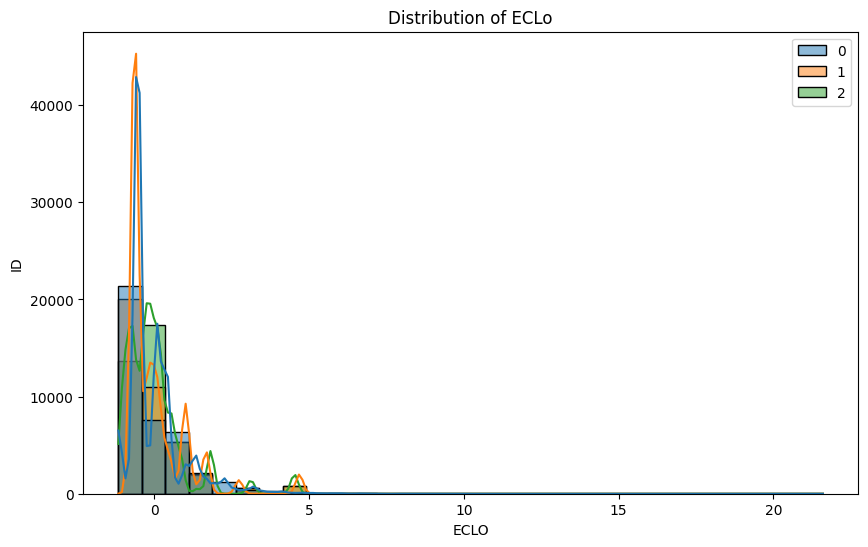

In [ ]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_std, bins=30, kde=True)
plt.title('Distribution of ECLo')
plt.xlabel('ECLO')
plt.ylabel('ID')
plt.show()

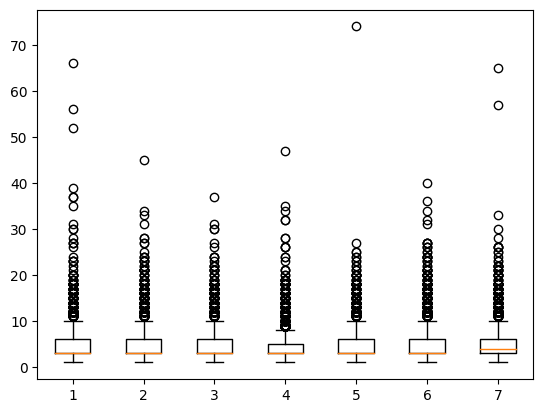

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '토요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '일요일'].loc[:,'ECLO',]])
plt.show()

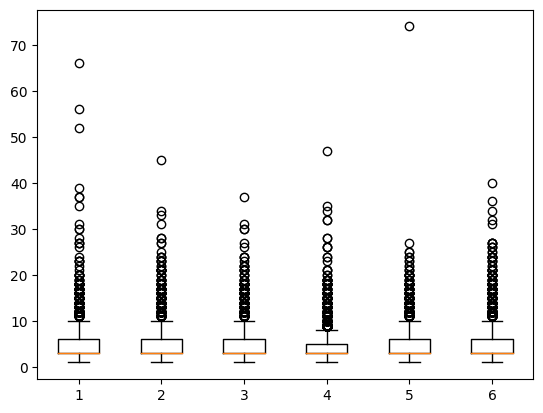

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

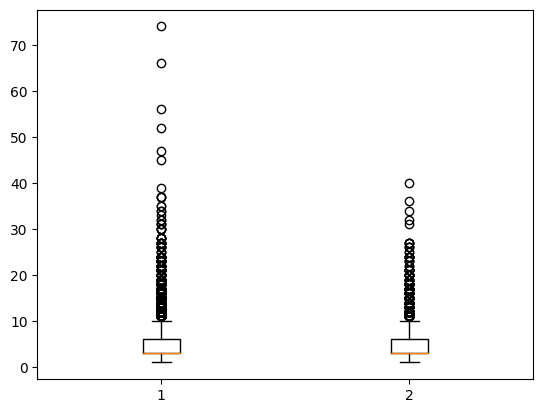

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[(train_df['요일'] == '월요일')|
                      (train_df['요일'] == '화요일')|
                      (train_df['요일'] == '수요일')|
                      (train_df['요일'] == '목요일')|
                      (train_df['요일'] == '금요일')].loc[:,'ECLO'],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

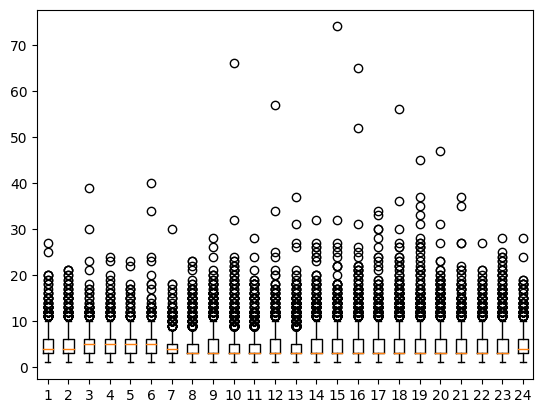

In [ ]:
plt.boxplot([train_df[train_df['시간'] == 0].loc[:,'ECLO',],
              train_df[train_df['시간'] == 1].loc[:,'ECLO',],
              train_df[train_df['시간'] == 2].loc[:,'ECLO'],
              train_df[train_df['시간'] == 3].loc[:,'ECLO',],
              train_df[train_df['시간'] == 4].loc[:,'ECLO',],
              train_df[train_df['시간'] == 5].loc[:,'ECLO',],
              train_df[train_df['시간'] == 6].loc[:,'ECLO',],
             train_df[train_df['시간'] == 7].loc[:,'ECLO',],
             train_df[train_df['시간'] == 8].loc[:,'ECLO',],
             train_df[train_df['시간'] == 9].loc[:,'ECLO',],
             train_df[train_df['시간'] == 10].loc[:,'ECLO',],
             train_df[train_df['시간'] == 11].loc[:,'ECLO',],
             train_df[train_df['시간'] == 12].loc[:,'ECLO',],
             train_df[train_df['시간'] == 13].loc[:,'ECLO',],
             train_df[train_df['시간'] == 14].loc[:,'ECLO',],
             train_df[train_df['시간'] == 15].loc[:,'ECLO',],
             train_df[train_df['시간'] == 16].loc[:,'ECLO',],
             train_df[train_df['시간'] == 17].loc[:,'ECLO',],
             train_df[train_df['시간'] == 18].loc[:,'ECLO',],
             train_df[train_df['시간'] == 19].loc[:,'ECLO',],
             train_df[train_df['시간'] == 20].loc[:,'ECLO',],
             train_df[train_df['시간'] == 21].loc[:,'ECLO',],
             train_df[train_df['시간'] == 22].loc[:,'ECLO',],
             train_df[train_df['시간'] == 23].loc[:,'ECLO',]])
plt.show()

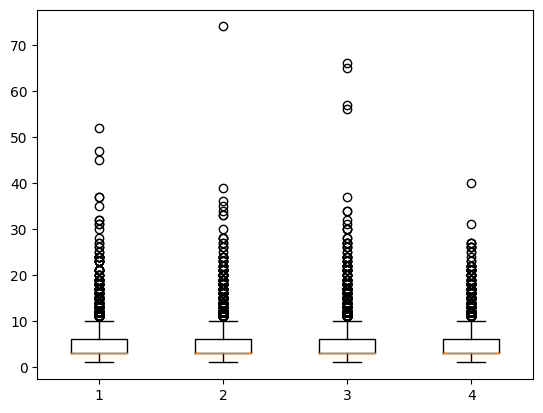

In [ ]:
plt.boxplot([train_df[(train_df['월'] >= 3)&(train_df['월'] <= 5)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 6)&(train_df['월'] <= 8)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 9)&(train_df['월'] <= 11)].loc[:,'ECLO'],
             train_df[(train_df['월'] == 12)|(train_df['월'] >= 1)&(train_df['월'] <= 2)].loc[:,'ECLO']])
plt.show()

In [279]:
train_df

,ID,요일,기상상태,노면상태,ECLO,연,월,일,시간,도시,...,어린이CCTV설치대수,CCTV개수,평균속도,도로형태3_골목,도로형태3_시골길,도로형태3_직선,도로형태3_혼잡,사고유형_차대사람,사고유형_차대차,사고유형_차량단독
0,ACCIDENT_00000,화요일,맑음,건조,5,2019,1,1,0,대구광역시,...,2.0,1.0,38.000000,1,0,0,0,1,0,0
1,ACCIDENT_00001,화요일,흐림,건조,3,2019,1,1,0,대구광역시,...,0.0,4.0,52.500000,1,0,0,0,1,0,0
2,ACCIDENT_00002,화요일,맑음,건조,3,2019,1,1,1,대구광역시,...,5.0,4.0,55.000000,0,0,0,1,1,0,0
3,ACCIDENT_00003,화요일,맑음,건조,5,2019,1,1,2,대구광역시,...,11.0,10.0,37.500000,1,0,0,0,0,1,0
4,ACCIDENT_00004,화요일,맑음,건조,3,2019,1,1,4,대구광역시,...,0.0,12.0,40.000000,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,3,2021,12,31,19,대구광역시,...,1.0,1.0,38.000000,0,0,0,1,0,1,0
39605,ACCIDENT_39605,금요일,맑음,건조,3,2021,12,31,19,대구광역시,...,0.0,18.0,45.000000,1,0,0,0,0,1,0
39606,ACCIDENT_39606,금요일,맑음,건조,10,2021,12,31,21,대구광역시,...,0.0,9.0,41.111111,1,0,0,0,0,1,0
39607,ACCIDENT_39607,금요일,맑음,건조,3,2021,12,31,22,대구광역시,...,0.0,1.0,60.000000,0,0,1,0,0,1,0


피처, 타겟 분리 라벨인코딩

In [280]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = train_df.drop(columns=['ID','ECLO'])
y = train_df['ECLO']
test_df = test_df.drop(columns=['ID'])
print(X.shape, y.shape, test_df.shape)

(39609, 23) (39609,) (10963, 23)


In [281]:
from sklearn.preprocessing import LabelEncoder

#FEATURE = ['기상상태','노면상태','사고유형','구','동','도로형태1','도로형태2','요일','도시']
FEATURE = ['기상상태','노면상태','구','동','도로형태1','도로형태2','요일','도시']
for i in FEATURE:
    le = LabelEncoder()
    X[i]= le.fit_transform(X[i])
    test_df[i]= le.transform(test_df[i])

X

,요일,기상상태,노면상태,연,월,일,시간,도시,구,동,...,어린이CCTV설치대수,CCTV개수,평균속도,도로형태3_골목,도로형태3_시골길,도로형태3_직선,도로형태3_혼잡,사고유형_차대사람,사고유형_차대차,사고유형_차량단독
0,6,2,0,2019,1,1,0,0,7,40,...,2.0,1.0,38.000000,1,0,0,0,1,0,0
1,6,5,0,2019,1,1,0,0,1,4,...,0.0,4.0,52.500000,1,0,0,0,1,0,0
2,6,2,0,2019,1,1,1,0,6,66,...,5.0,4.0,55.000000,0,0,0,1,1,0,0
3,6,2,0,2019,1,1,2,0,4,79,...,11.0,10.0,37.500000,1,0,0,0,0,1,0
4,6,2,0,2019,1,1,4,0,3,129,...,0.0,12.0,40.000000,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,2021,12,31,19,0,6,118,...,1.0,1.0,38.000000,0,0,0,1,0,1,0
39605,0,2,0,2021,12,31,19,0,1,103,...,0.0,18.0,45.000000,1,0,0,0,0,1,0
39606,0,2,0,2021,12,31,21,0,1,144,...,0.0,9.0,41.111111,1,0,0,0,0,1,0
39607,0,2,0,2021,12,31,22,0,1,158,...,0.0,1.0,60.000000,0,0,1,0,0,1,0


In [282]:
test_df

,요일,기상상태,노면상태,연,월,일,시간,도시,구,동,...,어린이CCTV설치대수,CCTV개수,평균속도,도로형태3_골목,도로형태3_시골길,도로형태3_직선,도로형태3_혼잡,사고유형_차대사람,사고유형_차대차,사고유형_차량단독
0,5,2,0,2022,1,1,1,0,6,99,...,5.0,4.0,52.500000,1,0,0,0,1,0,0
1,5,2,0,2022,1,1,1,0,6,168,...,10.0,7.0,47.142857,1,0,0,0,1,0,0
2,5,2,0,2022,1,1,4,0,6,117,...,1.0,1.0,38.000000,1,0,0,0,0,1,0
3,5,2,0,2022,1,1,4,0,6,126,...,7.0,11.0,42.727273,1,0,0,0,0,1,0
4,5,2,0,2022,1,1,6,0,1,4,...,0.0,4.0,52.500000,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,5,2,0,2022,12,31,18,0,0,38,...,26.0,27.0,48.636364,0,0,0,1,0,1,0
10959,5,2,0,2022,12,31,18,0,6,123,...,5.0,4.0,52.500000,1,0,0,0,0,1,0
10960,5,2,0,2022,12,31,20,0,6,134,...,0.0,0.0,0.000000,0,0,1,0,0,1,0
10961,5,2,0,2022,12,31,20,0,6,77,...,7.0,7.0,44.285714,0,0,0,1,0,1,0


모델 훈련 및 예측

In [283]:
#xgboost14.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # XGBoost의 하이퍼파라미터를 설정합니다.
    param = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, np.log1p(y_train), eval_set=[(X_val,np.log1p(y_val))],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.expm1(y_pred)))
    return rmsle

# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행합니다.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
final_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    eval_metric='rmsle',
    verbosity=0,
    n_jobs=-1,
    tree_method='hist',
    **best_params
)

final_model.fit(X, y, verbose=False)
y_pred = final_model.predict(test_df)

[I 2023-11-20 07:50:11,817] A new study created in memory with name: no-name-e761b347-4a7e-4713-8c88-852ea375be62


[0]	validation_0-rmsle:0.55722
[1]	validation_0-rmsle:0.53399
[2]	validation_0-rmsle:0.51158
[3]	validation_0-rmsle:0.48997
[4]	validation_0-rmsle:0.46919
[5]	validation_0-rmsle:0.44928
[6]	validation_0-rmsle:0.43013
[7]	validation_0-rmsle:0.41187
[8]	validation_0-rmsle:0.39441
[9]	validation_0-rmsle:0.37774
[10]	validation_0-rmsle:0.36192
[11]	validation_0-rmsle:0.34691
[12]	validation_0-rmsle:0.33273
[13]	validation_0-rmsle:0.31930
[14]	validation_0-rmsle:0.30672
[15]	validation_0-rmsle:0.29485
[16]	validation_0-rmsle:0.28377
[17]	validation_0-rmsle:0.27343
[18]	validation_0-rmsle:0.26380
[19]	validation_0-rmsle:0.25489
[20]	validation_0-rmsle:0.24665
[21]	validation_0-rmsle:0.23906
[22]	validation_0-rmsle:0.23207
[23]	validation_0-rmsle:0.22566
[24]	validation_0-rmsle:0.21984
[25]	validation_0-rmsle:0.21449
[26]	validation_0-rmsle:0.20966
[27]	validation_0-rmsle:0.20532
[28]	validation_0-rmsle:0.20139
[29]	validation_0-rmsle:0.19787
[30]	validation_0-rmsle:0.19471
[31]	validation_0-

[I 2023-11-20 07:50:15,904] Trial 0 finished with value: 0.44619978260676085 and parameters: {'lambda': 0.05188994548923539, 'alpha': 0.10181527821124604, 'colsample_bytree': 0.6361414040400046, 'subsample': 0.7787089794238564, 'learning_rate': 0.07147271702675448, 'n_estimators': 240, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 0 with value: 0.44619978260676085.


[0]	validation_0-rmsle:0.56073
[1]	validation_0-rmsle:0.54080
[2]	validation_0-rmsle:0.52146
[3]	validation_0-rmsle:0.50270
[4]	validation_0-rmsle:0.48452
[5]	validation_0-rmsle:0.46702
[6]	validation_0-rmsle:0.45004
[7]	validation_0-rmsle:0.43373
[8]	validation_0-rmsle:0.41795
[9]	validation_0-rmsle:0.40278
[10]	validation_0-rmsle:0.38828
[11]	validation_0-rmsle:0.37435
[12]	validation_0-rmsle:0.36105
[13]	validation_0-rmsle:0.34827
[14]	validation_0-rmsle:0.33610
[15]	validation_0-rmsle:0.32446
[16]	validation_0-rmsle:0.31344
[17]	validation_0-rmsle:0.30299
[18]	validation_0-rmsle:0.29311
[19]	validation_0-rmsle:0.28377
[20]	validation_0-rmsle:0.27496
[21]	validation_0-rmsle:0.26667
[22]	validation_0-rmsle:0.25888
[23]	validation_0-rmsle:0.25154
[24]	validation_0-rmsle:0.24479
[25]	validation_0-rmsle:0.23840
[26]	validation_0-rmsle:0.23244
[27]	validation_0-rmsle:0.22702
[28]	validation_0-rmsle:0.22191
[29]	validation_0-rmsle:0.21724
[30]	validation_0-rmsle:0.21292
[31]	validation_0-

[I 2023-11-20 07:50:19,664] Trial 1 finished with value: 0.44749085261514815 and parameters: {'lambda': 0.05558225883546875, 'alpha': 0.22852265781357503, 'colsample_bytree': 0.5328748583152627, 'subsample': 0.509551412514041, 'learning_rate': 0.060904099320433745, 'n_estimators': 732, 'max_depth': 7, 'min_child_weight': 4}. Best is trial 0 with value: 0.44619978260676085.


[0]	validation_0-rmsle:0.55500
[1]	validation_0-rmsle:0.52972
[2]	validation_0-rmsle:0.50540
[3]	validation_0-rmsle:0.48204
[4]	validation_0-rmsle:0.45968
[5]	validation_0-rmsle:0.43835
[6]	validation_0-rmsle:0.41796
[7]	validation_0-rmsle:0.39861
[8]	validation_0-rmsle:0.38022
[9]	validation_0-rmsle:0.36279
[10]	validation_0-rmsle:0.34636
[11]	validation_0-rmsle:0.33091
[12]	validation_0-rmsle:0.31642
[13]	validation_0-rmsle:0.30284
[14]	validation_0-rmsle:0.29023
[15]	validation_0-rmsle:0.27848
[16]	validation_0-rmsle:0.26761
[17]	validation_0-rmsle:0.25761
[18]	validation_0-rmsle:0.24841
[19]	validation_0-rmsle:0.23999
[20]	validation_0-rmsle:0.23234
[21]	validation_0-rmsle:0.22542
[22]	validation_0-rmsle:0.21912
[23]	validation_0-rmsle:0.21344
[24]	validation_0-rmsle:0.20837
[25]	validation_0-rmsle:0.20379
[26]	validation_0-rmsle:0.19973
[27]	validation_0-rmsle:0.19614
[28]	validation_0-rmsle:0.19294
[29]	validation_0-rmsle:0.19014
[30]	validation_0-rmsle:0.18765
[31]	validation_0-

[I 2023-11-20 07:50:26,099] Trial 2 finished with value: 0.44640790481647397 and parameters: {'lambda': 0.0069442107261887395, 'alpha': 0.77607451273104, 'colsample_bytree': 0.5959330745906218, 'subsample': 0.8586441240821133, 'learning_rate': 0.07818773929181538, 'n_estimators': 150, 'max_depth': 7, 'min_child_weight': 35}. Best is trial 0 with value: 0.44619978260676085.


[0]	validation_0-rmsle:0.57678
[1]	validation_0-rmsle:0.57231
[2]	validation_0-rmsle:0.56787
[3]	validation_0-rmsle:0.56346
[4]	validation_0-rmsle:0.55908
[5]	validation_0-rmsle:0.55472
[6]	validation_0-rmsle:0.55039
[7]	validation_0-rmsle:0.54609
[8]	validation_0-rmsle:0.54182
[9]	validation_0-rmsle:0.53757
[10]	validation_0-rmsle:0.53336
[11]	validation_0-rmsle:0.52917
[12]	validation_0-rmsle:0.52502
[13]	validation_0-rmsle:0.52088
[14]	validation_0-rmsle:0.51678
[15]	validation_0-rmsle:0.51270
[16]	validation_0-rmsle:0.50866
[17]	validation_0-rmsle:0.50464
[18]	validation_0-rmsle:0.50065
[19]	validation_0-rmsle:0.49669
[20]	validation_0-rmsle:0.49276
[21]	validation_0-rmsle:0.48885
[22]	validation_0-rmsle:0.48498
[23]	validation_0-rmsle:0.48113
[24]	validation_0-rmsle:0.47731
[25]	validation_0-rmsle:0.47351
[26]	validation_0-rmsle:0.46974
[27]	validation_0-rmsle:0.46601
[28]	validation_0-rmsle:0.46230
[29]	validation_0-rmsle:0.45862
[30]	validation_0-rmsle:0.45497
[31]	validation_0-

[I 2023-11-20 07:50:39,682] Trial 3 finished with value: 0.44703793958356575 and parameters: {'lambda': 0.06961201061897883, 'alpha': 0.2032507678303693, 'colsample_bytree': 0.980251080928283, 'subsample': 0.7617173191632076, 'learning_rate': 0.013207133584547911, 'n_estimators': 658, 'max_depth': 8, 'min_child_weight': 20}. Best is trial 0 with value: 0.44619978260676085.


[0]	validation_0-rmsle:0.56184
[1]	validation_0-rmsle:0.54293
[2]	validation_0-rmsle:0.52456
[3]	validation_0-rmsle:0.50671
[4]	validation_0-rmsle:0.48940
[5]	validation_0-rmsle:0.47265
[6]	validation_0-rmsle:0.45640
[7]	validation_0-rmsle:0.44073
[8]	validation_0-rmsle:0.42557
[9]	validation_0-rmsle:0.41093
[10]	validation_0-rmsle:0.39686
[11]	validation_0-rmsle:0.38331
[12]	validation_0-rmsle:0.37031
[13]	validation_0-rmsle:0.35781
[14]	validation_0-rmsle:0.34588
[15]	validation_0-rmsle:0.33445
[16]	validation_0-rmsle:0.32353
[17]	validation_0-rmsle:0.31314
[18]	validation_0-rmsle:0.30324
[19]	validation_0-rmsle:0.29385
[20]	validation_0-rmsle:0.28496
[21]	validation_0-rmsle:0.27655
[22]	validation_0-rmsle:0.26858
[23]	validation_0-rmsle:0.26107
[24]	validation_0-rmsle:0.25402
[25]	validation_0-rmsle:0.24736
[26]	validation_0-rmsle:0.24114
[27]	validation_0-rmsle:0.23535
[28]	validation_0-rmsle:0.22993
[29]	validation_0-rmsle:0.22490
[30]	validation_0-rmsle:0.22021
[31]	validation_0-

[I 2023-11-20 07:50:49,400] Trial 4 finished with value: 0.4461608106343906 and parameters: {'lambda': 0.010863268118286168, 'alpha': 0.14866526322254148, 'colsample_bytree': 0.6112604862642476, 'subsample': 0.8045585417095015, 'learning_rate': 0.05760208439346632, 'n_estimators': 579, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 4 with value: 0.4461608106343906.


[0]	validation_0-rmsle:0.56076
[1]	validation_0-rmsle:0.54084
[2]	validation_0-rmsle:0.52150
[3]	validation_0-rmsle:0.50275
[4]	validation_0-rmsle:0.48460
[5]	validation_0-rmsle:0.46705
[6]	validation_0-rmsle:0.45009
[7]	validation_0-rmsle:0.43375
[8]	validation_0-rmsle:0.41800
[9]	validation_0-rmsle:0.40286
[10]	validation_0-rmsle:0.38831
[11]	validation_0-rmsle:0.37437
[12]	validation_0-rmsle:0.36102
[13]	validation_0-rmsle:0.34826
[14]	validation_0-rmsle:0.33610
[15]	validation_0-rmsle:0.32452
[16]	validation_0-rmsle:0.31351
[17]	validation_0-rmsle:0.30306
[18]	validation_0-rmsle:0.29318
[19]	validation_0-rmsle:0.28384
[20]	validation_0-rmsle:0.27502
[21]	validation_0-rmsle:0.26674
[22]	validation_0-rmsle:0.25895
[23]	validation_0-rmsle:0.25166
[24]	validation_0-rmsle:0.24485
[25]	validation_0-rmsle:0.23850
[26]	validation_0-rmsle:0.23259
[27]	validation_0-rmsle:0.22712
[28]	validation_0-rmsle:0.22206
[29]	validation_0-rmsle:0.21738
[30]	validation_0-rmsle:0.21306
[31]	validation_0-

[I 2023-11-20 07:50:54,784] Trial 5 finished with value: 0.4465573092217208 and parameters: {'lambda': 0.05663155994980966, 'alpha': 0.9545855153537169, 'colsample_bytree': 0.990795642408712, 'subsample': 0.9508341162190218, 'learning_rate': 0.06085173339670865, 'n_estimators': 237, 'max_depth': 7, 'min_child_weight': 39}. Best is trial 4 with value: 0.4461608106343906.


[0]	validation_0-rmsle:0.54972
[1]	validation_0-rmsle:0.51955
[2]	validation_0-rmsle:0.49080
[3]	validation_0-rmsle:0.46346
[4]	validation_0-rmsle:0.43757
[5]	validation_0-rmsle:0.41315
[6]	validation_0-rmsle:0.39011
[7]	validation_0-rmsle:0.36857
[8]	validation_0-rmsle:0.34842
[9]	validation_0-rmsle:0.32967
[10]	validation_0-rmsle:0.31230
[11]	validation_0-rmsle:0.29634
[12]	validation_0-rmsle:0.28168
[13]	validation_0-rmsle:0.26831
[14]	validation_0-rmsle:0.25622
[15]	validation_0-rmsle:0.24527
[16]	validation_0-rmsle:0.23547
[17]	validation_0-rmsle:0.22674
[18]	validation_0-rmsle:0.21901
[19]	validation_0-rmsle:0.21217
[20]	validation_0-rmsle:0.20616
[21]	validation_0-rmsle:0.20095
[22]	validation_0-rmsle:0.19642
[23]	validation_0-rmsle:0.19250
[24]	validation_0-rmsle:0.18915
[25]	validation_0-rmsle:0.18627
[26]	validation_0-rmsle:0.18381
[27]	validation_0-rmsle:0.18175
[28]	validation_0-rmsle:0.17998
[29]	validation_0-rmsle:0.17853
[30]	validation_0-rmsle:0.17730
[31]	validation_0-

[I 2023-11-20 07:50:59,234] Trial 6 finished with value: 0.4461059537127763 and parameters: {'lambda': 0.052223728657689816, 'alpha': 0.2704488583894295, 'colsample_bytree': 0.619567287815276, 'subsample': 0.92470237082066, 'learning_rate': 0.09427722253231073, 'n_estimators': 245, 'max_depth': 5, 'min_child_weight': 36}. Best is trial 6 with value: 0.4461059537127763.


[0]	validation_0-rmsle:0.56631
[1]	validation_0-rmsle:0.55169
[2]	validation_0-rmsle:0.53736
[3]	validation_0-rmsle:0.52333
[4]	validation_0-rmsle:0.50962
[5]	validation_0-rmsle:0.49625
[6]	validation_0-rmsle:0.48317
[7]	validation_0-rmsle:0.47044
[8]	validation_0-rmsle:0.45799
[9]	validation_0-rmsle:0.44586
[10]	validation_0-rmsle:0.43405
[11]	validation_0-rmsle:0.42260
[12]	validation_0-rmsle:0.41145
[13]	validation_0-rmsle:0.40062
[14]	validation_0-rmsle:0.39009
[15]	validation_0-rmsle:0.37987
[16]	validation_0-rmsle:0.36996
[17]	validation_0-rmsle:0.36037
[18]	validation_0-rmsle:0.35109
[19]	validation_0-rmsle:0.34214
[20]	validation_0-rmsle:0.33349
[21]	validation_0-rmsle:0.32513
[22]	validation_0-rmsle:0.31708
[23]	validation_0-rmsle:0.30929
[24]	validation_0-rmsle:0.30182
[25]	validation_0-rmsle:0.29462
[26]	validation_0-rmsle:0.28772
[27]	validation_0-rmsle:0.28115
[28]	validation_0-rmsle:0.27476
[29]	validation_0-rmsle:0.26869
[30]	validation_0-rmsle:0.26289
[31]	validation_0-

[I 2023-11-20 07:51:06,733] Trial 7 finished with value: 0.447590225356602 and parameters: {'lambda': 0.019104434739046383, 'alpha': 0.05772730562507997, 'colsample_bytree': 0.9493609869460283, 'subsample': 0.6253946780674662, 'learning_rate': 0.04419126551128626, 'n_estimators': 311, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 6 with value: 0.4461059537127763.


[0]	validation_0-rmsle:0.55180
[1]	validation_0-rmsle:0.52357
[2]	validation_0-rmsle:0.49658
[3]	validation_0-rmsle:0.47081
[4]	validation_0-rmsle:0.44629
[5]	validation_0-rmsle:0.42304
[6]	validation_0-rmsle:0.40098
[7]	validation_0-rmsle:0.38023
[8]	validation_0-rmsle:0.36071
[9]	validation_0-rmsle:0.34240
[10]	validation_0-rmsle:0.32535
[11]	validation_0-rmsle:0.30948
[12]	validation_0-rmsle:0.29480
[13]	validation_0-rmsle:0.28123
[14]	validation_0-rmsle:0.26883
[15]	validation_0-rmsle:0.25746
[16]	validation_0-rmsle:0.24715
[17]	validation_0-rmsle:0.23780
[18]	validation_0-rmsle:0.22940
[19]	validation_0-rmsle:0.22189
[20]	validation_0-rmsle:0.21522
[21]	validation_0-rmsle:0.20931
[22]	validation_0-rmsle:0.20408
[23]	validation_0-rmsle:0.19946
[24]	validation_0-rmsle:0.19544
[25]	validation_0-rmsle:0.19190
[26]	validation_0-rmsle:0.18886
[27]	validation_0-rmsle:0.18626
[28]	validation_0-rmsle:0.18400
[29]	validation_0-rmsle:0.18204
[30]	validation_0-rmsle:0.18036
[31]	validation_0-

[I 2023-11-20 07:51:13,335] Trial 8 finished with value: 0.4463961708184264 and parameters: {'lambda': 0.06169773069542401, 'alpha': 0.5246564126245011, 'colsample_bytree': 0.9690560896717535, 'subsample': 0.7751400594202924, 'learning_rate': 0.08785934307442729, 'n_estimators': 374, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 6 with value: 0.4461059537127763.


[0]	validation_0-rmsle:0.57047
[1]	validation_0-rmsle:0.55984
[2]	validation_0-rmsle:0.54936
[3]	validation_0-rmsle:0.53904
[4]	validation_0-rmsle:0.52887
[5]	validation_0-rmsle:0.51891
[6]	validation_0-rmsle:0.50907
[7]	validation_0-rmsle:0.49943
[8]	validation_0-rmsle:0.48993
[9]	validation_0-rmsle:0.48059
[10]	validation_0-rmsle:0.47143
[11]	validation_0-rmsle:0.46244
[12]	validation_0-rmsle:0.45362
[13]	validation_0-rmsle:0.44494
[14]	validation_0-rmsle:0.43645
[15]	validation_0-rmsle:0.42810
[16]	validation_0-rmsle:0.41993
[17]	validation_0-rmsle:0.41193
[18]	validation_0-rmsle:0.40408
[19]	validation_0-rmsle:0.39641
[20]	validation_0-rmsle:0.38891
[21]	validation_0-rmsle:0.38156
[22]	validation_0-rmsle:0.37437
[23]	validation_0-rmsle:0.36732
[24]	validation_0-rmsle:0.36047
[25]	validation_0-rmsle:0.35374
[26]	validation_0-rmsle:0.34718
[27]	validation_0-rmsle:0.34082
[28]	validation_0-rmsle:0.33455
[29]	validation_0-rmsle:0.32848
[30]	validation_0-rmsle:0.32258
[31]	validation_0-

[I 2023-11-20 07:51:20,022] Trial 9 finished with value: 0.4465269723459199 and parameters: {'lambda': 0.08746936501400226, 'alpha': 0.45809804004342153, 'colsample_bytree': 0.6791954673459089, 'subsample': 0.5694893716963434, 'learning_rate': 0.031851874442463776, 'n_estimators': 855, 'max_depth': 6, 'min_child_weight': 15}. Best is trial 6 with value: 0.4461059537127763.


[0]	validation_0-rmsle:0.54810
[1]	validation_0-rmsle:0.51647
[2]	validation_0-rmsle:0.48640
[3]	validation_0-rmsle:0.45790
[4]	validation_0-rmsle:0.43100
[5]	validation_0-rmsle:0.40573
[6]	validation_0-rmsle:0.38204
[7]	validation_0-rmsle:0.35995
[8]	validation_0-rmsle:0.33939
[9]	validation_0-rmsle:0.32039
[10]	validation_0-rmsle:0.30291
[11]	validation_0-rmsle:0.28696
[12]	validation_0-rmsle:0.27246
[13]	validation_0-rmsle:0.25930
[14]	validation_0-rmsle:0.24753
[15]	validation_0-rmsle:0.23698
[16]	validation_0-rmsle:0.22761
[17]	validation_0-rmsle:0.21940
[18]	validation_0-rmsle:0.21219
[19]	validation_0-rmsle:0.20595
[20]	validation_0-rmsle:0.20054
[21]	validation_0-rmsle:0.19590
[22]	validation_0-rmsle:0.19187
[23]	validation_0-rmsle:0.18847
[24]	validation_0-rmsle:0.18563
[25]	validation_0-rmsle:0.18322
[26]	validation_0-rmsle:0.18116
[27]	validation_0-rmsle:0.17946
[28]	validation_0-rmsle:0.17802
[29]	validation_0-rmsle:0.17685
[30]	validation_0-rmsle:0.17587
[31]	validation_0-

[I 2023-11-20 07:51:26,627] Trial 10 finished with value: 0.4462167910698019 and parameters: {'lambda': 0.03223396481693128, 'alpha': 0.3808849070353758, 'colsample_bytree': 0.4137792873875908, 'subsample': 0.9693924766309101, 'learning_rate': 0.09920704963611726, 'n_estimators': 413, 'max_depth': 5, 'min_child_weight': 50}. Best is trial 6 with value: 0.4461059537127763.


[0]	validation_0-rmsle:0.54826
[1]	validation_0-rmsle:0.51680
[2]	validation_0-rmsle:0.48691
[3]	validation_0-rmsle:0.45855
[4]	validation_0-rmsle:0.43171
[5]	validation_0-rmsle:0.40664
[6]	validation_0-rmsle:0.38298
[7]	validation_0-rmsle:0.36091
[8]	validation_0-rmsle:0.34041
[9]	validation_0-rmsle:0.32136
[10]	validation_0-rmsle:0.30397
[11]	validation_0-rmsle:0.28804
[12]	validation_0-rmsle:0.27351
[13]	validation_0-rmsle:0.26032
[14]	validation_0-rmsle:0.24850
[15]	validation_0-rmsle:0.23785
[16]	validation_0-rmsle:0.22843
[17]	validation_0-rmsle:0.22014
[18]	validation_0-rmsle:0.21292
[19]	validation_0-rmsle:0.20653
[20]	validation_0-rmsle:0.20100
[21]	validation_0-rmsle:0.19623
[22]	validation_0-rmsle:0.19218
[23]	validation_0-rmsle:0.18875
[24]	validation_0-rmsle:0.18584
[25]	validation_0-rmsle:0.18333
[26]	validation_0-rmsle:0.18124
[27]	validation_0-rmsle:0.17953
[28]	validation_0-rmsle:0.17805
[29]	validation_0-rmsle:0.17684
[30]	validation_0-rmsle:0.17587
[31]	validation_0-

[I 2023-11-20 07:51:33,149] Trial 11 finished with value: 0.44650190596927636 and parameters: {'lambda': 0.03235237074296013, 'alpha': 0.0056632594666204406, 'colsample_bytree': 0.7555310694782916, 'subsample': 0.41715539618244263, 'learning_rate': 0.09865041735697966, 'n_estimators': 536, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 6 with value: 0.4461059537127763.


[0]	validation_0-rmsle:0.55487
[1]	validation_0-rmsle:0.52946
[2]	validation_0-rmsle:0.50501
[3]	validation_0-rmsle:0.48156
[4]	validation_0-rmsle:0.45910
[5]	validation_0-rmsle:0.43767
[6]	validation_0-rmsle:0.41720
[7]	validation_0-rmsle:0.39775
[8]	validation_0-rmsle:0.37930
[9]	validation_0-rmsle:0.36183
[10]	validation_0-rmsle:0.34536
[11]	validation_0-rmsle:0.32987
[12]	validation_0-rmsle:0.31534
[13]	validation_0-rmsle:0.30173
[14]	validation_0-rmsle:0.28911
[15]	validation_0-rmsle:0.27737
[16]	validation_0-rmsle:0.26651
[17]	validation_0-rmsle:0.25651
[18]	validation_0-rmsle:0.24733
[19]	validation_0-rmsle:0.23893
[20]	validation_0-rmsle:0.23129
[21]	validation_0-rmsle:0.22437
[22]	validation_0-rmsle:0.21809
[23]	validation_0-rmsle:0.21243
[24]	validation_0-rmsle:0.20737
[25]	validation_0-rmsle:0.20281
[26]	validation_0-rmsle:0.19881
[27]	validation_0-rmsle:0.19526
[28]	validation_0-rmsle:0.19210
[29]	validation_0-rmsle:0.18933
[30]	validation_0-rmsle:0.18688
[31]	validation_0-

[I 2023-11-20 07:51:38,048] Trial 12 finished with value: 0.44600818927106256 and parameters: {'lambda': 0.003547648204658263, 'alpha': 0.2839743716338718, 'colsample_bytree': 0.7596727899554951, 'subsample': 0.8663131719823871, 'learning_rate': 0.07859432048780482, 'n_estimators': 526, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55445
[1]	validation_0-rmsle:0.52863
[2]	validation_0-rmsle:0.50382
[3]	validation_0-rmsle:0.48002
[4]	validation_0-rmsle:0.45726
[5]	validation_0-rmsle:0.43558
[6]	validation_0-rmsle:0.41488
[7]	validation_0-rmsle:0.39522
[8]	validation_0-rmsle:0.37660
[9]	validation_0-rmsle:0.35901
[10]	validation_0-rmsle:0.34243
[11]	validation_0-rmsle:0.32686
[12]	validation_0-rmsle:0.31229
[13]	validation_0-rmsle:0.29869
[14]	validation_0-rmsle:0.28608
[15]	validation_0-rmsle:0.27437
[16]	validation_0-rmsle:0.26357
[17]	validation_0-rmsle:0.25366
[18]	validation_0-rmsle:0.24458
[19]	validation_0-rmsle:0.23630
[20]	validation_0-rmsle:0.22876
[21]	validation_0-rmsle:0.22198
[22]	validation_0-rmsle:0.21584
[23]	validation_0-rmsle:0.21032
[24]	validation_0-rmsle:0.20540
[25]	validation_0-rmsle:0.20102
[26]	validation_0-rmsle:0.19714
[27]	validation_0-rmsle:0.19371
[28]	validation_0-rmsle:0.19070
[29]	validation_0-rmsle:0.18807
[30]	validation_0-rmsle:0.18576
[31]	validation_0-

[I 2023-11-20 07:51:42,019] Trial 13 finished with value: 0.446294604265516 and parameters: {'lambda': 0.002826437192435624, 'alpha': 0.31517242685241387, 'colsample_bytree': 0.777898404988669, 'subsample': 0.897917520472228, 'learning_rate': 0.07989879202247877, 'n_estimators': 985, 'max_depth': 5, 'min_child_weight': 29}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55232
[1]	validation_0-rmsle:0.52455
[2]	validation_0-rmsle:0.49795
[3]	validation_0-rmsle:0.47254
[4]	validation_0-rmsle:0.44834
[5]	validation_0-rmsle:0.42536
[6]	validation_0-rmsle:0.40356
[7]	validation_0-rmsle:0.38298
[8]	validation_0-rmsle:0.36360
[9]	validation_0-rmsle:0.34541
[10]	validation_0-rmsle:0.32841
[11]	validation_0-rmsle:0.31257
[12]	validation_0-rmsle:0.29788
[13]	validation_0-rmsle:0.28429
[14]	validation_0-rmsle:0.27183
[15]	validation_0-rmsle:0.26039
[16]	validation_0-rmsle:0.24996
[17]	validation_0-rmsle:0.24053
[18]	validation_0-rmsle:0.23200
[19]	validation_0-rmsle:0.22432
[20]	validation_0-rmsle:0.21747
[21]	validation_0-rmsle:0.21138
[22]	validation_0-rmsle:0.20595
[23]	validation_0-rmsle:0.20115
[24]	validation_0-rmsle:0.19695
[25]	validation_0-rmsle:0.19328
[26]	validation_0-rmsle:0.19007
[27]	validation_0-rmsle:0.18729
[28]	validation_0-rmsle:0.18490
[29]	validation_0-rmsle:0.18285
[30]	validation_0-rmsle:0.18107
[31]	validation_0-

[I 2023-11-20 07:51:46,162] Trial 14 finished with value: 0.4461247893771273 and parameters: {'lambda': 0.04016396334957408, 'alpha': 0.29931392890489245, 'colsample_bytree': 0.8128740264646859, 'subsample': 0.8942193757625894, 'learning_rate': 0.08634413724304407, 'n_estimators': 467, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55817
[1]	validation_0-rmsle:0.53580
[2]	validation_0-rmsle:0.51419
[3]	validation_0-rmsle:0.49332
[4]	validation_0-rmsle:0.47322
[5]	validation_0-rmsle:0.45388
[6]	validation_0-rmsle:0.43531
[7]	validation_0-rmsle:0.41750
[8]	validation_0-rmsle:0.40046
[9]	validation_0-rmsle:0.38418
[10]	validation_0-rmsle:0.36866
[11]	validation_0-rmsle:0.35390
[12]	validation_0-rmsle:0.33988
[13]	validation_0-rmsle:0.32662
[14]	validation_0-rmsle:0.31411
[15]	validation_0-rmsle:0.30229
[16]	validation_0-rmsle:0.29119
[17]	validation_0-rmsle:0.28079
[18]	validation_0-rmsle:0.27106
[19]	validation_0-rmsle:0.26199
[20]	validation_0-rmsle:0.25356
[21]	validation_0-rmsle:0.24575
[22]	validation_0-rmsle:0.23850
[23]	validation_0-rmsle:0.23184
[24]	validation_0-rmsle:0.22572
[25]	validation_0-rmsle:0.22011
[26]	validation_0-rmsle:0.21499
[27]	validation_0-rmsle:0.21032
[28]	validation_0-rmsle:0.20610
[29]	validation_0-rmsle:0.20227
[30]	validation_0-rmsle:0.19880
[31]	validation_0-

[I 2023-11-20 07:51:51,042] Trial 15 finished with value: 0.4463218346292892 and parameters: {'lambda': 0.021984272793475756, 'alpha': 0.5365064311951186, 'colsample_bytree': 0.8479012701162102, 'subsample': 0.9643437705992807, 'learning_rate': 0.06866455201577185, 'n_estimators': 115, 'max_depth': 5, 'min_child_weight': 29}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55111
[1]	validation_0-rmsle:0.52226
[2]	validation_0-rmsle:0.49469
[3]	validation_0-rmsle:0.46841
[4]	validation_0-rmsle:0.44342
[5]	validation_0-rmsle:0.41978
[6]	validation_0-rmsle:0.39740
[7]	validation_0-rmsle:0.37641
[8]	validation_0-rmsle:0.35666
[9]	validation_0-rmsle:0.33819
[10]	validation_0-rmsle:0.32102
[11]	validation_0-rmsle:0.30511
[12]	validation_0-rmsle:0.29044
[13]	validation_0-rmsle:0.27691
[14]	validation_0-rmsle:0.26461
[15]	validation_0-rmsle:0.25335
[16]	validation_0-rmsle:0.24319
[17]	validation_0-rmsle:0.23404
[18]	validation_0-rmsle:0.22582
[19]	validation_0-rmsle:0.21854
[20]	validation_0-rmsle:0.21209
[21]	validation_0-rmsle:0.20641
[22]	validation_0-rmsle:0.20142
[23]	validation_0-rmsle:0.19702
[24]	validation_0-rmsle:0.19322
[25]	validation_0-rmsle:0.18988
[26]	validation_0-rmsle:0.18704
[27]	validation_0-rmsle:0.18463
[28]	validation_0-rmsle:0.18250
[29]	validation_0-rmsle:0.18072
[30]	validation_0-rmsle:0.17921
[31]	validation_0-

[I 2023-11-20 07:51:57,616] Trial 16 finished with value: 0.44678914283637805 and parameters: {'lambda': 0.04373260926301484, 'alpha': 0.38987237541982434, 'colsample_bytree': 0.7078977376871975, 'subsample': 0.7138657101087449, 'learning_rate': 0.08998422402448242, 'n_estimators': 744, 'max_depth': 6, 'min_child_weight': 24}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55590
[1]	validation_0-rmsle:0.53143
[2]	validation_0-rmsle:0.50786
[3]	validation_0-rmsle:0.48521
[4]	validation_0-rmsle:0.46347
[5]	validation_0-rmsle:0.44268
[6]	validation_0-rmsle:0.42279
[7]	validation_0-rmsle:0.40384
[8]	validation_0-rmsle:0.38580
[9]	validation_0-rmsle:0.36867
[10]	validation_0-rmsle:0.35246
[11]	validation_0-rmsle:0.33716
[12]	validation_0-rmsle:0.32275
[13]	validation_0-rmsle:0.30921
[14]	validation_0-rmsle:0.29655
[15]	validation_0-rmsle:0.28474
[16]	validation_0-rmsle:0.27375
[17]	validation_0-rmsle:0.26360
[18]	validation_0-rmsle:0.25419
[19]	validation_0-rmsle:0.24553
[20]	validation_0-rmsle:0.23759
[21]	validation_0-rmsle:0.23036
[22]	validation_0-rmsle:0.22376
[23]	validation_0-rmsle:0.21778
[24]	validation_0-rmsle:0.21237
[25]	validation_0-rmsle:0.20751
[26]	validation_0-rmsle:0.20315
[27]	validation_0-rmsle:0.19926
[28]	validation_0-rmsle:0.19579
[29]	validation_0-rmsle:0.19272
[30]	validation_0-rmsle:0.18999
[31]	validation_0-

[I 2023-11-20 07:52:02,313] Trial 17 finished with value: 0.4463386877924417 and parameters: {'lambda': 0.07235085847128397, 'alpha': 0.20836266613685406, 'colsample_bytree': 0.7127978169348241, 'subsample': 0.9974851788851261, 'learning_rate': 0.07547932416854891, 'n_estimators': 482, 'max_depth': 5, 'min_child_weight': 50}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.54824
[1]	validation_0-rmsle:0.51676
[2]	validation_0-rmsle:0.48683
[3]	validation_0-rmsle:0.45846
[4]	validation_0-rmsle:0.43166
[5]	validation_0-rmsle:0.40646
[6]	validation_0-rmsle:0.38280
[7]	validation_0-rmsle:0.36076
[8]	validation_0-rmsle:0.34026
[9]	validation_0-rmsle:0.32127
[10]	validation_0-rmsle:0.30382
[11]	validation_0-rmsle:0.28786
[12]	validation_0-rmsle:0.27332
[13]	validation_0-rmsle:0.26014
[14]	validation_0-rmsle:0.24836
[15]	validation_0-rmsle:0.23780
[16]	validation_0-rmsle:0.22841
[17]	validation_0-rmsle:0.22014
[18]	validation_0-rmsle:0.21287
[19]	validation_0-rmsle:0.20655
[20]	validation_0-rmsle:0.20111
[21]	validation_0-rmsle:0.19643
[22]	validation_0-rmsle:0.19239
[23]	validation_0-rmsle:0.18894
[24]	validation_0-rmsle:0.18601
[25]	validation_0-rmsle:0.18351
[26]	validation_0-rmsle:0.18142
[27]	validation_0-rmsle:0.17968
[28]	validation_0-rmsle:0.17822
[29]	validation_0-rmsle:0.17702
[30]	validation_0-rmsle:0.17602
[31]	validation_0-

[I 2023-11-20 07:52:06,784] Trial 18 finished with value: 0.4463280948049544 and parameters: {'lambda': 0.02135860606967087, 'alpha': 0.6129684040367238, 'colsample_bytree': 0.8689597989921822, 'subsample': 0.8286184484541383, 'learning_rate': 0.09871046877054203, 'n_estimators': 328, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55294
[1]	validation_0-rmsle:0.52573
[2]	validation_0-rmsle:0.49964
[3]	validation_0-rmsle:0.47469
[4]	validation_0-rmsle:0.45090
[5]	validation_0-rmsle:0.42832
[6]	validation_0-rmsle:0.40685
[7]	validation_0-rmsle:0.38656
[8]	validation_0-rmsle:0.36739
[9]	validation_0-rmsle:0.34935
[10]	validation_0-rmsle:0.33245
[11]	validation_0-rmsle:0.31667
[12]	validation_0-rmsle:0.30203
[13]	validation_0-rmsle:0.28842
[14]	validation_0-rmsle:0.27589
[15]	validation_0-rmsle:0.26434
[16]	validation_0-rmsle:0.25378
[17]	validation_0-rmsle:0.24420
[18]	validation_0-rmsle:0.23548
[19]	validation_0-rmsle:0.22761
[20]	validation_0-rmsle:0.22053
[21]	validation_0-rmsle:0.21423
[22]	validation_0-rmsle:0.20861
[23]	validation_0-rmsle:0.20361
[24]	validation_0-rmsle:0.19925
[25]	validation_0-rmsle:0.19535
[26]	validation_0-rmsle:0.19196
[27]	validation_0-rmsle:0.18901
[28]	validation_0-rmsle:0.18644
[29]	validation_0-rmsle:0.18424
[30]	validation_0-rmsle:0.18232
[31]	validation_0-

[I 2023-11-20 07:52:12,993] Trial 19 finished with value: 0.4464647203380491 and parameters: {'lambda': 0.09988939427522064, 'alpha': 0.10829339187508241, 'colsample_bytree': 0.5572769074267783, 'subsample': 0.8955121942684341, 'learning_rate': 0.08446892545574987, 'n_estimators': 557, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55808
[1]	validation_0-rmsle:0.53566
[2]	validation_0-rmsle:0.51399
[3]	validation_0-rmsle:0.49307
[4]	validation_0-rmsle:0.47290
[5]	validation_0-rmsle:0.45352
[6]	validation_0-rmsle:0.43489
[7]	validation_0-rmsle:0.41708
[8]	validation_0-rmsle:0.40001
[9]	validation_0-rmsle:0.38368
[10]	validation_0-rmsle:0.36815
[11]	validation_0-rmsle:0.35337
[12]	validation_0-rmsle:0.33936
[13]	validation_0-rmsle:0.32606
[14]	validation_0-rmsle:0.31354
[15]	validation_0-rmsle:0.30169
[16]	validation_0-rmsle:0.29058
[17]	validation_0-rmsle:0.28017
[18]	validation_0-rmsle:0.27044
[19]	validation_0-rmsle:0.26138
[20]	validation_0-rmsle:0.25297
[21]	validation_0-rmsle:0.24518
[22]	validation_0-rmsle:0.23797
[23]	validation_0-rmsle:0.23131
[24]	validation_0-rmsle:0.22524
[25]	validation_0-rmsle:0.21962
[26]	validation_0-rmsle:0.21449
[27]	validation_0-rmsle:0.20988
[28]	validation_0-rmsle:0.20561
[29]	validation_0-rmsle:0.20179
[30]	validation_0-rmsle:0.19835
[31]	validation_0-

[I 2023-11-20 07:52:21,295] Trial 20 finished with value: 0.4464131616685985 and parameters: {'lambda': 0.04395488167674672, 'alpha': 0.31497197035935576, 'colsample_bytree': 0.678913243496511, 'subsample': 0.705093360523007, 'learning_rate': 0.06892106306332316, 'n_estimators': 212, 'max_depth': 6, 'min_child_weight': 23}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55179
[1]	validation_0-rmsle:0.52354
[2]	validation_0-rmsle:0.49650
[3]	validation_0-rmsle:0.47069
[4]	validation_0-rmsle:0.44614
[5]	validation_0-rmsle:0.42285
[6]	validation_0-rmsle:0.40079
[7]	validation_0-rmsle:0.38000
[8]	validation_0-rmsle:0.36046
[9]	validation_0-rmsle:0.34214
[10]	validation_0-rmsle:0.32505
[11]	validation_0-rmsle:0.30916
[12]	validation_0-rmsle:0.29446
[13]	validation_0-rmsle:0.28091
[14]	validation_0-rmsle:0.26850
[15]	validation_0-rmsle:0.25715
[16]	validation_0-rmsle:0.24683
[17]	validation_0-rmsle:0.23752
[18]	validation_0-rmsle:0.22914
[19]	validation_0-rmsle:0.22162
[20]	validation_0-rmsle:0.21495
[21]	validation_0-rmsle:0.20902
[22]	validation_0-rmsle:0.20378
[23]	validation_0-rmsle:0.19918
[24]	validation_0-rmsle:0.19515
[25]	validation_0-rmsle:0.19164
[26]	validation_0-rmsle:0.18860
[27]	validation_0-rmsle:0.18598
[28]	validation_0-rmsle:0.18373
[29]	validation_0-rmsle:0.18179
[30]	validation_0-rmsle:0.18015
[31]	validation_0-

[I 2023-11-20 07:52:25,211] Trial 21 finished with value: 0.44626896932183063 and parameters: {'lambda': 0.043078694772295, 'alpha': 0.28947060923950996, 'colsample_bytree': 0.8032834856682436, 'subsample': 0.892007988370598, 'learning_rate': 0.08794618047255781, 'n_estimators': 460, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55096
[1]	validation_0-rmsle:0.52196
[2]	validation_0-rmsle:0.49425
[3]	validation_0-rmsle:0.46784
[4]	validation_0-rmsle:0.44275
[5]	validation_0-rmsle:0.41900
[6]	validation_0-rmsle:0.39654
[7]	validation_0-rmsle:0.37545
[8]	validation_0-rmsle:0.35566
[9]	validation_0-rmsle:0.33714
[10]	validation_0-rmsle:0.31995
[11]	validation_0-rmsle:0.30402
[12]	validation_0-rmsle:0.28932
[13]	validation_0-rmsle:0.27581
[14]	validation_0-rmsle:0.26352
[15]	validation_0-rmsle:0.25231
[16]	validation_0-rmsle:0.24218
[17]	validation_0-rmsle:0.23308
[18]	validation_0-rmsle:0.22493
[19]	validation_0-rmsle:0.21768
[20]	validation_0-rmsle:0.21129
[21]	validation_0-rmsle:0.20566
[22]	validation_0-rmsle:0.20067
[23]	validation_0-rmsle:0.19636
[24]	validation_0-rmsle:0.19258
[25]	validation_0-rmsle:0.18931
[26]	validation_0-rmsle:0.18653
[27]	validation_0-rmsle:0.18415
[28]	validation_0-rmsle:0.18211
[29]	validation_0-rmsle:0.18039
[30]	validation_0-rmsle:0.17891
[31]	validation_0-

[I 2023-11-20 07:52:28,961] Trial 22 finished with value: 0.4465434184851329 and parameters: {'lambda': 0.03326593256618236, 'alpha': 0.2680891512720474, 'colsample_bytree': 0.8279394847197917, 'subsample': 0.8409566307998699, 'learning_rate': 0.09044365423458896, 'n_estimators': 641, 'max_depth': 6, 'min_child_weight': 41}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55432
[1]	validation_0-rmsle:0.52839
[2]	validation_0-rmsle:0.50348
[3]	validation_0-rmsle:0.47960
[4]	validation_0-rmsle:0.45676
[5]	validation_0-rmsle:0.43500
[6]	validation_0-rmsle:0.41422
[7]	validation_0-rmsle:0.39451
[8]	validation_0-rmsle:0.37584
[9]	validation_0-rmsle:0.35819
[10]	validation_0-rmsle:0.34159
[11]	validation_0-rmsle:0.32600
[12]	validation_0-rmsle:0.31143
[13]	validation_0-rmsle:0.29782
[14]	validation_0-rmsle:0.28521
[15]	validation_0-rmsle:0.27351
[16]	validation_0-rmsle:0.26272
[17]	validation_0-rmsle:0.25282
[18]	validation_0-rmsle:0.24377
[19]	validation_0-rmsle:0.23550
[20]	validation_0-rmsle:0.22801
[21]	validation_0-rmsle:0.22126
[22]	validation_0-rmsle:0.21515
[23]	validation_0-rmsle:0.20967
[24]	validation_0-rmsle:0.20481
[25]	validation_0-rmsle:0.20045
[26]	validation_0-rmsle:0.19660
[27]	validation_0-rmsle:0.19321
[28]	validation_0-rmsle:0.19023
[29]	validation_0-rmsle:0.18764
[30]	validation_0-rmsle:0.18536
[31]	validation_0-

[I 2023-11-20 07:52:33,850] Trial 23 finished with value: 0.4465081491286924 and parameters: {'lambda': 0.0018425870479853537, 'alpha': 0.1670560072341727, 'colsample_bytree': 0.7632696331692257, 'subsample': 0.9129003856414633, 'learning_rate': 0.08024819264452444, 'n_estimators': 455, 'max_depth': 6, 'min_child_weight': 37}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55029
[1]	validation_0-rmsle:0.52064
[2]	validation_0-rmsle:0.49236
[3]	validation_0-rmsle:0.46545
[4]	validation_0-rmsle:0.43991
[5]	validation_0-rmsle:0.41578
[6]	validation_0-rmsle:0.39300
[7]	validation_0-rmsle:0.37163
[8]	validation_0-rmsle:0.35165
[9]	validation_0-rmsle:0.33301
[10]	validation_0-rmsle:0.31570
[11]	validation_0-rmsle:0.29974
[12]	validation_0-rmsle:0.28506
[13]	validation_0-rmsle:0.27163
[14]	validation_0-rmsle:0.25945
[15]	validation_0-rmsle:0.24839
[16]	validation_0-rmsle:0.23845
[17]	validation_0-rmsle:0.22954
[18]	validation_0-rmsle:0.22162
[19]	validation_0-rmsle:0.21458
[20]	validation_0-rmsle:0.20840
[21]	validation_0-rmsle:0.20302
[22]	validation_0-rmsle:0.19829
[23]	validation_0-rmsle:0.19419
[24]	validation_0-rmsle:0.19066
[25]	validation_0-rmsle:0.18762
[26]	validation_0-rmsle:0.18503
[27]	validation_0-rmsle:0.18281
[28]	validation_0-rmsle:0.18094
[29]	validation_0-rmsle:0.17937
[30]	validation_0-rmsle:0.17803
[31]	validation_0-

[I 2023-11-20 07:52:40,075] Trial 24 finished with value: 0.446295007228149 and parameters: {'lambda': 0.010915287949292023, 'alpha': 0.35973391435682966, 'colsample_bytree': 0.8630340048762468, 'subsample': 0.9302674781008584, 'learning_rate': 0.09253311148661267, 'n_estimators': 321, 'max_depth': 5, 'min_child_weight': 44}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55390
[1]	validation_0-rmsle:0.52759
[2]	validation_0-rmsle:0.50233
[3]	validation_0-rmsle:0.47813
[4]	validation_0-rmsle:0.45499
[5]	validation_0-rmsle:0.43298
[6]	validation_0-rmsle:0.41199
[7]	validation_0-rmsle:0.39213
[8]	validation_0-rmsle:0.37332
[9]	validation_0-rmsle:0.35554
[10]	validation_0-rmsle:0.33886
[11]	validation_0-rmsle:0.32322
[12]	validation_0-rmsle:0.30860
[13]	validation_0-rmsle:0.29497
[14]	validation_0-rmsle:0.28238
[15]	validation_0-rmsle:0.27072
[16]	validation_0-rmsle:0.25999
[17]	validation_0-rmsle:0.25018
[18]	validation_0-rmsle:0.24121
[19]	validation_0-rmsle:0.23306
[20]	validation_0-rmsle:0.22570
[21]	validation_0-rmsle:0.21909
[22]	validation_0-rmsle:0.21312
[23]	validation_0-rmsle:0.20780
[24]	validation_0-rmsle:0.20307
[25]	validation_0-rmsle:0.19886
[26]	validation_0-rmsle:0.19515
[27]	validation_0-rmsle:0.19191
[28]	validation_0-rmsle:0.18907
[29]	validation_0-rmsle:0.18658
[30]	validation_0-rmsle:0.18441
[31]	validation_0-

[I 2023-11-20 07:52:46,838] Trial 25 finished with value: 0.44732217243724065 and parameters: {'lambda': 0.036840165653626356, 'alpha': 0.24710088228117724, 'colsample_bytree': 0.7366990828743168, 'subsample': 0.845123385584851, 'learning_rate': 0.08153644011215123, 'n_estimators': 630, 'max_depth': 8, 'min_child_weight': 31}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55677
[1]	validation_0-rmsle:0.53311
[2]	validation_0-rmsle:0.51029
[3]	validation_0-rmsle:0.48833
[4]	validation_0-rmsle:0.46721
[5]	validation_0-rmsle:0.44696
[6]	validation_0-rmsle:0.42756
[7]	validation_0-rmsle:0.40903
[8]	validation_0-rmsle:0.39137
[9]	validation_0-rmsle:0.37456
[10]	validation_0-rmsle:0.35860
[11]	validation_0-rmsle:0.34348
[12]	validation_0-rmsle:0.32921
[13]	validation_0-rmsle:0.31576
[14]	validation_0-rmsle:0.30314
[15]	validation_0-rmsle:0.29131
[16]	validation_0-rmsle:0.28026
[17]	validation_0-rmsle:0.26997
[18]	validation_0-rmsle:0.26043
[19]	validation_0-rmsle:0.25160
[20]	validation_0-rmsle:0.24345
[21]	validation_0-rmsle:0.23597
[22]	validation_0-rmsle:0.22912
[23]	validation_0-rmsle:0.22286
[24]	validation_0-rmsle:0.21718
[25]	validation_0-rmsle:0.21203
[26]	validation_0-rmsle:0.20736
[27]	validation_0-rmsle:0.20316
[28]	validation_0-rmsle:0.19940
[29]	validation_0-rmsle:0.19603
[30]	validation_0-rmsle:0.19303
[31]	validation_0-

[I 2023-11-20 07:52:52,767] Trial 26 finished with value: 0.4462404230173683 and parameters: {'lambda': 0.017417124703348233, 'alpha': 0.4611211565872795, 'colsample_bytree': 0.9053297359317706, 'subsample': 0.99736583034181, 'learning_rate': 0.07285752239296275, 'n_estimators': 377, 'max_depth': 5, 'min_child_weight': 46}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.54994
[1]	validation_0-rmsle:0.52000
[2]	validation_0-rmsle:0.49144
[3]	validation_0-rmsle:0.46427
[4]	validation_0-rmsle:0.43852
[5]	validation_0-rmsle:0.41420
[6]	validation_0-rmsle:0.39127
[7]	validation_0-rmsle:0.36977
[8]	validation_0-rmsle:0.34969
[9]	validation_0-rmsle:0.33097
[10]	validation_0-rmsle:0.31364
[11]	validation_0-rmsle:0.29766
[12]	validation_0-rmsle:0.28299
[13]	validation_0-rmsle:0.26958
[14]	validation_0-rmsle:0.25743
[15]	validation_0-rmsle:0.24644
[16]	validation_0-rmsle:0.23659
[17]	validation_0-rmsle:0.22780
[18]	validation_0-rmsle:0.21997
[19]	validation_0-rmsle:0.21307
[20]	validation_0-rmsle:0.20704
[21]	validation_0-rmsle:0.20178
[22]	validation_0-rmsle:0.19716
[23]	validation_0-rmsle:0.19318
[24]	validation_0-rmsle:0.18976
[25]	validation_0-rmsle:0.18680
[26]	validation_0-rmsle:0.18430
[27]	validation_0-rmsle:0.18218
[28]	validation_0-rmsle:0.18040
[29]	validation_0-rmsle:0.17888
[30]	validation_0-rmsle:0.17760
[31]	validation_0-

[I 2023-11-20 07:52:57,991] Trial 27 finished with value: 0.4463391266463593 and parameters: {'lambda': 0.027183982817318472, 'alpha': 0.18144420902467612, 'colsample_bytree': 0.8225852061600623, 'subsample': 0.8744341357449777, 'learning_rate': 0.09355838438161436, 'n_estimators': 749, 'max_depth': 4, 'min_child_weight': 34}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55303
[1]	validation_0-rmsle:0.52591
[2]	validation_0-rmsle:0.49992
[3]	validation_0-rmsle:0.47506
[4]	validation_0-rmsle:0.45135
[5]	validation_0-rmsle:0.42880
[6]	validation_0-rmsle:0.40736
[7]	validation_0-rmsle:0.38711
[8]	validation_0-rmsle:0.36799
[9]	validation_0-rmsle:0.34998
[10]	validation_0-rmsle:0.33313
[11]	validation_0-rmsle:0.31738
[12]	validation_0-rmsle:0.30272
[13]	validation_0-rmsle:0.28911
[14]	validation_0-rmsle:0.27659
[15]	validation_0-rmsle:0.26506
[16]	validation_0-rmsle:0.25448
[17]	validation_0-rmsle:0.24486
[18]	validation_0-rmsle:0.23612
[19]	validation_0-rmsle:0.22823
[20]	validation_0-rmsle:0.22118
[21]	validation_0-rmsle:0.21485
[22]	validation_0-rmsle:0.20917
[23]	validation_0-rmsle:0.20414
[24]	validation_0-rmsle:0.19970
[25]	validation_0-rmsle:0.19578
[26]	validation_0-rmsle:0.19233
[27]	validation_0-rmsle:0.18935
[28]	validation_0-rmsle:0.18674
[29]	validation_0-rmsle:0.18449
[30]	validation_0-rmsle:0.18253
[31]	validation_0-

[I 2023-11-20 07:53:05,567] Trial 28 finished with value: 0.4461845285770774 and parameters: {'lambda': 0.04741255309962021, 'alpha': 0.3970499331021744, 'colsample_bytree': 0.7940489465770266, 'subsample': 0.8158748169411119, 'learning_rate': 0.08416631442721678, 'n_estimators': 491, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55691
[1]	validation_0-rmsle:0.53337
[2]	validation_0-rmsle:0.51067
[3]	validation_0-rmsle:0.48880
[4]	validation_0-rmsle:0.46778
[5]	validation_0-rmsle:0.44762
[6]	validation_0-rmsle:0.42829
[7]	validation_0-rmsle:0.40986
[8]	validation_0-rmsle:0.39225
[9]	validation_0-rmsle:0.37547
[10]	validation_0-rmsle:0.35954
[11]	validation_0-rmsle:0.34446
[12]	validation_0-rmsle:0.33020
[13]	validation_0-rmsle:0.31676
[14]	validation_0-rmsle:0.30415
[15]	validation_0-rmsle:0.29231
[16]	validation_0-rmsle:0.28125
[17]	validation_0-rmsle:0.27097
[18]	validation_0-rmsle:0.26140
[19]	validation_0-rmsle:0.25252
[20]	validation_0-rmsle:0.24433
[21]	validation_0-rmsle:0.23683
[22]	validation_0-rmsle:0.22994
[23]	validation_0-rmsle:0.22363
[24]	validation_0-rmsle:0.21790
[25]	validation_0-rmsle:0.21269
[26]	validation_0-rmsle:0.20797
[27]	validation_0-rmsle:0.20373
[28]	validation_0-rmsle:0.19990
[29]	validation_0-rmsle:0.19650
[30]	validation_0-rmsle:0.19345
[31]	validation_0-

[I 2023-11-20 07:53:11,272] Trial 29 finished with value: 0.4463139857968431 and parameters: {'lambda': 0.051344074148855716, 'alpha': 0.050107762162927005, 'colsample_bytree': 0.6578287066945301, 'subsample': 0.9345021414284789, 'learning_rate': 0.07244799520569473, 'n_estimators': 184, 'max_depth': 4, 'min_child_weight': 40}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55000
[1]	validation_0-rmsle:0.52012
[2]	validation_0-rmsle:0.49163
[3]	validation_0-rmsle:0.46451
[4]	validation_0-rmsle:0.43882
[5]	validation_0-rmsle:0.41458
[6]	validation_0-rmsle:0.39167
[7]	validation_0-rmsle:0.37024
[8]	validation_0-rmsle:0.35016
[9]	validation_0-rmsle:0.33144
[10]	validation_0-rmsle:0.31413
[11]	validation_0-rmsle:0.29814
[12]	validation_0-rmsle:0.28347
[13]	validation_0-rmsle:0.27005
[14]	validation_0-rmsle:0.25789
[15]	validation_0-rmsle:0.24684
[16]	validation_0-rmsle:0.23692
[17]	validation_0-rmsle:0.22808
[18]	validation_0-rmsle:0.22021
[19]	validation_0-rmsle:0.21326
[20]	validation_0-rmsle:0.20720
[21]	validation_0-rmsle:0.20190
[22]	validation_0-rmsle:0.19728
[23]	validation_0-rmsle:0.19326
[24]	validation_0-rmsle:0.18978
[25]	validation_0-rmsle:0.18680
[26]	validation_0-rmsle:0.18429
[27]	validation_0-rmsle:0.18219
[28]	validation_0-rmsle:0.18036
[29]	validation_0-rmsle:0.17884
[30]	validation_0-rmsle:0.17754
[31]	validation_0-

[I 2023-11-20 07:53:15,385] Trial 30 finished with value: 0.44637120040488026 and parameters: {'lambda': 0.037781554249229916, 'alpha': 0.12657450958727728, 'colsample_bytree': 0.721544076107973, 'subsample': 0.7886531212765756, 'learning_rate': 0.09335410613706983, 'n_estimators': 275, 'max_depth': 6, 'min_child_weight': 26}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.56145
[1]	validation_0-rmsle:0.54219
[2]	validation_0-rmsle:0.52346
[3]	validation_0-rmsle:0.50529
[4]	validation_0-rmsle:0.48768
[5]	validation_0-rmsle:0.47064
[6]	validation_0-rmsle:0.45414
[7]	validation_0-rmsle:0.43822
[8]	validation_0-rmsle:0.42285
[9]	validation_0-rmsle:0.40803
[10]	validation_0-rmsle:0.39377
[11]	validation_0-rmsle:0.38008
[12]	validation_0-rmsle:0.36694
[13]	validation_0-rmsle:0.35434
[14]	validation_0-rmsle:0.34232
[15]	validation_0-rmsle:0.33083
[16]	validation_0-rmsle:0.31987
[17]	validation_0-rmsle:0.30946
[18]	validation_0-rmsle:0.29956
[19]	validation_0-rmsle:0.29018
[20]	validation_0-rmsle:0.28131
[21]	validation_0-rmsle:0.27295
[22]	validation_0-rmsle:0.26504
[23]	validation_0-rmsle:0.25760
[24]	validation_0-rmsle:0.25063
[25]	validation_0-rmsle:0.24407
[26]	validation_0-rmsle:0.23796
[27]	validation_0-rmsle:0.23227
[28]	validation_0-rmsle:0.22696
[29]	validation_0-rmsle:0.22205
[30]	validation_0-rmsle:0.21749
[31]	validation_0-

[I 2023-11-20 07:53:23,147] Trial 31 finished with value: 0.4461905331519717 and parameters: {'lambda': 0.01344856899544692, 'alpha': 0.2617959254795109, 'colsample_bytree': 0.627597155197247, 'subsample': 0.8698912463993308, 'learning_rate': 0.05876482884453858, 'n_estimators': 544, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55912
[1]	validation_0-rmsle:0.53767
[2]	validation_0-rmsle:0.51691
[3]	validation_0-rmsle:0.49683
[4]	validation_0-rmsle:0.47746
[5]	validation_0-rmsle:0.45881
[6]	validation_0-rmsle:0.44081
[7]	validation_0-rmsle:0.42356
[8]	validation_0-rmsle:0.40699
[9]	validation_0-rmsle:0.39109
[10]	validation_0-rmsle:0.37592
[11]	validation_0-rmsle:0.36143
[12]	validation_0-rmsle:0.34764
[13]	validation_0-rmsle:0.33452
[14]	validation_0-rmsle:0.32211
[15]	validation_0-rmsle:0.31033
[16]	validation_0-rmsle:0.29921
[17]	validation_0-rmsle:0.28876
[18]	validation_0-rmsle:0.27891
[19]	validation_0-rmsle:0.26970
[20]	validation_0-rmsle:0.26109
[21]	validation_0-rmsle:0.25308
[22]	validation_0-rmsle:0.24560
[23]	validation_0-rmsle:0.23866
[24]	validation_0-rmsle:0.23226
[25]	validation_0-rmsle:0.22631
[26]	validation_0-rmsle:0.22086
[27]	validation_0-rmsle:0.21589
[28]	validation_0-rmsle:0.21133
[29]	validation_0-rmsle:0.20717
[30]	validation_0-rmsle:0.20338
[31]	validation_0-

[I 2023-11-20 07:53:32,278] Trial 32 finished with value: 0.44614209940015476 and parameters: {'lambda': 0.011061295313519962, 'alpha': 0.15313027569507687, 'colsample_bytree': 0.6153400733991523, 'subsample': 0.7992350218434467, 'learning_rate': 0.06574108172732257, 'n_estimators': 605, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55544
[1]	validation_0-rmsle:0.53057
[2]	validation_0-rmsle:0.50662
[3]	validation_0-rmsle:0.48361
[4]	validation_0-rmsle:0.46155
[5]	validation_0-rmsle:0.44049
[6]	validation_0-rmsle:0.42034
[7]	validation_0-rmsle:0.40120
[8]	validation_0-rmsle:0.38298
[9]	validation_0-rmsle:0.36569
[10]	validation_0-rmsle:0.34936
[11]	validation_0-rmsle:0.33398
[12]	validation_0-rmsle:0.31951
[13]	validation_0-rmsle:0.30593
[14]	validation_0-rmsle:0.29329
[15]	validation_0-rmsle:0.28151
[16]	validation_0-rmsle:0.27057
[17]	validation_0-rmsle:0.26049
[18]	validation_0-rmsle:0.25117
[19]	validation_0-rmsle:0.24263
[20]	validation_0-rmsle:0.23483
[21]	validation_0-rmsle:0.22775
[22]	validation_0-rmsle:0.22129
[23]	validation_0-rmsle:0.21545
[24]	validation_0-rmsle:0.21021
[25]	validation_0-rmsle:0.20547
[26]	validation_0-rmsle:0.20125
[27]	validation_0-rmsle:0.19750
[28]	validation_0-rmsle:0.19417
[29]	validation_0-rmsle:0.19122
[30]	validation_0-rmsle:0.18861
[31]	validation_0-

[I 2023-11-20 07:53:38,029] Trial 33 finished with value: 0.4462774003331705 and parameters: {'lambda': 0.006290765740757168, 'alpha': 0.22198597034841958, 'colsample_bytree': 0.6495465000531321, 'subsample': 0.8558638917850702, 'learning_rate': 0.07684739085069134, 'n_estimators': 807, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55946
[1]	validation_0-rmsle:0.53832
[2]	validation_0-rmsle:0.51786
[3]	validation_0-rmsle:0.49804
[4]	validation_0-rmsle:0.47892
[5]	validation_0-rmsle:0.46048
[6]	validation_0-rmsle:0.44269
[7]	validation_0-rmsle:0.42564
[8]	validation_0-rmsle:0.40922
[9]	validation_0-rmsle:0.39347
[10]	validation_0-rmsle:0.37842
[11]	validation_0-rmsle:0.36403
[12]	validation_0-rmsle:0.35036
[13]	validation_0-rmsle:0.33729
[14]	validation_0-rmsle:0.32493
[15]	validation_0-rmsle:0.31316
[16]	validation_0-rmsle:0.30205
[17]	validation_0-rmsle:0.29158
[18]	validation_0-rmsle:0.28170
[19]	validation_0-rmsle:0.27246
[20]	validation_0-rmsle:0.26379
[21]	validation_0-rmsle:0.25570
[22]	validation_0-rmsle:0.24816
[23]	validation_0-rmsle:0.24113
[24]	validation_0-rmsle:0.23463
[25]	validation_0-rmsle:0.22858
[26]	validation_0-rmsle:0.22301
[27]	validation_0-rmsle:0.21793
[28]	validation_0-rmsle:0.21320
[29]	validation_0-rmsle:0.20894
[30]	validation_0-rmsle:0.20502
[31]	validation_0-

[I 2023-11-20 07:53:42,695] Trial 34 finished with value: 0.44671256073978566 and parameters: {'lambda': 0.027076243963341663, 'alpha': 0.11569921381592871, 'colsample_bytree': 0.6031701621708018, 'subsample': 0.7477058109104869, 'learning_rate': 0.06475208103664323, 'n_estimators': 622, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55333
[1]	validation_0-rmsle:0.52649
[2]	validation_0-rmsle:0.50076
[3]	validation_0-rmsle:0.47612
[4]	validation_0-rmsle:0.45262
[5]	validation_0-rmsle:0.43028
[6]	validation_0-rmsle:0.40901
[7]	validation_0-rmsle:0.38891
[8]	validation_0-rmsle:0.36990
[9]	validation_0-rmsle:0.35196
[10]	validation_0-rmsle:0.33516
[11]	validation_0-rmsle:0.31944
[12]	validation_0-rmsle:0.30482
[13]	validation_0-rmsle:0.29120
[14]	validation_0-rmsle:0.27864
[15]	validation_0-rmsle:0.26704
[16]	validation_0-rmsle:0.25639
[17]	validation_0-rmsle:0.24670
[18]	validation_0-rmsle:0.23786
[19]	validation_0-rmsle:0.22987
[20]	validation_0-rmsle:0.22268
[21]	validation_0-rmsle:0.21627
[22]	validation_0-rmsle:0.21048
[23]	validation_0-rmsle:0.20536
[24]	validation_0-rmsle:0.20084
[25]	validation_0-rmsle:0.19678
[26]	validation_0-rmsle:0.19326
[27]	validation_0-rmsle:0.19019
[28]	validation_0-rmsle:0.18751
[29]	validation_0-rmsle:0.18519
[30]	validation_0-rmsle:0.18316
[31]	validation_0-

[I 2023-11-20 07:53:48,850] Trial 35 finished with value: 0.4463147950380602 and parameters: {'lambda': 0.00748889812278249, 'alpha': 0.1615476328321212, 'colsample_bytree': 0.5516916216014803, 'subsample': 0.8089397066752215, 'learning_rate': 0.0832403262442416, 'n_estimators': 701, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55595
[1]	validation_0-rmsle:0.53151
[2]	validation_0-rmsle:0.50798
[3]	validation_0-rmsle:0.48536
[4]	validation_0-rmsle:0.46365
[5]	validation_0-rmsle:0.44290
[6]	validation_0-rmsle:0.42302
[7]	validation_0-rmsle:0.40410
[8]	validation_0-rmsle:0.38608
[9]	validation_0-rmsle:0.36897
[10]	validation_0-rmsle:0.35276
[11]	validation_0-rmsle:0.33748
[12]	validation_0-rmsle:0.32308
[13]	validation_0-rmsle:0.30955
[14]	validation_0-rmsle:0.29692
[15]	validation_0-rmsle:0.28510
[16]	validation_0-rmsle:0.27412
[17]	validation_0-rmsle:0.26396
[18]	validation_0-rmsle:0.25456
[19]	validation_0-rmsle:0.24588
[20]	validation_0-rmsle:0.23795
[21]	validation_0-rmsle:0.23073
[22]	validation_0-rmsle:0.22411
[23]	validation_0-rmsle:0.21810
[24]	validation_0-rmsle:0.21267
[25]	validation_0-rmsle:0.20777
[26]	validation_0-rmsle:0.20338
[27]	validation_0-rmsle:0.19946
[28]	validation_0-rmsle:0.19597
[29]	validation_0-rmsle:0.19288
[30]	validation_0-rmsle:0.19013
[31]	validation_0-

[I 2023-11-20 07:53:57,903] Trial 36 finished with value: 0.44624705025480804 and parameters: {'lambda': 0.010396036587342145, 'alpha': 0.2337379562034177, 'colsample_bytree': 0.7387252354116246, 'subsample': 0.9181933791542993, 'learning_rate': 0.07535388428589859, 'n_estimators': 588, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.56319
[1]	validation_0-rmsle:0.54557
[2]	validation_0-rmsle:0.52840
[3]	validation_0-rmsle:0.51169
[4]	validation_0-rmsle:0.49544
[5]	validation_0-rmsle:0.47967
[6]	validation_0-rmsle:0.46434
[7]	validation_0-rmsle:0.44950
[8]	validation_0-rmsle:0.43512
[9]	validation_0-rmsle:0.42119
[10]	validation_0-rmsle:0.40773
[11]	validation_0-rmsle:0.39475
[12]	validation_0-rmsle:0.38222
[13]	validation_0-rmsle:0.37014
[14]	validation_0-rmsle:0.35855
[15]	validation_0-rmsle:0.34740
[16]	validation_0-rmsle:0.33671
[17]	validation_0-rmsle:0.32647
[18]	validation_0-rmsle:0.31668
[19]	validation_0-rmsle:0.30731
[20]	validation_0-rmsle:0.29839
[21]	validation_0-rmsle:0.28991
[22]	validation_0-rmsle:0.28182
[23]	validation_0-rmsle:0.27413
[24]	validation_0-rmsle:0.26687
[25]	validation_0-rmsle:0.25996
[26]	validation_0-rmsle:0.25346
[27]	validation_0-rmsle:0.24734
[28]	validation_0-rmsle:0.24156
[29]	validation_0-rmsle:0.23614
[30]	validation_0-rmsle:0.23105
[31]	validation_0-

[I 2023-11-20 07:54:03,695] Trial 37 finished with value: 0.4467560944419423 and parameters: {'lambda': 0.0016149468644102577, 'alpha': 0.3388497103495087, 'colsample_bytree': 0.6849913159468373, 'subsample': 0.8661006547506103, 'learning_rate': 0.05355566265484147, 'n_estimators': 417, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55949
[1]	validation_0-rmsle:0.53838
[2]	validation_0-rmsle:0.51795
[3]	validation_0-rmsle:0.49817
[4]	validation_0-rmsle:0.47907
[5]	validation_0-rmsle:0.46066
[6]	validation_0-rmsle:0.44289
[7]	validation_0-rmsle:0.42586
[8]	validation_0-rmsle:0.40947
[9]	validation_0-rmsle:0.39374
[10]	validation_0-rmsle:0.37870
[11]	validation_0-rmsle:0.36433
[12]	validation_0-rmsle:0.35067
[13]	validation_0-rmsle:0.33760
[14]	validation_0-rmsle:0.32524
[15]	validation_0-rmsle:0.31348
[16]	validation_0-rmsle:0.30239
[17]	validation_0-rmsle:0.29192
[18]	validation_0-rmsle:0.28204
[19]	validation_0-rmsle:0.27280
[20]	validation_0-rmsle:0.26415
[21]	validation_0-rmsle:0.25605
[22]	validation_0-rmsle:0.24850
[23]	validation_0-rmsle:0.24148
[24]	validation_0-rmsle:0.23497
[25]	validation_0-rmsle:0.22892
[26]	validation_0-rmsle:0.22335
[27]	validation_0-rmsle:0.21827
[28]	validation_0-rmsle:0.21356
[29]	validation_0-rmsle:0.20928
[30]	validation_0-rmsle:0.20536
[31]	validation_0-

[I 2023-11-20 07:54:08,569] Trial 38 finished with value: 0.44649721851934293 and parameters: {'lambda': 0.014851808354609693, 'alpha': 0.2921134928569444, 'colsample_bytree': 0.5811808439653625, 'subsample': 0.7497559560942029, 'learning_rate': 0.06465684785938106, 'n_estimators': 687, 'max_depth': 7, 'min_child_weight': 33}. Best is trial 12 with value: 0.44600818927106256.


[0]	validation_0-rmsle:0.55251
[1]	validation_0-rmsle:0.52492
[2]	validation_0-rmsle:0.49851
[3]	validation_0-rmsle:0.47325
[4]	validation_0-rmsle:0.44920
[5]	validation_0-rmsle:0.42638
[6]	validation_0-rmsle:0.40467
[7]	validation_0-rmsle:0.38423
[8]	validation_0-rmsle:0.36494
[9]	validation_0-rmsle:0.34678
[10]	validation_0-rmsle:0.32983
[11]	validation_0-rmsle:0.31402
[12]	validation_0-rmsle:0.29933
[13]	validation_0-rmsle:0.28574
[14]	validation_0-rmsle:0.27326
[15]	validation_0-rmsle:0.26175
[16]	validation_0-rmsle:0.25127
[17]	validation_0-rmsle:0.24177
[18]	validation_0-rmsle:0.23315
[19]	validation_0-rmsle:0.22541
[20]	validation_0-rmsle:0.21848
[21]	validation_0-rmsle:0.21231
[22]	validation_0-rmsle:0.20683
[23]	validation_0-rmsle:0.20196
[24]	validation_0-rmsle:0.19773
[25]	validation_0-rmsle:0.19395
[26]	validation_0-rmsle:0.19067
[27]	validation_0-rmsle:0.18786
[28]	validation_0-rmsle:0.18540
[29]	validation_0-rmsle:0.18329
[30]	validation_0-rmsle:0.18146
[31]	validation_0-

[I 2023-11-20 07:54:15,586] Trial 39 finished with value: 0.44594182830736206 and parameters: {'lambda': 0.05475942220977214, 'alpha': 0.19148411519555839, 'colsample_bytree': 0.6184836851015586, 'subsample': 0.7949546147513832, 'learning_rate': 0.08572865913473483, 'n_estimators': 497, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 39 with value: 0.44594182830736206.


[0]	validation_0-rmsle:0.55171
[1]	validation_0-rmsle:0.52338
[2]	validation_0-rmsle:0.49628
[3]	validation_0-rmsle:0.47043
[4]	validation_0-rmsle:0.44584
[5]	validation_0-rmsle:0.42254
[6]	validation_0-rmsle:0.40045
[7]	validation_0-rmsle:0.37968
[8]	validation_0-rmsle:0.36012
[9]	validation_0-rmsle:0.34177
[10]	validation_0-rmsle:0.32468
[11]	validation_0-rmsle:0.30880
[12]	validation_0-rmsle:0.29410
[13]	validation_0-rmsle:0.28053
[14]	validation_0-rmsle:0.26815
[15]	validation_0-rmsle:0.25680
[16]	validation_0-rmsle:0.24648
[17]	validation_0-rmsle:0.23719
[18]	validation_0-rmsle:0.22882
[19]	validation_0-rmsle:0.22133
[20]	validation_0-rmsle:0.21468
[21]	validation_0-rmsle:0.20878
[22]	validation_0-rmsle:0.20356
[23]	validation_0-rmsle:0.19898
[24]	validation_0-rmsle:0.19498
[25]	validation_0-rmsle:0.19146
[26]	validation_0-rmsle:0.18844
[27]	validation_0-rmsle:0.18586
[28]	validation_0-rmsle:0.18363
[29]	validation_0-rmsle:0.18172
[30]	validation_0-rmsle:0.18007
[31]	validation_0-

[I 2023-11-20 07:54:23,646] Trial 40 finished with value: 0.44620425711700107 and parameters: {'lambda': 0.05920235191847503, 'alpha': 0.20577458324698997, 'colsample_bytree': 0.6422157371117593, 'subsample': 0.8336904665981303, 'learning_rate': 0.08817033381870844, 'n_estimators': 509, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 39 with value: 0.44594182830736206.


[0]	validation_0-rmsle:0.55458
[1]	validation_0-rmsle:0.52890
[2]	validation_0-rmsle:0.50422
[3]	validation_0-rmsle:0.48055
[4]	validation_0-rmsle:0.45790
[5]	validation_0-rmsle:0.43631
[6]	validation_0-rmsle:0.41567
[7]	validation_0-rmsle:0.39613
[8]	validation_0-rmsle:0.37757
[9]	validation_0-rmsle:0.35999
[10]	validation_0-rmsle:0.34347
[11]	validation_0-rmsle:0.32792
[12]	validation_0-rmsle:0.31338
[13]	validation_0-rmsle:0.29978
[14]	validation_0-rmsle:0.28715
[15]	validation_0-rmsle:0.27540
[16]	validation_0-rmsle:0.26456
[17]	validation_0-rmsle:0.25460
[18]	validation_0-rmsle:0.24546
[19]	validation_0-rmsle:0.23713
[20]	validation_0-rmsle:0.22957
[21]	validation_0-rmsle:0.22272
[22]	validation_0-rmsle:0.21653
[23]	validation_0-rmsle:0.21096
[24]	validation_0-rmsle:0.20600
[25]	validation_0-rmsle:0.20152
[26]	validation_0-rmsle:0.19758
[27]	validation_0-rmsle:0.19412
[28]	validation_0-rmsle:0.19104
[29]	validation_0-rmsle:0.18836
[30]	validation_0-rmsle:0.18599
[31]	validation_0-

[I 2023-11-20 07:54:29,142] Trial 41 finished with value: 0.4460760134001128 and parameters: {'lambda': 0.05383233383690802, 'alpha': 0.07509986288472975, 'colsample_bytree': 0.61204350646498, 'subsample': 0.7928159691892647, 'learning_rate': 0.07945053575319345, 'n_estimators': 592, 'max_depth': 5, 'min_child_weight': 44}. Best is trial 39 with value: 0.44594182830736206.


[0]	validation_0-rmsle:0.55495
[1]	validation_0-rmsle:0.52961
[2]	validation_0-rmsle:0.50526
[3]	validation_0-rmsle:0.48187
[4]	validation_0-rmsle:0.45949
[5]	validation_0-rmsle:0.43813
[6]	validation_0-rmsle:0.41770
[7]	validation_0-rmsle:0.39832
[8]	validation_0-rmsle:0.37991
[9]	validation_0-rmsle:0.36244
[10]	validation_0-rmsle:0.34601
[11]	validation_0-rmsle:0.33053
[12]	validation_0-rmsle:0.31605
[13]	validation_0-rmsle:0.30244
[14]	validation_0-rmsle:0.28980
[15]	validation_0-rmsle:0.27801
[16]	validation_0-rmsle:0.26712
[17]	validation_0-rmsle:0.25710
[18]	validation_0-rmsle:0.24786
[19]	validation_0-rmsle:0.23945
[20]	validation_0-rmsle:0.23176
[21]	validation_0-rmsle:0.22480
[22]	validation_0-rmsle:0.21849
[23]	validation_0-rmsle:0.21280
[24]	validation_0-rmsle:0.20773
[25]	validation_0-rmsle:0.20311
[26]	validation_0-rmsle:0.19905
[27]	validation_0-rmsle:0.19548
[28]	validation_0-rmsle:0.19227
[29]	validation_0-rmsle:0.18947
[30]	validation_0-rmsle:0.18700
[31]	validation_0-

[I 2023-11-20 07:54:34,168] Trial 42 finished with value: 0.4461230927479577 and parameters: {'lambda': 0.05455812569151421, 'alpha': 0.070287962561653, 'colsample_bytree': 0.5745882567729317, 'subsample': 0.7805419228504693, 'learning_rate': 0.07831997775993182, 'n_estimators': 384, 'max_depth': 5, 'min_child_weight': 44}. Best is trial 39 with value: 0.44594182830736206.


[0]	validation_0-rmsle:0.55467
[1]	validation_0-rmsle:0.52908
[2]	validation_0-rmsle:0.50449
[3]	validation_0-rmsle:0.48089
[4]	validation_0-rmsle:0.45831
[5]	validation_0-rmsle:0.43679
[6]	validation_0-rmsle:0.41622
[7]	validation_0-rmsle:0.39673
[8]	validation_0-rmsle:0.37820
[9]	validation_0-rmsle:0.36066
[10]	validation_0-rmsle:0.34415
[11]	validation_0-rmsle:0.32861
[12]	validation_0-rmsle:0.31410
[13]	validation_0-rmsle:0.30048
[14]	validation_0-rmsle:0.28786
[15]	validation_0-rmsle:0.27609
[16]	validation_0-rmsle:0.26524
[17]	validation_0-rmsle:0.25527
[18]	validation_0-rmsle:0.24609
[19]	validation_0-rmsle:0.23773
[20]	validation_0-rmsle:0.23015
[21]	validation_0-rmsle:0.22329
[22]	validation_0-rmsle:0.21707
[23]	validation_0-rmsle:0.21147
[24]	validation_0-rmsle:0.20650
[25]	validation_0-rmsle:0.20202
[26]	validation_0-rmsle:0.19804
[27]	validation_0-rmsle:0.19455
[28]	validation_0-rmsle:0.19144
[29]	validation_0-rmsle:0.18873
[30]	validation_0-rmsle:0.18635
[31]	validation_0-

[I 2023-11-20 07:54:41,046] Trial 43 finished with value: 0.4463657996601209 and parameters: {'lambda': 0.05384591456244566, 'alpha': 0.07984107140128975, 'colsample_bytree': 0.5109897049509666, 'subsample': 0.7732159075333962, 'learning_rate': 0.07915680602725934, 'n_estimators': 269, 'max_depth': 5, 'min_child_weight': 47}. Best is trial 39 with value: 0.44594182830736206.


[0]	validation_0-rmsle:0.54970
[1]	validation_0-rmsle:0.51954
[2]	validation_0-rmsle:0.49079
[3]	validation_0-rmsle:0.46346
[4]	validation_0-rmsle:0.43758
[5]	validation_0-rmsle:0.41314
[6]	validation_0-rmsle:0.39008
[7]	validation_0-rmsle:0.36857
[8]	validation_0-rmsle:0.34840
[9]	validation_0-rmsle:0.32962
[10]	validation_0-rmsle:0.31228
[11]	validation_0-rmsle:0.29629
[12]	validation_0-rmsle:0.28168
[13]	validation_0-rmsle:0.26829
[14]	validation_0-rmsle:0.25618
[15]	validation_0-rmsle:0.24519
[16]	validation_0-rmsle:0.23538
[17]	validation_0-rmsle:0.22664
[18]	validation_0-rmsle:0.21883
[19]	validation_0-rmsle:0.21202
[20]	validation_0-rmsle:0.20602
[21]	validation_0-rmsle:0.20080
[22]	validation_0-rmsle:0.19628
[23]	validation_0-rmsle:0.19235
[24]	validation_0-rmsle:0.18899
[25]	validation_0-rmsle:0.18609
[26]	validation_0-rmsle:0.18362
[27]	validation_0-rmsle:0.18159
[28]	validation_0-rmsle:0.17980
[29]	validation_0-rmsle:0.17833
[30]	validation_0-rmsle:0.17709
[31]	validation_0-

[I 2023-11-20 07:54:48,221] Trial 44 finished with value: 0.44621771516147957 and parameters: {'lambda': 0.06334146208683691, 'alpha': 0.0065438175928724945, 'colsample_bytree': 0.5887324374334176, 'subsample': 0.7279631077767332, 'learning_rate': 0.09429164171806108, 'n_estimators': 380, 'max_depth': 5, 'min_child_weight': 39}. Best is trial 39 with value: 0.44594182830736206.


[0]	validation_0-rmsle:0.55493
[1]	validation_0-rmsle:0.52957
[2]	validation_0-rmsle:0.50521
[3]	validation_0-rmsle:0.48181
[4]	validation_0-rmsle:0.45941
[5]	validation_0-rmsle:0.43803
[6]	validation_0-rmsle:0.41760
[7]	validation_0-rmsle:0.39821
[8]	validation_0-rmsle:0.37979
[9]	validation_0-rmsle:0.36233
[10]	validation_0-rmsle:0.34589
[11]	validation_0-rmsle:0.33040
[12]	validation_0-rmsle:0.31590
[13]	validation_0-rmsle:0.30229
[14]	validation_0-rmsle:0.28965
[15]	validation_0-rmsle:0.27786
[16]	validation_0-rmsle:0.26697
[17]	validation_0-rmsle:0.25695
[18]	validation_0-rmsle:0.24771
[19]	validation_0-rmsle:0.23926
[20]	validation_0-rmsle:0.23159
[21]	validation_0-rmsle:0.22463
[22]	validation_0-rmsle:0.21834
[23]	validation_0-rmsle:0.21265
[24]	validation_0-rmsle:0.20758
[25]	validation_0-rmsle:0.20298
[26]	validation_0-rmsle:0.19893
[27]	validation_0-rmsle:0.19537
[28]	validation_0-rmsle:0.19218
[29]	validation_0-rmsle:0.18937
[30]	validation_0-rmsle:0.18691
[31]	validation_0-

[I 2023-11-20 07:54:54,279] Trial 45 finished with value: 0.44586808332803524 and parameters: {'lambda': 0.051383286289059436, 'alpha': 0.04734001484696451, 'colsample_bytree': 0.6700400148988909, 'subsample': 0.7740386553327943, 'learning_rate': 0.07837355673216895, 'n_estimators': 438, 'max_depth': 5, 'min_child_weight': 44}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55732
[1]	validation_0-rmsle:0.53419
[2]	validation_0-rmsle:0.51185
[3]	validation_0-rmsle:0.49031
[4]	validation_0-rmsle:0.46959
[5]	validation_0-rmsle:0.44971
[6]	validation_0-rmsle:0.43062
[7]	validation_0-rmsle:0.41242
[8]	validation_0-rmsle:0.39498
[9]	validation_0-rmsle:0.37834
[10]	validation_0-rmsle:0.36254
[11]	validation_0-rmsle:0.34756
[12]	validation_0-rmsle:0.33340
[13]	validation_0-rmsle:0.32000
[14]	validation_0-rmsle:0.30743
[15]	validation_0-rmsle:0.29556
[16]	validation_0-rmsle:0.28445
[17]	validation_0-rmsle:0.27411
[18]	validation_0-rmsle:0.26446
[19]	validation_0-rmsle:0.25553
[20]	validation_0-rmsle:0.24727
[21]	validation_0-rmsle:0.23965
[22]	validation_0-rmsle:0.23265
[23]	validation_0-rmsle:0.22620
[24]	validation_0-rmsle:0.22035
[25]	validation_0-rmsle:0.21497
[26]	validation_0-rmsle:0.21009
[27]	validation_0-rmsle:0.20574
[28]	validation_0-rmsle:0.20171
[29]	validation_0-rmsle:0.19814
[30]	validation_0-rmsle:0.19495
[31]	validation_0-

[I 2023-11-20 07:54:59,220] Trial 46 finished with value: 0.4466313435192939 and parameters: {'lambda': 0.047411567767832674, 'alpha': 0.12157250214271273, 'colsample_bytree': 0.6654777473001549, 'subsample': 0.6813337646395168, 'learning_rate': 0.07121400786134427, 'n_estimators': 432, 'max_depth': 5, 'min_child_weight': 48}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55259
[1]	validation_0-rmsle:0.52508
[2]	validation_0-rmsle:0.49873
[3]	validation_0-rmsle:0.47354
[4]	validation_0-rmsle:0.44954
[5]	validation_0-rmsle:0.42676
[6]	validation_0-rmsle:0.40509
[7]	validation_0-rmsle:0.38468
[8]	validation_0-rmsle:0.36541
[9]	validation_0-rmsle:0.34726
[10]	validation_0-rmsle:0.33033
[11]	validation_0-rmsle:0.31452
[12]	validation_0-rmsle:0.29984
[13]	validation_0-rmsle:0.28624
[14]	validation_0-rmsle:0.27374
[15]	validation_0-rmsle:0.26222
[16]	validation_0-rmsle:0.25172
[17]	validation_0-rmsle:0.24219
[18]	validation_0-rmsle:0.23355
[19]	validation_0-rmsle:0.22578
[20]	validation_0-rmsle:0.21884
[21]	validation_0-rmsle:0.21263
[22]	validation_0-rmsle:0.20711
[23]	validation_0-rmsle:0.20222
[24]	validation_0-rmsle:0.19791
[25]	validation_0-rmsle:0.19411
[26]	validation_0-rmsle:0.19080
[27]	validation_0-rmsle:0.18796
[28]	validation_0-rmsle:0.18549
[29]	validation_0-rmsle:0.18336
[30]	validation_0-rmsle:0.18152
[31]	validation_0-

[I 2023-11-20 07:55:06,720] Trial 47 finished with value: 0.44608387880281547 and parameters: {'lambda': 0.058736156244102916, 'alpha': 0.05560363988914308, 'colsample_bytree': 0.6259914625985278, 'subsample': 0.7990049005776948, 'learning_rate': 0.08546615923339586, 'n_estimators': 523, 'max_depth': 5, 'min_child_weight': 36}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55324
[1]	validation_0-rmsle:0.52631
[2]	validation_0-rmsle:0.50051
[3]	validation_0-rmsle:0.47582
[4]	validation_0-rmsle:0.45226
[5]	validation_0-rmsle:0.42984
[6]	validation_0-rmsle:0.40851
[7]	validation_0-rmsle:0.38837
[8]	validation_0-rmsle:0.36932
[9]	validation_0-rmsle:0.35136
[10]	validation_0-rmsle:0.33455
[11]	validation_0-rmsle:0.31881
[12]	validation_0-rmsle:0.30417
[13]	validation_0-rmsle:0.29056
[14]	validation_0-rmsle:0.27799
[15]	validation_0-rmsle:0.26639
[16]	validation_0-rmsle:0.25576
[17]	validation_0-rmsle:0.24608
[18]	validation_0-rmsle:0.23726
[19]	validation_0-rmsle:0.22928
[20]	validation_0-rmsle:0.22213
[21]	validation_0-rmsle:0.21573
[22]	validation_0-rmsle:0.20998
[23]	validation_0-rmsle:0.20488
[24]	validation_0-rmsle:0.20035
[25]	validation_0-rmsle:0.19634
[26]	validation_0-rmsle:0.19283
[27]	validation_0-rmsle:0.18981
[28]	validation_0-rmsle:0.18715
[29]	validation_0-rmsle:0.18485
[30]	validation_0-rmsle:0.18284
[31]	validation_0-

[I 2023-11-20 07:55:13,712] Trial 48 finished with value: 0.4463148017038528 and parameters: {'lambda': 0.05690716654516675, 'alpha': 0.049939973393116045, 'colsample_bytree': 0.6948764157092983, 'subsample': 0.8073782256339468, 'learning_rate': 0.08349320972312471, 'n_estimators': 505, 'max_depth': 5, 'min_child_weight': 39}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55577
[1]	validation_0-rmsle:0.53118
[2]	validation_0-rmsle:0.50752
[3]	validation_0-rmsle:0.48478
[4]	validation_0-rmsle:0.46296
[5]	validation_0-rmsle:0.44210
[6]	validation_0-rmsle:0.42212
[7]	validation_0-rmsle:0.40313
[8]	validation_0-rmsle:0.38505
[9]	validation_0-rmsle:0.36785
[10]	validation_0-rmsle:0.35163
[11]	validation_0-rmsle:0.33629
[12]	validation_0-rmsle:0.32189
[13]	validation_0-rmsle:0.30833
[14]	validation_0-rmsle:0.29569
[15]	validation_0-rmsle:0.28386
[16]	validation_0-rmsle:0.27288
[17]	validation_0-rmsle:0.26272
[18]	validation_0-rmsle:0.25333
[19]	validation_0-rmsle:0.24471
[20]	validation_0-rmsle:0.23680
[21]	validation_0-rmsle:0.22959
[22]	validation_0-rmsle:0.22303
[23]	validation_0-rmsle:0.21708
[24]	validation_0-rmsle:0.21172
[25]	validation_0-rmsle:0.20685
[26]	validation_0-rmsle:0.20251
[27]	validation_0-rmsle:0.19866
[28]	validation_0-rmsle:0.19520
[29]	validation_0-rmsle:0.19215
[30]	validation_0-rmsle:0.18945
[31]	validation_0-

[I 2023-11-20 07:55:19,730] Trial 49 finished with value: 0.4460079356742813 and parameters: {'lambda': 0.06313997947220612, 'alpha': 0.0011880090299346557, 'colsample_bytree': 0.6287284883668816, 'subsample': 0.7608876382179668, 'learning_rate': 0.0758596950263365, 'n_estimators': 554, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55650
[1]	validation_0-rmsle:0.53258
[2]	validation_0-rmsle:0.50954
[3]	validation_0-rmsle:0.48737
[4]	validation_0-rmsle:0.46607
[5]	validation_0-rmsle:0.44567
[6]	validation_0-rmsle:0.42609
[7]	validation_0-rmsle:0.40744
[8]	validation_0-rmsle:0.38966
[9]	validation_0-rmsle:0.37272
[10]	validation_0-rmsle:0.35669
[11]	validation_0-rmsle:0.34150
[12]	validation_0-rmsle:0.32720
[13]	validation_0-rmsle:0.31370
[14]	validation_0-rmsle:0.30107
[15]	validation_0-rmsle:0.28920
[16]	validation_0-rmsle:0.27815
[17]	validation_0-rmsle:0.26789
[18]	validation_0-rmsle:0.25836
[19]	validation_0-rmsle:0.24957
[20]	validation_0-rmsle:0.24149
[21]	validation_0-rmsle:0.23408
[22]	validation_0-rmsle:0.22730
[23]	validation_0-rmsle:0.22110
[24]	validation_0-rmsle:0.21550
[25]	validation_0-rmsle:0.21040
[26]	validation_0-rmsle:0.20581
[27]	validation_0-rmsle:0.20173
[28]	validation_0-rmsle:0.19802
[29]	validation_0-rmsle:0.19474
[30]	validation_0-rmsle:0.19180
[31]	validation_0-

[I 2023-11-20 07:55:25,346] Trial 50 finished with value: 0.4461030036418952 and parameters: {'lambda': 0.06973467878598541, 'alpha': 0.007715909808253156, 'colsample_bytree': 0.6660876035198423, 'subsample': 0.7609736977417162, 'learning_rate': 0.07368314615713743, 'n_estimators': 570, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55500
[1]	validation_0-rmsle:0.52972
[2]	validation_0-rmsle:0.50540
[3]	validation_0-rmsle:0.48205
[4]	validation_0-rmsle:0.45970
[5]	validation_0-rmsle:0.43834
[6]	validation_0-rmsle:0.41794
[7]	validation_0-rmsle:0.39859
[8]	validation_0-rmsle:0.38020
[9]	validation_0-rmsle:0.36274
[10]	validation_0-rmsle:0.34631
[11]	validation_0-rmsle:0.33085
[12]	validation_0-rmsle:0.31636
[13]	validation_0-rmsle:0.30276
[14]	validation_0-rmsle:0.29012
[15]	validation_0-rmsle:0.27833
[16]	validation_0-rmsle:0.26744
[17]	validation_0-rmsle:0.25741
[18]	validation_0-rmsle:0.24816
[19]	validation_0-rmsle:0.23973
[20]	validation_0-rmsle:0.23204
[21]	validation_0-rmsle:0.22506
[22]	validation_0-rmsle:0.21874
[23]	validation_0-rmsle:0.21304
[24]	validation_0-rmsle:0.20793
[25]	validation_0-rmsle:0.20333
[26]	validation_0-rmsle:0.19926
[27]	validation_0-rmsle:0.19567
[28]	validation_0-rmsle:0.19243
[29]	validation_0-rmsle:0.18961
[30]	validation_0-rmsle:0.18713
[31]	validation_0-

[I 2023-11-20 07:55:32,101] Trial 51 finished with value: 0.4461884376918853 and parameters: {'lambda': 0.0644331853207857, 'alpha': 0.07767775376224101, 'colsample_bytree': 0.62914517196798, 'subsample': 0.7366034371406727, 'learning_rate': 0.07819517421766227, 'n_estimators': 527, 'max_depth': 5, 'min_child_weight': 41}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55241
[1]	validation_0-rmsle:0.52472
[2]	validation_0-rmsle:0.49823
[3]	validation_0-rmsle:0.47290
[4]	validation_0-rmsle:0.44878
[5]	validation_0-rmsle:0.42588
[6]	validation_0-rmsle:0.40413
[7]	validation_0-rmsle:0.38364
[8]	validation_0-rmsle:0.36430
[9]	validation_0-rmsle:0.34610
[10]	validation_0-rmsle:0.32914
[11]	validation_0-rmsle:0.31330
[12]	validation_0-rmsle:0.29863
[13]	validation_0-rmsle:0.28502
[14]	validation_0-rmsle:0.27253
[15]	validation_0-rmsle:0.26104
[16]	validation_0-rmsle:0.25058
[17]	validation_0-rmsle:0.24109
[18]	validation_0-rmsle:0.23250
[19]	validation_0-rmsle:0.22479
[20]	validation_0-rmsle:0.21787
[21]	validation_0-rmsle:0.21173
[22]	validation_0-rmsle:0.20627
[23]	validation_0-rmsle:0.20144
[24]	validation_0-rmsle:0.19723
[25]	validation_0-rmsle:0.19347
[26]	validation_0-rmsle:0.19024
[27]	validation_0-rmsle:0.18746
[28]	validation_0-rmsle:0.18501
[29]	validation_0-rmsle:0.18293
[30]	validation_0-rmsle:0.18114
[31]	validation_0-

[I 2023-11-20 07:55:38,913] Trial 52 finished with value: 0.44607573716823046 and parameters: {'lambda': 0.048961209710024406, 'alpha': 0.03653685889006832, 'colsample_bytree': 0.6103114490433853, 'subsample': 0.7670385708004116, 'learning_rate': 0.08603842801565063, 'n_estimators': 566, 'max_depth': 5, 'min_child_weight': 45}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55357
[1]	validation_0-rmsle:0.52698
[2]	validation_0-rmsle:0.50146
[3]	validation_0-rmsle:0.47702
[4]	validation_0-rmsle:0.45366
[5]	validation_0-rmsle:0.43144
[6]	validation_0-rmsle:0.41027
[7]	validation_0-rmsle:0.39029
[8]	validation_0-rmsle:0.37133
[9]	validation_0-rmsle:0.35345
[10]	validation_0-rmsle:0.33668
[11]	validation_0-rmsle:0.32098
[12]	validation_0-rmsle:0.30636
[13]	validation_0-rmsle:0.29273
[14]	validation_0-rmsle:0.28017
[15]	validation_0-rmsle:0.26849
[16]	validation_0-rmsle:0.25779
[17]	validation_0-rmsle:0.24804
[18]	validation_0-rmsle:0.23912
[19]	validation_0-rmsle:0.23108
[20]	validation_0-rmsle:0.22384
[21]	validation_0-rmsle:0.21731
[22]	validation_0-rmsle:0.21149
[23]	validation_0-rmsle:0.20625
[24]	validation_0-rmsle:0.20162
[25]	validation_0-rmsle:0.19749
[26]	validation_0-rmsle:0.19387
[27]	validation_0-rmsle:0.19075
[28]	validation_0-rmsle:0.18795
[29]	validation_0-rmsle:0.18553
[30]	validation_0-rmsle:0.18346
[31]	validation_0-

[I 2023-11-20 07:55:45,470] Trial 53 finished with value: 0.4463334842798845 and parameters: {'lambda': 0.05206748373210862, 'alpha': 0.0012177271447080251, 'colsample_bytree': 0.696257451342405, 'subsample': 0.6821575276062539, 'learning_rate': 0.08250911010446878, 'n_estimators': 584, 'max_depth': 5, 'min_child_weight': 44}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55831
[1]	validation_0-rmsle:0.53609
[2]	validation_0-rmsle:0.51463
[3]	validation_0-rmsle:0.49389
[4]	validation_0-rmsle:0.47391
[5]	validation_0-rmsle:0.45471
[6]	validation_0-rmsle:0.43621
[7]	validation_0-rmsle:0.41851
[8]	validation_0-rmsle:0.40155
[9]	validation_0-rmsle:0.38531
[10]	validation_0-rmsle:0.36985
[11]	validation_0-rmsle:0.35513
[12]	validation_0-rmsle:0.34119
[13]	validation_0-rmsle:0.32792
[14]	validation_0-rmsle:0.31542
[15]	validation_0-rmsle:0.30358
[16]	validation_0-rmsle:0.29247
[17]	validation_0-rmsle:0.28204
[18]	validation_0-rmsle:0.27227
[19]	validation_0-rmsle:0.26316
[20]	validation_0-rmsle:0.25469
[21]	validation_0-rmsle:0.24683
[22]	validation_0-rmsle:0.23955
[23]	validation_0-rmsle:0.23282
[24]	validation_0-rmsle:0.22665
[25]	validation_0-rmsle:0.22094
[26]	validation_0-rmsle:0.21575
[27]	validation_0-rmsle:0.21106
[28]	validation_0-rmsle:0.20674
[29]	validation_0-rmsle:0.20286
[30]	validation_0-rmsle:0.19934
[31]	validation_0-

[I 2023-11-20 07:55:50,987] Trial 54 finished with value: 0.4460132654482277 and parameters: {'lambda': 0.06596649919408815, 'alpha': 0.11066420466094029, 'colsample_bytree': 0.6027082923427025, 'subsample': 0.7610005351126287, 'learning_rate': 0.06820158946505614, 'n_estimators': 442, 'max_depth': 5, 'min_child_weight': 45}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55811
[1]	validation_0-rmsle:0.53571
[2]	validation_0-rmsle:0.51407
[3]	validation_0-rmsle:0.49316
[4]	validation_0-rmsle:0.47304
[5]	validation_0-rmsle:0.45371
[6]	validation_0-rmsle:0.43511
[7]	validation_0-rmsle:0.41731
[8]	validation_0-rmsle:0.40025
[9]	validation_0-rmsle:0.38393
[10]	validation_0-rmsle:0.36840
[11]	validation_0-rmsle:0.35362
[12]	validation_0-rmsle:0.33963
[13]	validation_0-rmsle:0.32633
[14]	validation_0-rmsle:0.31380
[15]	validation_0-rmsle:0.30195
[16]	validation_0-rmsle:0.29084
[17]	validation_0-rmsle:0.28045
[18]	validation_0-rmsle:0.27070
[19]	validation_0-rmsle:0.26163
[20]	validation_0-rmsle:0.25322
[21]	validation_0-rmsle:0.24542
[22]	validation_0-rmsle:0.23818
[23]	validation_0-rmsle:0.23151
[24]	validation_0-rmsle:0.22543
[25]	validation_0-rmsle:0.21981
[26]	validation_0-rmsle:0.21468
[27]	validation_0-rmsle:0.21004
[28]	validation_0-rmsle:0.20579
[29]	validation_0-rmsle:0.20198
[30]	validation_0-rmsle:0.19853
[31]	validation_0-

[I 2023-11-20 07:55:56,837] Trial 55 finished with value: 0.4466929427880226 and parameters: {'lambda': 0.06909088047978491, 'alpha': 0.14016292524851395, 'colsample_bytree': 0.5215724977166178, 'subsample': 0.7638981087255954, 'learning_rate': 0.06880642917988924, 'n_estimators': 435, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55212
[1]	validation_0-rmsle:0.52417
[2]	validation_0-rmsle:0.49743
[3]	validation_0-rmsle:0.47188
[4]	validation_0-rmsle:0.44756
[5]	validation_0-rmsle:0.42449
[6]	validation_0-rmsle:0.40259
[7]	validation_0-rmsle:0.38199
[8]	validation_0-rmsle:0.36256
[9]	validation_0-rmsle:0.34431
[10]	validation_0-rmsle:0.32729
[11]	validation_0-rmsle:0.31144
[12]	validation_0-rmsle:0.29677
[13]	validation_0-rmsle:0.28318
[14]	validation_0-rmsle:0.27074
[15]	validation_0-rmsle:0.25929
[16]	validation_0-rmsle:0.24891
[17]	validation_0-rmsle:0.23949
[18]	validation_0-rmsle:0.23098
[19]	validation_0-rmsle:0.22338
[20]	validation_0-rmsle:0.21658
[21]	validation_0-rmsle:0.21054
[22]	validation_0-rmsle:0.20521
[23]	validation_0-rmsle:0.20047
[24]	validation_0-rmsle:0.19633
[25]	validation_0-rmsle:0.19271
[26]	validation_0-rmsle:0.18955
[27]	validation_0-rmsle:0.18688
[28]	validation_0-rmsle:0.18448
[29]	validation_0-rmsle:0.18248
[30]	validation_0-rmsle:0.18075
[31]	validation_0-

[I 2023-11-20 07:56:04,859] Trial 56 finished with value: 0.4462570619238376 and parameters: {'lambda': 0.07647683379755219, 'alpha': 0.19049884106659554, 'colsample_bytree': 0.6394107495918248, 'subsample': 0.7258624143080904, 'learning_rate': 0.08694193719433456, 'n_estimators': 674, 'max_depth': 5, 'min_child_weight': 50}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55592
[1]	validation_0-rmsle:0.53148
[2]	validation_0-rmsle:0.50793
[3]	validation_0-rmsle:0.48530
[4]	validation_0-rmsle:0.46359
[5]	validation_0-rmsle:0.44283
[6]	validation_0-rmsle:0.42294
[7]	validation_0-rmsle:0.40403
[8]	validation_0-rmsle:0.38601
[9]	validation_0-rmsle:0.36887
[10]	validation_0-rmsle:0.35268
[11]	validation_0-rmsle:0.33739
[12]	validation_0-rmsle:0.32301
[13]	validation_0-rmsle:0.30946
[14]	validation_0-rmsle:0.29682
[15]	validation_0-rmsle:0.28500
[16]	validation_0-rmsle:0.27400
[17]	validation_0-rmsle:0.26383
[18]	validation_0-rmsle:0.25442
[19]	validation_0-rmsle:0.24576
[20]	validation_0-rmsle:0.23783
[21]	validation_0-rmsle:0.23060
[22]	validation_0-rmsle:0.22399
[23]	validation_0-rmsle:0.21799
[24]	validation_0-rmsle:0.21256
[25]	validation_0-rmsle:0.20764
[26]	validation_0-rmsle:0.20323
[27]	validation_0-rmsle:0.19934
[28]	validation_0-rmsle:0.19582
[29]	validation_0-rmsle:0.19272
[30]	validation_0-rmsle:0.18995
[31]	validation_0-

[I 2023-11-20 07:56:12,191] Trial 57 finished with value: 0.44627722609703524 and parameters: {'lambda': 0.04815996642464897, 'alpha': 0.09361237136975592, 'colsample_bytree': 0.6000047996485162, 'subsample': 0.8230290511375153, 'learning_rate': 0.07539638277396446, 'n_estimators': 469, 'max_depth': 5, 'min_child_weight': 46}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55742
[1]	validation_0-rmsle:0.53438
[2]	validation_0-rmsle:0.51214
[3]	validation_0-rmsle:0.49069
[4]	validation_0-rmsle:0.47006
[5]	validation_0-rmsle:0.45026
[6]	validation_0-rmsle:0.43121
[7]	validation_0-rmsle:0.41306
[8]	validation_0-rmsle:0.39568
[9]	validation_0-rmsle:0.37909
[10]	validation_0-rmsle:0.36334
[11]	validation_0-rmsle:0.34838
[12]	validation_0-rmsle:0.33424
[13]	validation_0-rmsle:0.32084
[14]	validation_0-rmsle:0.30826
[15]	validation_0-rmsle:0.29639
[16]	validation_0-rmsle:0.28528
[17]	validation_0-rmsle:0.27492
[18]	validation_0-rmsle:0.26524
[19]	validation_0-rmsle:0.25627
[20]	validation_0-rmsle:0.24798
[21]	validation_0-rmsle:0.24034
[22]	validation_0-rmsle:0.23330
[23]	validation_0-rmsle:0.22682
[24]	validation_0-rmsle:0.22092
[25]	validation_0-rmsle:0.21549
[26]	validation_0-rmsle:0.21059
[27]	validation_0-rmsle:0.20619
[28]	validation_0-rmsle:0.20217
[29]	validation_0-rmsle:0.19857
[30]	validation_0-rmsle:0.19534
[31]	validation_0-

[I 2023-11-20 07:56:17,885] Trial 58 finished with value: 0.4461304967339409 and parameters: {'lambda': 0.06077977154674008, 'alpha': 0.031717635965793384, 'colsample_bytree': 0.6549623268809046, 'subsample': 0.7697404072189823, 'learning_rate': 0.0708819910884813, 'n_estimators': 551, 'max_depth': 6, 'min_child_weight': 42}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.56035
[1]	validation_0-rmsle:0.54005
[2]	validation_0-rmsle:0.52037
[3]	validation_0-rmsle:0.50129
[4]	validation_0-rmsle:0.48283
[5]	validation_0-rmsle:0.46501
[6]	validation_0-rmsle:0.44778
[7]	validation_0-rmsle:0.43123
[8]	validation_0-rmsle:0.41528
[9]	validation_0-rmsle:0.39992
[10]	validation_0-rmsle:0.38522
[11]	validation_0-rmsle:0.37112
[12]	validation_0-rmsle:0.35768
[13]	validation_0-rmsle:0.34480
[14]	validation_0-rmsle:0.33255
[15]	validation_0-rmsle:0.32088
[16]	validation_0-rmsle:0.30983
[17]	validation_0-rmsle:0.29937
[18]	validation_0-rmsle:0.28944
[19]	validation_0-rmsle:0.28012
[20]	validation_0-rmsle:0.27135
[21]	validation_0-rmsle:0.26311
[22]	validation_0-rmsle:0.25538
[23]	validation_0-rmsle:0.24815
[24]	validation_0-rmsle:0.24142
[25]	validation_0-rmsle:0.23514
[26]	validation_0-rmsle:0.22932
[27]	validation_0-rmsle:0.22397
[28]	validation_0-rmsle:0.21896
[29]	validation_0-rmsle:0.21439
[30]	validation_0-rmsle:0.21019
[31]	validation_0-

[I 2023-11-20 07:56:29,284] Trial 59 finished with value: 0.44601249590586 and parameters: {'lambda': 0.057021891487016585, 'alpha': 0.10884087553226185, 'colsample_bytree': 0.714671592652631, 'subsample': 0.7450230003047673, 'learning_rate': 0.06207233623720046, 'n_estimators': 335, 'max_depth': 4, 'min_child_weight': 39}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.56065
[1]	validation_0-rmsle:0.54063
[2]	validation_0-rmsle:0.52121
[3]	validation_0-rmsle:0.50238
[4]	validation_0-rmsle:0.48414
[5]	validation_0-rmsle:0.46652
[6]	validation_0-rmsle:0.44949
[7]	validation_0-rmsle:0.43311
[8]	validation_0-rmsle:0.41730
[9]	validation_0-rmsle:0.40209
[10]	validation_0-rmsle:0.38751
[11]	validation_0-rmsle:0.37352
[12]	validation_0-rmsle:0.36015
[13]	validation_0-rmsle:0.34734
[14]	validation_0-rmsle:0.33516
[15]	validation_0-rmsle:0.32351
[16]	validation_0-rmsle:0.31247
[17]	validation_0-rmsle:0.30201
[18]	validation_0-rmsle:0.29210
[19]	validation_0-rmsle:0.28275
[20]	validation_0-rmsle:0.27395
[21]	validation_0-rmsle:0.26568
[22]	validation_0-rmsle:0.25791
[23]	validation_0-rmsle:0.25061
[24]	validation_0-rmsle:0.24381
[25]	validation_0-rmsle:0.23742
[26]	validation_0-rmsle:0.23152
[27]	validation_0-rmsle:0.22609
[28]	validation_0-rmsle:0.22097
[29]	validation_0-rmsle:0.21630
[30]	validation_0-rmsle:0.21200
[31]	validation_0-

[I 2023-11-20 07:56:36,970] Trial 60 finished with value: 0.4462423270257067 and parameters: {'lambda': 0.057687241050138234, 'alpha': 0.1095057788708236, 'colsample_bytree': 0.7075995469322117, 'subsample': 0.7036332853591123, 'learning_rate': 0.06117957370868794, 'n_estimators': 324, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55870
[1]	validation_0-rmsle:0.53685
[2]	validation_0-rmsle:0.51573
[3]	validation_0-rmsle:0.49530
[4]	validation_0-rmsle:0.47561
[5]	validation_0-rmsle:0.45666
[6]	validation_0-rmsle:0.43840
[7]	validation_0-rmsle:0.42093
[8]	validation_0-rmsle:0.40415
[9]	validation_0-rmsle:0.38808
[10]	validation_0-rmsle:0.37275
[11]	validation_0-rmsle:0.35814
[12]	validation_0-rmsle:0.34427
[13]	validation_0-rmsle:0.33106
[14]	validation_0-rmsle:0.31859
[15]	validation_0-rmsle:0.30677
[16]	validation_0-rmsle:0.29566
[17]	validation_0-rmsle:0.28522
[18]	validation_0-rmsle:0.27540
[19]	validation_0-rmsle:0.26624
[20]	validation_0-rmsle:0.25771
[21]	validation_0-rmsle:0.24977
[22]	validation_0-rmsle:0.24240
[23]	validation_0-rmsle:0.23557
[24]	validation_0-rmsle:0.22929
[25]	validation_0-rmsle:0.22348
[26]	validation_0-rmsle:0.21816
[27]	validation_0-rmsle:0.21334
[28]	validation_0-rmsle:0.20888
[29]	validation_0-rmsle:0.20486
[30]	validation_0-rmsle:0.20121
[31]	validation_0-

[I 2023-11-20 07:56:43,280] Trial 61 finished with value: 0.4460636150234636 and parameters: {'lambda': 0.06425521685862319, 'alpha': 0.1479416477293703, 'colsample_bytree': 0.6755133756444012, 'subsample': 0.7476446413030322, 'learning_rate': 0.06703030609993747, 'n_estimators': 343, 'max_depth': 4, 'min_child_weight': 38}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55932
[1]	validation_0-rmsle:0.53805
[2]	validation_0-rmsle:0.51747
[3]	validation_0-rmsle:0.49755
[4]	validation_0-rmsle:0.47832
[5]	validation_0-rmsle:0.45979
[6]	validation_0-rmsle:0.44191
[7]	validation_0-rmsle:0.42478
[8]	validation_0-rmsle:0.40830
[9]	validation_0-rmsle:0.39248
[10]	validation_0-rmsle:0.37739
[11]	validation_0-rmsle:0.36297
[12]	validation_0-rmsle:0.34924
[13]	validation_0-rmsle:0.33614
[14]	validation_0-rmsle:0.32375
[15]	validation_0-rmsle:0.31198
[16]	validation_0-rmsle:0.30087
[17]	validation_0-rmsle:0.29041
[18]	validation_0-rmsle:0.28054
[19]	validation_0-rmsle:0.27130
[20]	validation_0-rmsle:0.26267
[21]	validation_0-rmsle:0.25461
[22]	validation_0-rmsle:0.24710
[23]	validation_0-rmsle:0.24011
[24]	validation_0-rmsle:0.23366
[25]	validation_0-rmsle:0.22767
[26]	validation_0-rmsle:0.22215
[27]	validation_0-rmsle:0.21712
[28]	validation_0-rmsle:0.21245
[29]	validation_0-rmsle:0.20823
[30]	validation_0-rmsle:0.20437
[31]	validation_0-

[I 2023-11-20 07:56:50,277] Trial 62 finished with value: 0.4462770395669708 and parameters: {'lambda': 0.06364258273638682, 'alpha': 0.15060529040099307, 'colsample_bytree': 0.6785953650227713, 'subsample': 0.7360837636462448, 'learning_rate': 0.0651691716094472, 'n_estimators': 344, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55808
[1]	validation_0-rmsle:0.53564
[2]	validation_0-rmsle:0.51396
[3]	validation_0-rmsle:0.49304
[4]	validation_0-rmsle:0.47289
[5]	validation_0-rmsle:0.45353
[6]	validation_0-rmsle:0.43489
[7]	validation_0-rmsle:0.41706
[8]	validation_0-rmsle:0.39999
[9]	validation_0-rmsle:0.38366
[10]	validation_0-rmsle:0.36813
[11]	validation_0-rmsle:0.35334
[12]	validation_0-rmsle:0.33931
[13]	validation_0-rmsle:0.32600
[14]	validation_0-rmsle:0.31348
[15]	validation_0-rmsle:0.30165
[16]	validation_0-rmsle:0.29054
[17]	validation_0-rmsle:0.28014
[18]	validation_0-rmsle:0.27039
[19]	validation_0-rmsle:0.26132
[20]	validation_0-rmsle:0.25291
[21]	validation_0-rmsle:0.24512
[22]	validation_0-rmsle:0.23789
[23]	validation_0-rmsle:0.23124
[24]	validation_0-rmsle:0.22513
[25]	validation_0-rmsle:0.21950
[26]	validation_0-rmsle:0.21439
[27]	validation_0-rmsle:0.20976
[28]	validation_0-rmsle:0.20554
[29]	validation_0-rmsle:0.20173
[30]	validation_0-rmsle:0.19828
[31]	validation_0-

[I 2023-11-20 07:56:59,944] Trial 63 finished with value: 0.4460916192019422 and parameters: {'lambda': 0.05590671827232817, 'alpha': 0.17334405917768025, 'colsample_bytree': 0.7637637180414756, 'subsample': 0.8208083779294812, 'learning_rate': 0.06889192338351383, 'n_estimators': 396, 'max_depth': 4, 'min_child_weight': 39}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.56268
[1]	validation_0-rmsle:0.54458
[2]	validation_0-rmsle:0.52697
[3]	validation_0-rmsle:0.50983
[4]	validation_0-rmsle:0.49318
[5]	validation_0-rmsle:0.47706
[6]	validation_0-rmsle:0.46138
[7]	validation_0-rmsle:0.44622
[8]	validation_0-rmsle:0.43155
[9]	validation_0-rmsle:0.41734
[10]	validation_0-rmsle:0.40365
[11]	validation_0-rmsle:0.39044
[12]	validation_0-rmsle:0.37773
[13]	validation_0-rmsle:0.36548
[14]	validation_0-rmsle:0.35376
[15]	validation_0-rmsle:0.34248
[16]	validation_0-rmsle:0.33169
[17]	validation_0-rmsle:0.32138
[18]	validation_0-rmsle:0.31151
[19]	validation_0-rmsle:0.30212
[20]	validation_0-rmsle:0.29319
[21]	validation_0-rmsle:0.28472
[22]	validation_0-rmsle:0.27667
[23]	validation_0-rmsle:0.26903
[24]	validation_0-rmsle:0.26183
[25]	validation_0-rmsle:0.25499
[26]	validation_0-rmsle:0.24859
[27]	validation_0-rmsle:0.24258
[28]	validation_0-rmsle:0.23692
[29]	validation_0-rmsle:0.23164
[30]	validation_0-rmsle:0.22670
[31]	validation_0-

[I 2023-11-20 07:57:09,203] Trial 64 finished with value: 0.4461292203458081 and parameters: {'lambda': 0.06706146529842864, 'alpha': 0.10540924436901132, 'colsample_bytree': 0.7362475641073595, 'subsample': 0.7842199288662609, 'learning_rate': 0.055063369568604206, 'n_estimators': 441, 'max_depth': 4, 'min_child_weight': 38}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.56082
[1]	validation_0-rmsle:0.54096
[2]	validation_0-rmsle:0.52169
[3]	validation_0-rmsle:0.50300
[4]	validation_0-rmsle:0.48491
[5]	validation_0-rmsle:0.46741
[6]	validation_0-rmsle:0.45049
[7]	validation_0-rmsle:0.43421
[8]	validation_0-rmsle:0.41850
[9]	validation_0-rmsle:0.40337
[10]	validation_0-rmsle:0.38886
[11]	validation_0-rmsle:0.37494
[12]	validation_0-rmsle:0.36162
[13]	validation_0-rmsle:0.34885
[14]	validation_0-rmsle:0.33671
[15]	validation_0-rmsle:0.32510
[16]	validation_0-rmsle:0.31408
[17]	validation_0-rmsle:0.30362
[18]	validation_0-rmsle:0.29370
[19]	validation_0-rmsle:0.28434
[20]	validation_0-rmsle:0.27552
[21]	validation_0-rmsle:0.26723
[22]	validation_0-rmsle:0.25943
[23]	validation_0-rmsle:0.25209
[24]	validation_0-rmsle:0.24525
[25]	validation_0-rmsle:0.23884
[26]	validation_0-rmsle:0.23289
[27]	validation_0-rmsle:0.22739
[28]	validation_0-rmsle:0.22223
[29]	validation_0-rmsle:0.21751
[30]	validation_0-rmsle:0.21316
[31]	validation_0-

[I 2023-11-20 07:57:15,160] Trial 65 finished with value: 0.44634545296064626 and parameters: {'lambda': 0.06108734694676128, 'alpha': 0.2031393969237062, 'colsample_bytree': 0.7125656263321744, 'subsample': 0.719822411868749, 'learning_rate': 0.06066447796865102, 'n_estimators': 348, 'max_depth': 4, 'min_child_weight': 41}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55666
[1]	validation_0-rmsle:0.53289
[2]	validation_0-rmsle:0.51000
[3]	validation_0-rmsle:0.48794
[4]	validation_0-rmsle:0.46675
[5]	validation_0-rmsle:0.44645
[6]	validation_0-rmsle:0.42698
[7]	validation_0-rmsle:0.40843
[8]	validation_0-rmsle:0.39072
[9]	validation_0-rmsle:0.37384
[10]	validation_0-rmsle:0.35786
[11]	validation_0-rmsle:0.34272
[12]	validation_0-rmsle:0.32845
[13]	validation_0-rmsle:0.31496
[14]	validation_0-rmsle:0.30234
[15]	validation_0-rmsle:0.29049
[16]	validation_0-rmsle:0.27945
[17]	validation_0-rmsle:0.26918
[18]	validation_0-rmsle:0.25963
[19]	validation_0-rmsle:0.25083
[20]	validation_0-rmsle:0.24272
[21]	validation_0-rmsle:0.23526
[22]	validation_0-rmsle:0.22844
[23]	validation_0-rmsle:0.22220
[24]	validation_0-rmsle:0.21656
[25]	validation_0-rmsle:0.21140
[26]	validation_0-rmsle:0.20677
[27]	validation_0-rmsle:0.20263
[28]	validation_0-rmsle:0.19886
[29]	validation_0-rmsle:0.19552
[30]	validation_0-rmsle:0.19255
[31]	validation_0-

[I 2023-11-20 07:57:24,770] Trial 66 finished with value: 0.4462309181901356 and parameters: {'lambda': 0.07398006016006119, 'alpha': 0.13396953692000854, 'colsample_bytree': 0.6726582845805468, 'subsample': 0.7523111899476059, 'learning_rate': 0.07320134508856929, 'n_estimators': 289, 'max_depth': 4, 'min_child_weight': 48}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55543
[1]	validation_0-rmsle:0.53053
[2]	validation_0-rmsle:0.50657
[3]	validation_0-rmsle:0.48355
[4]	validation_0-rmsle:0.46149
[5]	validation_0-rmsle:0.44042
[6]	validation_0-rmsle:0.42025
[7]	validation_0-rmsle:0.40111
[8]	validation_0-rmsle:0.38289
[9]	validation_0-rmsle:0.36559
[10]	validation_0-rmsle:0.34927
[11]	validation_0-rmsle:0.33389
[12]	validation_0-rmsle:0.31941
[13]	validation_0-rmsle:0.30584
[14]	validation_0-rmsle:0.29321
[15]	validation_0-rmsle:0.28143
[16]	validation_0-rmsle:0.27048
[17]	validation_0-rmsle:0.26040
[18]	validation_0-rmsle:0.25109
[19]	validation_0-rmsle:0.24255
[20]	validation_0-rmsle:0.23477
[21]	validation_0-rmsle:0.22768
[22]	validation_0-rmsle:0.22121
[23]	validation_0-rmsle:0.21537
[24]	validation_0-rmsle:0.21014
[25]	validation_0-rmsle:0.20539
[26]	validation_0-rmsle:0.20117
[27]	validation_0-rmsle:0.19743
[28]	validation_0-rmsle:0.19409
[29]	validation_0-rmsle:0.19114
[30]	validation_0-rmsle:0.18854
[31]	validation_0-

[I 2023-11-20 07:57:32,159] Trial 67 finished with value: 0.44623341921186827 and parameters: {'lambda': 0.065854806232549, 'alpha': 0.23053106264889864, 'colsample_bytree': 0.6851769085043827, 'subsample': 0.8390339593342122, 'learning_rate': 0.07689608444210974, 'n_estimators': 223, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55412
[1]	validation_0-rmsle:0.52803
[2]	validation_0-rmsle:0.50297
[3]	validation_0-rmsle:0.47893
[4]	validation_0-rmsle:0.45595
[5]	validation_0-rmsle:0.43406
[6]	validation_0-rmsle:0.41317
[7]	validation_0-rmsle:0.39340
[8]	validation_0-rmsle:0.37465
[9]	validation_0-rmsle:0.35694
[10]	validation_0-rmsle:0.34030
[11]	validation_0-rmsle:0.32470
[12]	validation_0-rmsle:0.31012
[13]	validation_0-rmsle:0.29650
[14]	validation_0-rmsle:0.28391
[15]	validation_0-rmsle:0.27218
[16]	validation_0-rmsle:0.26141
[17]	validation_0-rmsle:0.25154
[18]	validation_0-rmsle:0.24251
[19]	validation_0-rmsle:0.23430
[20]	validation_0-rmsle:0.22690
[21]	validation_0-rmsle:0.22020
[22]	validation_0-rmsle:0.21420
[23]	validation_0-rmsle:0.20879
[24]	validation_0-rmsle:0.20397
[25]	validation_0-rmsle:0.19964
[26]	validation_0-rmsle:0.19586
[27]	validation_0-rmsle:0.19258
[28]	validation_0-rmsle:0.18959
[29]	validation_0-rmsle:0.18703
[30]	validation_0-rmsle:0.18481
[31]	validation_0-

[I 2023-11-20 07:57:37,633] Trial 68 finished with value: 0.44634751411299917 and parameters: {'lambda': 0.061330820628676945, 'alpha': 0.10220185748084354, 'colsample_bytree': 0.7825807156907452, 'subsample': 0.686381602896502, 'learning_rate': 0.08087202567678908, 'n_estimators': 409, 'max_depth': 5, 'min_child_weight': 17}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55736
[1]	validation_0-rmsle:0.53426
[2]	validation_0-rmsle:0.51195
[3]	validation_0-rmsle:0.49044
[4]	validation_0-rmsle:0.46975
[5]	validation_0-rmsle:0.44991
[6]	validation_0-rmsle:0.43083
[7]	validation_0-rmsle:0.41266
[8]	validation_0-rmsle:0.39524
[9]	validation_0-rmsle:0.37863
[10]	validation_0-rmsle:0.36284
[11]	validation_0-rmsle:0.34788
[12]	validation_0-rmsle:0.33373
[13]	validation_0-rmsle:0.32035
[14]	validation_0-rmsle:0.30777
[15]	validation_0-rmsle:0.29590
[16]	validation_0-rmsle:0.28483
[17]	validation_0-rmsle:0.27449
[18]	validation_0-rmsle:0.26485
[19]	validation_0-rmsle:0.25592
[20]	validation_0-rmsle:0.24766
[21]	validation_0-rmsle:0.24003
[22]	validation_0-rmsle:0.23301
[23]	validation_0-rmsle:0.22655
[24]	validation_0-rmsle:0.22066
[25]	validation_0-rmsle:0.21526
[26]	validation_0-rmsle:0.21037
[27]	validation_0-rmsle:0.20602
[28]	validation_0-rmsle:0.20200
[29]	validation_0-rmsle:0.19842
[30]	validation_0-rmsle:0.19524
[31]	validation_0-

[I 2023-11-20 07:57:44,826] Trial 69 finished with value: 0.44653332482731783 and parameters: {'lambda': 0.05056805157243835, 'alpha': 0.17784925518934783, 'colsample_bytree': 0.6548895174198088, 'subsample': 0.6499795859732873, 'learning_rate': 0.07110469517164383, 'n_estimators': 994, 'max_depth': 6, 'min_child_weight': 42}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55865
[1]	validation_0-rmsle:0.53676
[2]	validation_0-rmsle:0.51559
[3]	validation_0-rmsle:0.49513
[4]	validation_0-rmsle:0.47540
[5]	validation_0-rmsle:0.45644
[6]	validation_0-rmsle:0.43815
[7]	validation_0-rmsle:0.42063
[8]	validation_0-rmsle:0.40383
[9]	validation_0-rmsle:0.38772
[10]	validation_0-rmsle:0.37239
[11]	validation_0-rmsle:0.35776
[12]	validation_0-rmsle:0.34386
[13]	validation_0-rmsle:0.33066
[14]	validation_0-rmsle:0.31818
[15]	validation_0-rmsle:0.30636
[16]	validation_0-rmsle:0.29524
[17]	validation_0-rmsle:0.28479
[18]	validation_0-rmsle:0.27497
[19]	validation_0-rmsle:0.26581
[20]	validation_0-rmsle:0.25728
[21]	validation_0-rmsle:0.24936
[22]	validation_0-rmsle:0.24199
[23]	validation_0-rmsle:0.23517
[24]	validation_0-rmsle:0.22890
[25]	validation_0-rmsle:0.22309
[26]	validation_0-rmsle:0.21780
[27]	validation_0-rmsle:0.21298
[28]	validation_0-rmsle:0.20856
[29]	validation_0-rmsle:0.20455
[30]	validation_0-rmsle:0.20092
[31]	validation_0-

[I 2023-11-20 07:57:53,619] Trial 70 finished with value: 0.4463693153133597 and parameters: {'lambda': 0.04436096832497856, 'alpha': 0.03322027642162703, 'colsample_bytree': 0.7189599407633488, 'subsample': 0.7862819599748165, 'learning_rate': 0.0671533547813406, 'n_estimators': 486, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55608
[1]	validation_0-rmsle:0.53179
[2]	validation_0-rmsle:0.50841
[3]	validation_0-rmsle:0.48590
[4]	validation_0-rmsle:0.46431
[5]	validation_0-rmsle:0.44364
[6]	validation_0-rmsle:0.42384
[7]	validation_0-rmsle:0.40502
[8]	validation_0-rmsle:0.38706
[9]	validation_0-rmsle:0.36998
[10]	validation_0-rmsle:0.35384
[11]	validation_0-rmsle:0.33856
[12]	validation_0-rmsle:0.32421
[13]	validation_0-rmsle:0.31067
[14]	validation_0-rmsle:0.29803
[15]	validation_0-rmsle:0.28617
[16]	validation_0-rmsle:0.27517
[17]	validation_0-rmsle:0.26497
[18]	validation_0-rmsle:0.25551
[19]	validation_0-rmsle:0.24683
[20]	validation_0-rmsle:0.23884
[21]	validation_0-rmsle:0.23154
[22]	validation_0-rmsle:0.22487
[23]	validation_0-rmsle:0.21881
[24]	validation_0-rmsle:0.21333
[25]	validation_0-rmsle:0.20835
[26]	validation_0-rmsle:0.20389
[27]	validation_0-rmsle:0.19994
[28]	validation_0-rmsle:0.19635
[29]	validation_0-rmsle:0.19320
[30]	validation_0-rmsle:0.19040
[31]	validation_0-

[I 2023-11-20 07:58:01,290] Trial 71 finished with value: 0.4461655514687585 and parameters: {'lambda': 0.05610533416053731, 'alpha': 0.04038619155937573, 'colsample_bytree': 0.6165527772366517, 'subsample': 0.7485062155057525, 'learning_rate': 0.07491341609602621, 'n_estimators': 358, 'max_depth': 5, 'min_child_weight': 46}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55109
[1]	validation_0-rmsle:0.52221
[2]	validation_0-rmsle:0.49463
[3]	validation_0-rmsle:0.46831
[4]	validation_0-rmsle:0.44333
[5]	validation_0-rmsle:0.41968
[6]	validation_0-rmsle:0.39729
[7]	validation_0-rmsle:0.37627
[8]	validation_0-rmsle:0.35651
[9]	validation_0-rmsle:0.33800
[10]	validation_0-rmsle:0.32083
[11]	validation_0-rmsle:0.30490
[12]	validation_0-rmsle:0.29023
[13]	validation_0-rmsle:0.27669
[14]	validation_0-rmsle:0.26436
[15]	validation_0-rmsle:0.25310
[16]	validation_0-rmsle:0.24293
[17]	validation_0-rmsle:0.23379
[18]	validation_0-rmsle:0.22558
[19]	validation_0-rmsle:0.21828
[20]	validation_0-rmsle:0.21180
[21]	validation_0-rmsle:0.20612
[22]	validation_0-rmsle:0.20112
[23]	validation_0-rmsle:0.19674
[24]	validation_0-rmsle:0.19295
[25]	validation_0-rmsle:0.18961
[26]	validation_0-rmsle:0.18679
[27]	validation_0-rmsle:0.18438
[28]	validation_0-rmsle:0.18228
[29]	validation_0-rmsle:0.18052
[30]	validation_0-rmsle:0.17901
[31]	validation_0-

[I 2023-11-20 07:58:07,692] Trial 72 finished with value: 0.4460635020340125 and parameters: {'lambda': 0.04957678106372676, 'alpha': 0.08864568404958317, 'colsample_bytree': 0.6305076593017427, 'subsample': 0.7674466771390612, 'learning_rate': 0.09004040558204102, 'n_estimators': 296, 'max_depth': 5, 'min_child_weight': 43}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55088
[1]	validation_0-rmsle:0.52180
[2]	validation_0-rmsle:0.49403
[3]	validation_0-rmsle:0.46756
[4]	validation_0-rmsle:0.44244
[5]	validation_0-rmsle:0.41867
[6]	validation_0-rmsle:0.39618
[7]	validation_0-rmsle:0.37510
[8]	validation_0-rmsle:0.35528
[9]	validation_0-rmsle:0.33675
[10]	validation_0-rmsle:0.31954
[11]	validation_0-rmsle:0.30360
[12]	validation_0-rmsle:0.28892
[13]	validation_0-rmsle:0.27541
[14]	validation_0-rmsle:0.26311
[15]	validation_0-rmsle:0.25191
[16]	validation_0-rmsle:0.24178
[17]	validation_0-rmsle:0.23270
[18]	validation_0-rmsle:0.22457
[19]	validation_0-rmsle:0.21733
[20]	validation_0-rmsle:0.21096
[21]	validation_0-rmsle:0.20535
[22]	validation_0-rmsle:0.20041
[23]	validation_0-rmsle:0.19610
[24]	validation_0-rmsle:0.19239
[25]	validation_0-rmsle:0.18913
[26]	validation_0-rmsle:0.18634
[27]	validation_0-rmsle:0.18400
[28]	validation_0-rmsle:0.18196
[29]	validation_0-rmsle:0.18023
[30]	validation_0-rmsle:0.17876
[31]	validation_0-

[I 2023-11-20 07:58:20,030] Trial 73 finished with value: 0.44616397147651377 and parameters: {'lambda': 0.05253710393894934, 'alpha': 0.15017262245543747, 'colsample_bytree': 0.6952815651267161, 'subsample': 0.8118019803931207, 'learning_rate': 0.09066377605791144, 'n_estimators': 297, 'max_depth': 5, 'min_child_weight': 40}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55396
[1]	validation_0-rmsle:0.52772
[2]	validation_0-rmsle:0.50251
[3]	validation_0-rmsle:0.47837
[4]	validation_0-rmsle:0.45528
[5]	validation_0-rmsle:0.43329
[6]	validation_0-rmsle:0.41232
[7]	validation_0-rmsle:0.39250
[8]	validation_0-rmsle:0.37370
[9]	validation_0-rmsle:0.35593
[10]	validation_0-rmsle:0.33926
[11]	validation_0-rmsle:0.32363
[12]	validation_0-rmsle:0.30904
[13]	validation_0-rmsle:0.29541
[14]	validation_0-rmsle:0.28283
[15]	validation_0-rmsle:0.27112
[16]	validation_0-rmsle:0.26038
[17]	validation_0-rmsle:0.25054
[18]	validation_0-rmsle:0.24154
[19]	validation_0-rmsle:0.23339
[20]	validation_0-rmsle:0.22600
[21]	validation_0-rmsle:0.21935
[22]	validation_0-rmsle:0.21338
[23]	validation_0-rmsle:0.20803
[24]	validation_0-rmsle:0.20329
[25]	validation_0-rmsle:0.19902
[26]	validation_0-rmsle:0.19530
[27]	validation_0-rmsle:0.19205
[28]	validation_0-rmsle:0.18913
[29]	validation_0-rmsle:0.18662
[30]	validation_0-rmsle:0.18444
[31]	validation_0-

[I 2023-11-20 07:58:25,157] Trial 74 finished with value: 0.4460551816862589 and parameters: {'lambda': 0.059498632058586326, 'alpha': 0.08909505496376802, 'colsample_bytree': 0.6503023441726007, 'subsample': 0.7145456607382187, 'learning_rate': 0.08134562838225944, 'n_estimators': 176, 'max_depth': 5, 'min_child_weight': 34}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55394
[1]	validation_0-rmsle:0.52768
[2]	validation_0-rmsle:0.50247
[3]	validation_0-rmsle:0.47830
[4]	validation_0-rmsle:0.45520
[5]	validation_0-rmsle:0.43319
[6]	validation_0-rmsle:0.41222
[7]	validation_0-rmsle:0.39239
[8]	validation_0-rmsle:0.37359
[9]	validation_0-rmsle:0.35582
[10]	validation_0-rmsle:0.33914
[11]	validation_0-rmsle:0.32350
[12]	validation_0-rmsle:0.30891
[13]	validation_0-rmsle:0.29529
[14]	validation_0-rmsle:0.28270
[15]	validation_0-rmsle:0.27099
[16]	validation_0-rmsle:0.26026
[17]	validation_0-rmsle:0.25043
[18]	validation_0-rmsle:0.24145
[19]	validation_0-rmsle:0.23330
[20]	validation_0-rmsle:0.22591
[21]	validation_0-rmsle:0.21927
[22]	validation_0-rmsle:0.21331
[23]	validation_0-rmsle:0.20796
[24]	validation_0-rmsle:0.20322
[25]	validation_0-rmsle:0.19896
[26]	validation_0-rmsle:0.19522
[27]	validation_0-rmsle:0.19199
[28]	validation_0-rmsle:0.18907
[29]	validation_0-rmsle:0.18656
[30]	validation_0-rmsle:0.18438
[31]	validation_0-

[I 2023-11-20 07:58:29,791] Trial 75 finished with value: 0.44622077546612643 and parameters: {'lambda': 0.03995333601267324, 'alpha': 0.08904587240216258, 'colsample_bytree': 0.6386237988465058, 'subsample': 0.702216151767616, 'learning_rate': 0.081407550153482, 'n_estimators': 166, 'max_depth': 5, 'min_child_weight': 34}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.54906
[1]	validation_0-rmsle:0.51832
[2]	validation_0-rmsle:0.48905
[3]	validation_0-rmsle:0.46126
[4]	validation_0-rmsle:0.43495
[5]	validation_0-rmsle:0.41017
[6]	validation_0-rmsle:0.38684
[7]	validation_0-rmsle:0.36510
[8]	validation_0-rmsle:0.34478
[9]	validation_0-rmsle:0.32587
[10]	validation_0-rmsle:0.30847
[11]	validation_0-rmsle:0.29247
[12]	validation_0-rmsle:0.27789
[13]	validation_0-rmsle:0.26457
[14]	validation_0-rmsle:0.25258
[15]	validation_0-rmsle:0.24175
[16]	validation_0-rmsle:0.23210
[17]	validation_0-rmsle:0.22354
[18]	validation_0-rmsle:0.21598
[19]	validation_0-rmsle:0.20938
[20]	validation_0-rmsle:0.20363
[21]	validation_0-rmsle:0.19865
[22]	validation_0-rmsle:0.19434
[23]	validation_0-rmsle:0.19063
[24]	validation_0-rmsle:0.18747
[25]	validation_0-rmsle:0.18474
[26]	validation_0-rmsle:0.18247
[27]	validation_0-rmsle:0.18058
[28]	validation_0-rmsle:0.17892
[29]	validation_0-rmsle:0.17758
[30]	validation_0-rmsle:0.17646
[31]	validation_0-

[I 2023-11-20 07:58:36,312] Trial 76 finished with value: 0.4464970137045564 and parameters: {'lambda': 0.05872271379206937, 'alpha': 0.06640196727461678, 'colsample_bytree': 0.6446756918224404, 'subsample': 0.7139108746051634, 'learning_rate': 0.09624339939903213, 'n_estimators': 185, 'max_depth': 5, 'min_child_weight': 43}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55127
[1]	validation_0-rmsle:0.52255
[2]	validation_0-rmsle:0.49509
[3]	validation_0-rmsle:0.46891
[4]	validation_0-rmsle:0.44402
[5]	validation_0-rmsle:0.42047
[6]	validation_0-rmsle:0.39817
[7]	validation_0-rmsle:0.37722
[8]	validation_0-rmsle:0.35752
[9]	validation_0-rmsle:0.33905
[10]	validation_0-rmsle:0.32190
[11]	validation_0-rmsle:0.30598
[12]	validation_0-rmsle:0.29130
[13]	validation_0-rmsle:0.27776
[14]	validation_0-rmsle:0.26541
[15]	validation_0-rmsle:0.25413
[16]	validation_0-rmsle:0.24392
[17]	validation_0-rmsle:0.23474
[18]	validation_0-rmsle:0.22648
[19]	validation_0-rmsle:0.21912
[20]	validation_0-rmsle:0.21260
[21]	validation_0-rmsle:0.20687
[22]	validation_0-rmsle:0.20179
[23]	validation_0-rmsle:0.19735
[24]	validation_0-rmsle:0.19349
[25]	validation_0-rmsle:0.19010
[26]	validation_0-rmsle:0.18722
[27]	validation_0-rmsle:0.18477
[28]	validation_0-rmsle:0.18265
[29]	validation_0-rmsle:0.18086
[30]	validation_0-rmsle:0.17930
[31]	validation_0-

[I 2023-11-20 07:58:45,991] Trial 77 finished with value: 0.44627331200233783 and parameters: {'lambda': 0.04489959067036392, 'alpha': 0.12279593749578985, 'colsample_bytree': 0.5902938984876124, 'subsample': 0.8481276728533538, 'learning_rate': 0.08949669654702919, 'n_estimators': 250, 'max_depth': 5, 'min_child_weight': 30}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55310
[1]	validation_0-rmsle:0.52606
[2]	validation_0-rmsle:0.50015
[3]	validation_0-rmsle:0.47535
[4]	validation_0-rmsle:0.45170
[5]	validation_0-rmsle:0.42923
[6]	validation_0-rmsle:0.40782
[7]	validation_0-rmsle:0.38763
[8]	validation_0-rmsle:0.36853
[9]	validation_0-rmsle:0.35054
[10]	validation_0-rmsle:0.33370
[11]	validation_0-rmsle:0.31794
[12]	validation_0-rmsle:0.30330
[13]	validation_0-rmsle:0.28967
[14]	validation_0-rmsle:0.27714
[15]	validation_0-rmsle:0.26554
[16]	validation_0-rmsle:0.25494
[17]	validation_0-rmsle:0.24528
[18]	validation_0-rmsle:0.23652
[19]	validation_0-rmsle:0.22861
[20]	validation_0-rmsle:0.22150
[21]	validation_0-rmsle:0.21514
[22]	validation_0-rmsle:0.20945
[23]	validation_0-rmsle:0.20438
[24]	validation_0-rmsle:0.19992
[25]	validation_0-rmsle:0.19595
[26]	validation_0-rmsle:0.19249
[27]	validation_0-rmsle:0.18950
[28]	validation_0-rmsle:0.18687
[29]	validation_0-rmsle:0.18459
[30]	validation_0-rmsle:0.18262
[31]	validation_0-

[I 2023-11-20 07:58:49,857] Trial 78 finished with value: 0.44623230486072996 and parameters: {'lambda': 0.0498488860020898, 'alpha': 0.19326587201557988, 'colsample_bytree': 0.6295246268323573, 'subsample': 0.7820856379734613, 'learning_rate': 0.08392412253879569, 'n_estimators': 109, 'max_depth': 6, 'min_child_weight': 33}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55523
[1]	validation_0-rmsle:0.53016
[2]	validation_0-rmsle:0.50604
[3]	validation_0-rmsle:0.48287
[4]	validation_0-rmsle:0.46068
[5]	validation_0-rmsle:0.43947
[6]	validation_0-rmsle:0.41920
[7]	validation_0-rmsle:0.39996
[8]	validation_0-rmsle:0.38166
[9]	validation_0-rmsle:0.36429
[10]	validation_0-rmsle:0.34793
[11]	validation_0-rmsle:0.33250
[12]	validation_0-rmsle:0.31804
[13]	validation_0-rmsle:0.30445
[14]	validation_0-rmsle:0.29182
[15]	validation_0-rmsle:0.28002
[16]	validation_0-rmsle:0.26911
[17]	validation_0-rmsle:0.25904
[18]	validation_0-rmsle:0.24974
[19]	validation_0-rmsle:0.24127
[20]	validation_0-rmsle:0.23353
[21]	validation_0-rmsle:0.22649
[22]	validation_0-rmsle:0.22010
[23]	validation_0-rmsle:0.21432
[24]	validation_0-rmsle:0.20914
[25]	validation_0-rmsle:0.20447
[26]	validation_0-rmsle:0.20031
[27]	validation_0-rmsle:0.19664
[28]	validation_0-rmsle:0.19333
[29]	validation_0-rmsle:0.19046
[30]	validation_0-rmsle:0.18791
[31]	validation_0-

[I 2023-11-20 07:58:53,598] Trial 79 finished with value: 0.4462081070646458 and parameters: {'lambda': 0.05392457843216769, 'alpha': 0.25075906200730547, 'colsample_bytree': 0.6593830336555163, 'subsample': 0.7355635289774355, 'learning_rate': 0.07751323019416138, 'n_estimators': 133, 'max_depth': 5, 'min_child_weight': 40}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55189
[1]	validation_0-rmsle:0.52374
[2]	validation_0-rmsle:0.49681
[3]	validation_0-rmsle:0.47108
[4]	validation_0-rmsle:0.44662
[5]	validation_0-rmsle:0.42344
[6]	validation_0-rmsle:0.40141
[7]	validation_0-rmsle:0.38071
[8]	validation_0-rmsle:0.36121
[9]	validation_0-rmsle:0.34289
[10]	validation_0-rmsle:0.32584
[11]	validation_0-rmsle:0.30997
[12]	validation_0-rmsle:0.29530
[13]	validation_0-rmsle:0.28174
[14]	validation_0-rmsle:0.26932
[15]	validation_0-rmsle:0.25790
[16]	validation_0-rmsle:0.24753
[17]	validation_0-rmsle:0.23817
[18]	validation_0-rmsle:0.22972
[19]	validation_0-rmsle:0.22217
[20]	validation_0-rmsle:0.21544
[21]	validation_0-rmsle:0.20949
[22]	validation_0-rmsle:0.20421
[23]	validation_0-rmsle:0.19956
[24]	validation_0-rmsle:0.19551
[25]	validation_0-rmsle:0.19192
[26]	validation_0-rmsle:0.18883
[27]	validation_0-rmsle:0.18621
[28]	validation_0-rmsle:0.18389
[29]	validation_0-rmsle:0.18195
[30]	validation_0-rmsle:0.18025
[31]	validation_0-

[I 2023-11-20 07:59:00,104] Trial 80 finished with value: 0.4462119450955965 and parameters: {'lambda': 0.03480233256105161, 'alpha': 0.08983203961399501, 'colsample_bytree': 0.5731634562655462, 'subsample': 0.7931565746162764, 'learning_rate': 0.08760138393297492, 'n_estimators': 459, 'max_depth': 5, 'min_child_weight': 35}. Best is trial 45 with value: 0.44586808332803524.


[0]	validation_0-rmsle:0.55586
[1]	validation_0-rmsle:0.53136
[2]	validation_0-rmsle:0.50778
[3]	validation_0-rmsle:0.48509
[4]	validation_0-rmsle:0.46334
[5]	validation_0-rmsle:0.44254
[6]	validation_0-rmsle:0.42261
[7]	validation_0-rmsle:0.40366
[8]	validation_0-rmsle:0.38561
[9]	validation_0-rmsle:0.36845
[10]	validation_0-rmsle:0.35225
[11]	validation_0-rmsle:0.33694
[12]	validation_0-rmsle:0.32255
[13]	validation_0-rmsle:0.30899
[14]	validation_0-rmsle:0.29636
[15]	validation_0-rmsle:0.28453
[16]	validation_0-rmsle:0.27355
[17]	validation_0-rmsle:0.26338
[18]	validation_0-rmsle:0.25397
[19]	validation_0-rmsle:0.24531
[20]	validation_0-rmsle:0.23739
[21]	validation_0-rmsle:0.23017
[22]	validation_0-rmsle:0.22360
[23]	validation_0-rmsle:0.21760
[24]	validation_0-rmsle:0.21222
[25]	validation_0-rmsle:0.20733
[26]	validation_0-rmsle:0.20297
[27]	validation_0-rmsle:0.19910
[28]	validation_0-rmsle:0.19561
[29]	validation_0-rmsle:0.19253
[30]	validation_0-rmsle:0.18979
[31]	validation_0-

[I 2023-11-20 07:59:08,437] Trial 81 finished with value: 0.4458611728853517 and parameters: {'lambda': 0.06330156783533279, 'alpha': 0.13131172734216728, 'colsample_bytree': 0.6755368078604737, 'subsample': 0.7671665071322495, 'learning_rate': 0.07560699950339445, 'n_estimators': 364, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55422
[1]	validation_0-rmsle:0.52819
[2]	validation_0-rmsle:0.50322
[3]	validation_0-rmsle:0.47926
[4]	validation_0-rmsle:0.45636
[5]	validation_0-rmsle:0.43453
[6]	validation_0-rmsle:0.41371
[7]	validation_0-rmsle:0.39400
[8]	validation_0-rmsle:0.37530
[9]	validation_0-rmsle:0.35760
[10]	validation_0-rmsle:0.34099
[11]	validation_0-rmsle:0.32539
[12]	validation_0-rmsle:0.31083
[13]	validation_0-rmsle:0.29720
[14]	validation_0-rmsle:0.28460
[15]	validation_0-rmsle:0.27287
[16]	validation_0-rmsle:0.26210
[17]	validation_0-rmsle:0.25221
[18]	validation_0-rmsle:0.24315
[19]	validation_0-rmsle:0.23492
[20]	validation_0-rmsle:0.22745
[21]	validation_0-rmsle:0.22071
[22]	validation_0-rmsle:0.21464
[23]	validation_0-rmsle:0.20920
[24]	validation_0-rmsle:0.20438
[25]	validation_0-rmsle:0.20003
[26]	validation_0-rmsle:0.19621
[27]	validation_0-rmsle:0.19288
[28]	validation_0-rmsle:0.18991
[29]	validation_0-rmsle:0.18733
[30]	validation_0-rmsle:0.18507
[31]	validation_0-

[I 2023-11-20 07:59:16,906] Trial 82 finished with value: 0.4460228852364085 and parameters: {'lambda': 0.06026042860960224, 'alpha': 0.059630667246294206, 'colsample_bytree': 0.6488665233923805, 'subsample': 0.7622870750690306, 'learning_rate': 0.0805594235908343, 'n_estimators': 411, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55450
[1]	validation_0-rmsle:0.52876
[2]	validation_0-rmsle:0.50403
[3]	validation_0-rmsle:0.48031
[4]	validation_0-rmsle:0.45761
[5]	validation_0-rmsle:0.43597
[6]	validation_0-rmsle:0.41529
[7]	validation_0-rmsle:0.39572
[8]	validation_0-rmsle:0.37712
[9]	validation_0-rmsle:0.35952
[10]	validation_0-rmsle:0.34298
[11]	validation_0-rmsle:0.32741
[12]	validation_0-rmsle:0.31285
[13]	validation_0-rmsle:0.29925
[14]	validation_0-rmsle:0.28661
[15]	validation_0-rmsle:0.27487
[16]	validation_0-rmsle:0.26404
[17]	validation_0-rmsle:0.25409
[18]	validation_0-rmsle:0.24496
[19]	validation_0-rmsle:0.23663
[20]	validation_0-rmsle:0.22909
[21]	validation_0-rmsle:0.22228
[22]	validation_0-rmsle:0.21612
[23]	validation_0-rmsle:0.21058
[24]	validation_0-rmsle:0.20563
[25]	validation_0-rmsle:0.20118
[26]	validation_0-rmsle:0.19726
[27]	validation_0-rmsle:0.19384
[28]	validation_0-rmsle:0.19079
[29]	validation_0-rmsle:0.18813
[30]	validation_0-rmsle:0.18580
[31]	validation_0-

[I 2023-11-20 07:59:23,282] Trial 83 finished with value: 0.44628301674673554 and parameters: {'lambda': 0.059904516189338265, 'alpha': 0.021967025815066127, 'colsample_bytree': 0.7244613820124067, 'subsample': 0.7990366524527526, 'learning_rate': 0.07966326013297176, 'n_estimators': 413, 'max_depth': 5, 'min_child_weight': 36}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55584
[1]	validation_0-rmsle:0.53132
[2]	validation_0-rmsle:0.50771
[3]	validation_0-rmsle:0.48502
[4]	validation_0-rmsle:0.46325
[5]	validation_0-rmsle:0.44243
[6]	validation_0-rmsle:0.42249
[7]	validation_0-rmsle:0.40354
[8]	validation_0-rmsle:0.38549
[9]	validation_0-rmsle:0.36832
[10]	validation_0-rmsle:0.35210
[11]	validation_0-rmsle:0.33680
[12]	validation_0-rmsle:0.32239
[13]	validation_0-rmsle:0.30884
[14]	validation_0-rmsle:0.29620
[15]	validation_0-rmsle:0.28439
[16]	validation_0-rmsle:0.27339
[17]	validation_0-rmsle:0.26324
[18]	validation_0-rmsle:0.25383
[19]	validation_0-rmsle:0.24518
[20]	validation_0-rmsle:0.23726
[21]	validation_0-rmsle:0.23005
[22]	validation_0-rmsle:0.22347
[23]	validation_0-rmsle:0.21748
[24]	validation_0-rmsle:0.21209
[25]	validation_0-rmsle:0.20719
[26]	validation_0-rmsle:0.20282
[27]	validation_0-rmsle:0.19894
[28]	validation_0-rmsle:0.19546
[29]	validation_0-rmsle:0.19238
[30]	validation_0-rmsle:0.18964
[31]	validation_0-

[I 2023-11-20 07:59:31,769] Trial 84 finished with value: 0.44639375000613285 and parameters: {'lambda': 0.05721500835331693, 'alpha': 0.05471905484398857, 'colsample_bytree': 0.6675878453854271, 'subsample': 0.8305985563504634, 'learning_rate': 0.07563285087862513, 'n_estimators': 498, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55388
[1]	validation_0-rmsle:0.52756
[2]	validation_0-rmsle:0.50230
[3]	validation_0-rmsle:0.47809
[4]	validation_0-rmsle:0.45496
[5]	validation_0-rmsle:0.43292
[6]	validation_0-rmsle:0.41192
[7]	validation_0-rmsle:0.39207
[8]	validation_0-rmsle:0.37325
[9]	validation_0-rmsle:0.35546
[10]	validation_0-rmsle:0.33877
[11]	validation_0-rmsle:0.32313
[12]	validation_0-rmsle:0.30854
[13]	validation_0-rmsle:0.29492
[14]	validation_0-rmsle:0.28232
[15]	validation_0-rmsle:0.27063
[16]	validation_0-rmsle:0.25990
[17]	validation_0-rmsle:0.25008
[18]	validation_0-rmsle:0.24109
[19]	validation_0-rmsle:0.23295
[20]	validation_0-rmsle:0.22560
[21]	validation_0-rmsle:0.21898
[22]	validation_0-rmsle:0.21303
[23]	validation_0-rmsle:0.20771
[24]	validation_0-rmsle:0.20299
[25]	validation_0-rmsle:0.19876
[26]	validation_0-rmsle:0.19504
[27]	validation_0-rmsle:0.19181
[28]	validation_0-rmsle:0.18892
[29]	validation_0-rmsle:0.18642
[30]	validation_0-rmsle:0.18425
[31]	validation_0-

[I 2023-11-20 07:59:40,157] Trial 85 finished with value: 0.44607710151277474 and parameters: {'lambda': 0.062062261188941606, 'alpha': 0.1244492413105442, 'colsample_bytree': 0.6916409333221447, 'subsample': 0.7327898338155527, 'learning_rate': 0.08157742168595856, 'n_estimators': 476, 'max_depth': 5, 'min_child_weight': 33}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55542
[1]	validation_0-rmsle:0.53051
[2]	validation_0-rmsle:0.50655
[3]	validation_0-rmsle:0.48352
[4]	validation_0-rmsle:0.46145
[5]	validation_0-rmsle:0.44036
[6]	validation_0-rmsle:0.42019
[7]	validation_0-rmsle:0.40104
[8]	validation_0-rmsle:0.38280
[9]	validation_0-rmsle:0.36549
[10]	validation_0-rmsle:0.34917
[11]	validation_0-rmsle:0.33377
[12]	validation_0-rmsle:0.31933
[13]	validation_0-rmsle:0.30575
[14]	validation_0-rmsle:0.29310
[15]	validation_0-rmsle:0.28128
[16]	validation_0-rmsle:0.27034
[17]	validation_0-rmsle:0.26025
[18]	validation_0-rmsle:0.25091
[19]	validation_0-rmsle:0.24237
[20]	validation_0-rmsle:0.23456
[21]	validation_0-rmsle:0.22746
[22]	validation_0-rmsle:0.22101
[23]	validation_0-rmsle:0.21517
[24]	validation_0-rmsle:0.20992
[25]	validation_0-rmsle:0.20517
[26]	validation_0-rmsle:0.20095
[27]	validation_0-rmsle:0.19723
[28]	validation_0-rmsle:0.19386
[29]	validation_0-rmsle:0.19091
[30]	validation_0-rmsle:0.18830
[31]	validation_0-

[I 2023-11-20 07:59:47,049] Trial 86 finished with value: 0.4459863036223641 and parameters: {'lambda': 0.06664973970431959, 'alpha': 0.06073066862229998, 'colsample_bytree': 0.7053338605563045, 'subsample': 0.7553266959918657, 'learning_rate': 0.07693364899491825, 'n_estimators': 440, 'max_depth': 5, 'min_child_weight': 41}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55643
[1]	validation_0-rmsle:0.53247
[2]	validation_0-rmsle:0.50938
[3]	validation_0-rmsle:0.48715
[4]	validation_0-rmsle:0.46580
[5]	validation_0-rmsle:0.44536
[6]	validation_0-rmsle:0.42575
[7]	validation_0-rmsle:0.40709
[8]	validation_0-rmsle:0.38928
[9]	validation_0-rmsle:0.37232
[10]	validation_0-rmsle:0.35628
[11]	validation_0-rmsle:0.34108
[12]	validation_0-rmsle:0.32678
[13]	validation_0-rmsle:0.31328
[14]	validation_0-rmsle:0.30065
[15]	validation_0-rmsle:0.28879
[16]	validation_0-rmsle:0.27775
[17]	validation_0-rmsle:0.26751
[18]	validation_0-rmsle:0.25798
[19]	validation_0-rmsle:0.24920
[20]	validation_0-rmsle:0.24115
[21]	validation_0-rmsle:0.23374
[22]	validation_0-rmsle:0.22698
[23]	validation_0-rmsle:0.22081
[24]	validation_0-rmsle:0.21523
[25]	validation_0-rmsle:0.21014
[26]	validation_0-rmsle:0.20558
[27]	validation_0-rmsle:0.20152
[28]	validation_0-rmsle:0.19783
[29]	validation_0-rmsle:0.19455
[30]	validation_0-rmsle:0.19165
[31]	validation_0-

[I 2023-11-20 07:59:54,091] Trial 87 finished with value: 0.44595159338481205 and parameters: {'lambda': 0.06622935439988896, 'alpha': 0.05681117582558949, 'colsample_bytree': 0.6981901492943708, 'subsample': 0.7594665678849354, 'learning_rate': 0.07386001385095856, 'n_estimators': 443, 'max_depth': 5, 'min_child_weight': 41}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55724
[1]	validation_0-rmsle:0.53403
[2]	validation_0-rmsle:0.51162
[3]	validation_0-rmsle:0.49003
[4]	validation_0-rmsle:0.46927
[5]	validation_0-rmsle:0.44935
[6]	validation_0-rmsle:0.43022
[7]	validation_0-rmsle:0.41195
[8]	validation_0-rmsle:0.39449
[9]	validation_0-rmsle:0.37784
[10]	validation_0-rmsle:0.36203
[11]	validation_0-rmsle:0.34702
[12]	validation_0-rmsle:0.33284
[13]	validation_0-rmsle:0.31943
[14]	validation_0-rmsle:0.30684
[15]	validation_0-rmsle:0.29499
[16]	validation_0-rmsle:0.28389
[17]	validation_0-rmsle:0.27356
[18]	validation_0-rmsle:0.26393
[19]	validation_0-rmsle:0.25500
[20]	validation_0-rmsle:0.24676
[21]	validation_0-rmsle:0.23918
[22]	validation_0-rmsle:0.23217
[23]	validation_0-rmsle:0.22576
[24]	validation_0-rmsle:0.21990
[25]	validation_0-rmsle:0.21455
[26]	validation_0-rmsle:0.20971
[27]	validation_0-rmsle:0.20537
[28]	validation_0-rmsle:0.20143
[29]	validation_0-rmsle:0.19790
[30]	validation_0-rmsle:0.19472
[31]	validation_0-

[I 2023-11-20 08:00:03,366] Trial 88 finished with value: 0.4462555934873962 and parameters: {'lambda': 0.06692632146285185, 'alpha': 0.17048753241512413, 'colsample_bytree': 0.7481295466869545, 'subsample': 0.8142159932317459, 'learning_rate': 0.07141858246122886, 'n_estimators': 441, 'max_depth': 6, 'min_child_weight': 45}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55668
[1]	validation_0-rmsle:0.53293
[2]	validation_0-rmsle:0.51004
[3]	validation_0-rmsle:0.48800
[4]	validation_0-rmsle:0.46683
[5]	validation_0-rmsle:0.44655
[6]	validation_0-rmsle:0.42708
[7]	validation_0-rmsle:0.40853
[8]	validation_0-rmsle:0.39082
[9]	validation_0-rmsle:0.37394
[10]	validation_0-rmsle:0.35798
[11]	validation_0-rmsle:0.34284
[12]	validation_0-rmsle:0.32857
[13]	validation_0-rmsle:0.31509
[14]	validation_0-rmsle:0.30246
[15]	validation_0-rmsle:0.29059
[16]	validation_0-rmsle:0.27952
[17]	validation_0-rmsle:0.26922
[18]	validation_0-rmsle:0.25966
[19]	validation_0-rmsle:0.25083
[20]	validation_0-rmsle:0.24271
[21]	validation_0-rmsle:0.23525
[22]	validation_0-rmsle:0.22841
[23]	validation_0-rmsle:0.22214
[24]	validation_0-rmsle:0.21648
[25]	validation_0-rmsle:0.21131
[26]	validation_0-rmsle:0.20666
[27]	validation_0-rmsle:0.20250
[28]	validation_0-rmsle:0.19875
[29]	validation_0-rmsle:0.19539
[30]	validation_0-rmsle:0.19241
[31]	validation_0-

[I 2023-11-20 08:00:10,721] Trial 89 finished with value: 0.4466696533891064 and parameters: {'lambda': 0.06787925607844988, 'alpha': 0.023091824280566213, 'colsample_bytree': 0.705148394840514, 'subsample': 0.7777649466937271, 'learning_rate': 0.07313322416562448, 'n_estimators': 527, 'max_depth': 7, 'min_child_weight': 41}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55528
[1]	validation_0-rmsle:0.53025
[2]	validation_0-rmsle:0.50618
[3]	validation_0-rmsle:0.48305
[4]	validation_0-rmsle:0.46089
[5]	validation_0-rmsle:0.43972
[6]	validation_0-rmsle:0.41947
[7]	validation_0-rmsle:0.40026
[8]	validation_0-rmsle:0.38198
[9]	validation_0-rmsle:0.36463
[10]	validation_0-rmsle:0.34828
[11]	validation_0-rmsle:0.33286
[12]	validation_0-rmsle:0.31839
[13]	validation_0-rmsle:0.30480
[14]	validation_0-rmsle:0.29217
[15]	validation_0-rmsle:0.28037
[16]	validation_0-rmsle:0.26945
[17]	validation_0-rmsle:0.25938
[18]	validation_0-rmsle:0.25009
[19]	validation_0-rmsle:0.24160
[20]	validation_0-rmsle:0.23384
[21]	validation_0-rmsle:0.22676
[22]	validation_0-rmsle:0.22036
[23]	validation_0-rmsle:0.21456
[24]	validation_0-rmsle:0.20936
[25]	validation_0-rmsle:0.20466
[26]	validation_0-rmsle:0.20048
[27]	validation_0-rmsle:0.19681
[28]	validation_0-rmsle:0.19349
[29]	validation_0-rmsle:0.19059
[30]	validation_0-rmsle:0.18803
[31]	validation_0-

[I 2023-11-20 08:00:17,154] Trial 90 finished with value: 0.4461026263071388 and parameters: {'lambda': 0.070152668714197, 'alpha': 0.21785302997290434, 'colsample_bytree': 0.7240588358570809, 'subsample': 0.7529327274480916, 'learning_rate': 0.07734729296126623, 'n_estimators': 368, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55628
[1]	validation_0-rmsle:0.53217
[2]	validation_0-rmsle:0.50896
[3]	validation_0-rmsle:0.48661
[4]	validation_0-rmsle:0.46517
[5]	validation_0-rmsle:0.44463
[6]	validation_0-rmsle:0.42494
[7]	validation_0-rmsle:0.40620
[8]	validation_0-rmsle:0.38834
[9]	validation_0-rmsle:0.37133
[10]	validation_0-rmsle:0.35525
[11]	validation_0-rmsle:0.34002
[12]	validation_0-rmsle:0.32569
[13]	validation_0-rmsle:0.31218
[14]	validation_0-rmsle:0.29954
[15]	validation_0-rmsle:0.28769
[16]	validation_0-rmsle:0.27666
[17]	validation_0-rmsle:0.26643
[18]	validation_0-rmsle:0.25692
[19]	validation_0-rmsle:0.24816
[20]	validation_0-rmsle:0.24014
[21]	validation_0-rmsle:0.23279
[22]	validation_0-rmsle:0.22608
[23]	validation_0-rmsle:0.21994
[24]	validation_0-rmsle:0.21442
[25]	validation_0-rmsle:0.20937
[26]	validation_0-rmsle:0.20486
[27]	validation_0-rmsle:0.20084
[28]	validation_0-rmsle:0.19720
[29]	validation_0-rmsle:0.19397
[30]	validation_0-rmsle:0.19111
[31]	validation_0-

[I 2023-11-20 08:00:25,029] Trial 91 finished with value: 0.44586330495772114 and parameters: {'lambda': 0.06459423034813953, 'alpha': 0.04113629237634653, 'colsample_bytree': 0.680673271651762, 'subsample': 0.7734035430951162, 'learning_rate': 0.07429861420880804, 'n_estimators': 396, 'max_depth': 5, 'min_child_weight': 40}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55782
[1]	validation_0-rmsle:0.53514
[2]	validation_0-rmsle:0.51324
[3]	validation_0-rmsle:0.49211
[4]	validation_0-rmsle:0.47177
[5]	validation_0-rmsle:0.45224
[6]	validation_0-rmsle:0.43345
[7]	validation_0-rmsle:0.41550
[8]	validation_0-rmsle:0.39831
[9]	validation_0-rmsle:0.38187
[10]	validation_0-rmsle:0.36625
[11]	validation_0-rmsle:0.35139
[12]	validation_0-rmsle:0.33731
[13]	validation_0-rmsle:0.32399
[14]	validation_0-rmsle:0.31143
[15]	validation_0-rmsle:0.29958
[16]	validation_0-rmsle:0.28846
[17]	validation_0-rmsle:0.27807
[18]	validation_0-rmsle:0.26835
[19]	validation_0-rmsle:0.25931
[20]	validation_0-rmsle:0.25094
[21]	validation_0-rmsle:0.24319
[22]	validation_0-rmsle:0.23605
[23]	validation_0-rmsle:0.22946
[24]	validation_0-rmsle:0.22343
[25]	validation_0-rmsle:0.21789
[26]	validation_0-rmsle:0.21285
[27]	validation_0-rmsle:0.20830
[28]	validation_0-rmsle:0.20416
[29]	validation_0-rmsle:0.20043
[30]	validation_0-rmsle:0.19706
[31]	validation_0-

[I 2023-11-20 08:00:33,234] Trial 92 finished with value: 0.4461285719860873 and parameters: {'lambda': 0.0657168962933906, 'alpha': 0.0633714242822665, 'colsample_bytree': 0.6852400344402889, 'subsample': 0.8018398011310889, 'learning_rate': 0.0696666478096018, 'n_estimators': 395, 'max_depth': 5, 'min_child_weight': 40}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55614
[1]	validation_0-rmsle:0.53191
[2]	validation_0-rmsle:0.50858
[3]	validation_0-rmsle:0.48613
[4]	validation_0-rmsle:0.46458
[5]	validation_0-rmsle:0.44396
[6]	validation_0-rmsle:0.42419
[7]	validation_0-rmsle:0.40538
[8]	validation_0-rmsle:0.38745
[9]	validation_0-rmsle:0.37039
[10]	validation_0-rmsle:0.35427
[11]	validation_0-rmsle:0.33901
[12]	validation_0-rmsle:0.32466
[13]	validation_0-rmsle:0.31113
[14]	validation_0-rmsle:0.29849
[15]	validation_0-rmsle:0.28663
[16]	validation_0-rmsle:0.27560
[17]	validation_0-rmsle:0.26539
[18]	validation_0-rmsle:0.25592
[19]	validation_0-rmsle:0.24720
[20]	validation_0-rmsle:0.23920
[21]	validation_0-rmsle:0.23189
[22]	validation_0-rmsle:0.22522
[23]	validation_0-rmsle:0.21912
[24]	validation_0-rmsle:0.21363
[25]	validation_0-rmsle:0.20863
[26]	validation_0-rmsle:0.20416
[27]	validation_0-rmsle:0.20018
[28]	validation_0-rmsle:0.19661
[29]	validation_0-rmsle:0.19343
[30]	validation_0-rmsle:0.19061
[31]	validation_0-

[I 2023-11-20 08:00:41,092] Trial 93 finished with value: 0.44591631066325793 and parameters: {'lambda': 0.07147376896287778, 'alpha': 0.0031931543124967335, 'colsample_bytree': 0.6998791958237089, 'subsample': 0.7774742312401026, 'learning_rate': 0.07471936543074219, 'n_estimators': 458, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55649
[1]	validation_0-rmsle:0.53259
[2]	validation_0-rmsle:0.50956
[3]	validation_0-rmsle:0.48738
[4]	validation_0-rmsle:0.46608
[5]	validation_0-rmsle:0.44569
[6]	validation_0-rmsle:0.42612
[7]	validation_0-rmsle:0.40749
[8]	validation_0-rmsle:0.38970
[9]	validation_0-rmsle:0.37277
[10]	validation_0-rmsle:0.35675
[11]	validation_0-rmsle:0.34157
[12]	validation_0-rmsle:0.32727
[13]	validation_0-rmsle:0.31377
[14]	validation_0-rmsle:0.30114
[15]	validation_0-rmsle:0.28928
[16]	validation_0-rmsle:0.27822
[17]	validation_0-rmsle:0.26796
[18]	validation_0-rmsle:0.25843
[19]	validation_0-rmsle:0.24963
[20]	validation_0-rmsle:0.24154
[21]	validation_0-rmsle:0.23414
[22]	validation_0-rmsle:0.22737
[23]	validation_0-rmsle:0.22116
[24]	validation_0-rmsle:0.21555
[25]	validation_0-rmsle:0.21043
[26]	validation_0-rmsle:0.20584
[27]	validation_0-rmsle:0.20175
[28]	validation_0-rmsle:0.19806
[29]	validation_0-rmsle:0.19476
[30]	validation_0-rmsle:0.19183
[31]	validation_0-

[I 2023-11-20 08:00:48,471] Trial 94 finished with value: 0.4461415766971318 and parameters: {'lambda': 0.07218166127228073, 'alpha': 0.020598304626397584, 'colsample_bytree': 0.7011800273319582, 'subsample': 0.7780133374546719, 'learning_rate': 0.07365735229729004, 'n_estimators': 499, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55604
[1]	validation_0-rmsle:0.53171
[2]	validation_0-rmsle:0.50829
[3]	validation_0-rmsle:0.48574
[4]	validation_0-rmsle:0.46410
[5]	validation_0-rmsle:0.44340
[6]	validation_0-rmsle:0.42357
[7]	validation_0-rmsle:0.40471
[8]	validation_0-rmsle:0.38673
[9]	validation_0-rmsle:0.36963
[10]	validation_0-rmsle:0.35348
[11]	validation_0-rmsle:0.33820
[12]	validation_0-rmsle:0.32384
[13]	validation_0-rmsle:0.31030
[14]	validation_0-rmsle:0.29765
[15]	validation_0-rmsle:0.28580
[16]	validation_0-rmsle:0.27480
[17]	validation_0-rmsle:0.26461
[18]	validation_0-rmsle:0.25514
[19]	validation_0-rmsle:0.24646
[20]	validation_0-rmsle:0.23849
[21]	validation_0-rmsle:0.23119
[22]	validation_0-rmsle:0.22455
[23]	validation_0-rmsle:0.21850
[24]	validation_0-rmsle:0.21304
[25]	validation_0-rmsle:0.20808
[26]	validation_0-rmsle:0.20366
[27]	validation_0-rmsle:0.19972
[28]	validation_0-rmsle:0.19616
[29]	validation_0-rmsle:0.19302
[30]	validation_0-rmsle:0.19023
[31]	validation_0-

[I 2023-11-20 08:00:57,723] Trial 95 finished with value: 0.4461841903668584 and parameters: {'lambda': 0.06398151185042235, 'alpha': 0.004255674716240193, 'colsample_bytree': 0.7375188221356518, 'subsample': 0.7441581573913159, 'learning_rate': 0.07505813583470555, 'n_estimators': 914, 'max_depth': 5, 'min_child_weight': 36}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55496
[1]	validation_0-rmsle:0.52965
[2]	validation_0-rmsle:0.50530
[3]	validation_0-rmsle:0.48193
[4]	validation_0-rmsle:0.45956
[5]	validation_0-rmsle:0.43820
[6]	validation_0-rmsle:0.41778
[7]	validation_0-rmsle:0.39839
[8]	validation_0-rmsle:0.37997
[9]	validation_0-rmsle:0.36251
[10]	validation_0-rmsle:0.34608
[11]	validation_0-rmsle:0.33060
[12]	validation_0-rmsle:0.31608
[13]	validation_0-rmsle:0.30249
[14]	validation_0-rmsle:0.28986
[15]	validation_0-rmsle:0.27806
[16]	validation_0-rmsle:0.26717
[17]	validation_0-rmsle:0.25714
[18]	validation_0-rmsle:0.24792
[19]	validation_0-rmsle:0.23947
[20]	validation_0-rmsle:0.23179
[21]	validation_0-rmsle:0.22483
[22]	validation_0-rmsle:0.21853
[23]	validation_0-rmsle:0.21283
[24]	validation_0-rmsle:0.20772
[25]	validation_0-rmsle:0.20312
[26]	validation_0-rmsle:0.19906
[27]	validation_0-rmsle:0.19550
[28]	validation_0-rmsle:0.19230
[29]	validation_0-rmsle:0.18950
[30]	validation_0-rmsle:0.18703
[31]	validation_0-

[I 2023-11-20 08:01:04,991] Trial 96 finished with value: 0.44615320778584583 and parameters: {'lambda': 0.06246342184020878, 'alpha': 0.03711717358279344, 'colsample_bytree': 0.7521387869105831, 'subsample': 0.7877990904917457, 'learning_rate': 0.07826939989082232, 'n_estimators': 466, 'max_depth': 5, 'min_child_weight': 25}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55302
[1]	validation_0-rmsle:0.52592
[2]	validation_0-rmsle:0.49993
[3]	validation_0-rmsle:0.47507
[4]	validation_0-rmsle:0.45135
[5]	validation_0-rmsle:0.42881
[6]	validation_0-rmsle:0.40736
[7]	validation_0-rmsle:0.38712
[8]	validation_0-rmsle:0.36799
[9]	validation_0-rmsle:0.34996
[10]	validation_0-rmsle:0.33309
[11]	validation_0-rmsle:0.31733
[12]	validation_0-rmsle:0.30265
[13]	validation_0-rmsle:0.28901
[14]	validation_0-rmsle:0.27646
[15]	validation_0-rmsle:0.26490
[16]	validation_0-rmsle:0.25430
[17]	validation_0-rmsle:0.24467
[18]	validation_0-rmsle:0.23590
[19]	validation_0-rmsle:0.22798
[20]	validation_0-rmsle:0.22090
[21]	validation_0-rmsle:0.21458
[22]	validation_0-rmsle:0.20891
[23]	validation_0-rmsle:0.20387
[24]	validation_0-rmsle:0.19943
[25]	validation_0-rmsle:0.19550
[26]	validation_0-rmsle:0.19208
[27]	validation_0-rmsle:0.18912
[28]	validation_0-rmsle:0.18652
[29]	validation_0-rmsle:0.18427
[30]	validation_0-rmsle:0.18232
[31]	validation_0-

[I 2023-11-20 08:01:12,218] Trial 97 finished with value: 0.44624887074723496 and parameters: {'lambda': 0.05530791336097565, 'alpha': 0.0010210840554189457, 'colsample_bytree': 0.7090182786244523, 'subsample': 0.8542761883997435, 'learning_rate': 0.08413959825147309, 'n_estimators': 538, 'max_depth': 6, 'min_child_weight': 42}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55260
[1]	validation_0-rmsle:0.52509
[2]	validation_0-rmsle:0.49874
[3]	validation_0-rmsle:0.47357
[4]	validation_0-rmsle:0.44956
[5]	validation_0-rmsle:0.42676
[6]	validation_0-rmsle:0.40510
[7]	validation_0-rmsle:0.38470
[8]	validation_0-rmsle:0.36543
[9]	validation_0-rmsle:0.34729
[10]	validation_0-rmsle:0.33035
[11]	validation_0-rmsle:0.31454
[12]	validation_0-rmsle:0.29989
[13]	validation_0-rmsle:0.28627
[14]	validation_0-rmsle:0.27377
[15]	validation_0-rmsle:0.26224
[16]	validation_0-rmsle:0.25175
[17]	validation_0-rmsle:0.24220
[18]	validation_0-rmsle:0.23354
[19]	validation_0-rmsle:0.22576
[20]	validation_0-rmsle:0.21882
[21]	validation_0-rmsle:0.21261
[22]	validation_0-rmsle:0.20711
[23]	validation_0-rmsle:0.20223
[24]	validation_0-rmsle:0.19794
[25]	validation_0-rmsle:0.19414
[26]	validation_0-rmsle:0.19085
[27]	validation_0-rmsle:0.18802
[28]	validation_0-rmsle:0.18550
[29]	validation_0-rmsle:0.18336
[30]	validation_0-rmsle:0.18152
[31]	validation_0-

[I 2023-11-20 08:01:21,546] Trial 98 finished with value: 0.4461728837428285 and parameters: {'lambda': 0.07762720190668403, 'alpha': 0.048300343551545895, 'colsample_bytree': 0.6759182846375458, 'subsample': 0.7239067821702441, 'learning_rate': 0.08547075272340562, 'n_estimators': 609, 'max_depth': 5, 'min_child_weight': 39}. Best is trial 81 with value: 0.4458611728853517.


[0]	validation_0-rmsle:0.55707
[1]	validation_0-rmsle:0.53369
[2]	validation_0-rmsle:0.51114
[3]	validation_0-rmsle:0.48942
[4]	validation_0-rmsle:0.46853
[5]	validation_0-rmsle:0.44850
[6]	validation_0-rmsle:0.42927
[7]	validation_0-rmsle:0.41093
[8]	validation_0-rmsle:0.39340
[9]	validation_0-rmsle:0.37667
[10]	validation_0-rmsle:0.36081
[11]	validation_0-rmsle:0.34577
[12]	validation_0-rmsle:0.33156
[13]	validation_0-rmsle:0.31813
[14]	validation_0-rmsle:0.30552
[15]	validation_0-rmsle:0.29369
[16]	validation_0-rmsle:0.28260
[17]	validation_0-rmsle:0.27228
[18]	validation_0-rmsle:0.26267
[19]	validation_0-rmsle:0.25375
[20]	validation_0-rmsle:0.24554
[21]	validation_0-rmsle:0.23800
[22]	validation_0-rmsle:0.23105
[23]	validation_0-rmsle:0.22468
[24]	validation_0-rmsle:0.21888
[25]	validation_0-rmsle:0.21358
[26]	validation_0-rmsle:0.20879
[27]	validation_0-rmsle:0.20449
[28]	validation_0-rmsle:0.20061
[29]	validation_0-rmsle:0.19713
[30]	validation_0-rmsle:0.19400
[31]	validation_0-

[I 2023-11-20 08:01:28,621] Trial 99 finished with value: 0.4466255627265209 and parameters: {'lambda': 0.057588898436207916, 'alpha': 0.062187600383768804, 'colsample_bytree': 0.6910913585381556, 'subsample': 0.8287256843696548, 'learning_rate': 0.07192078445705156, 'n_estimators': 513, 'max_depth': 5, 'min_child_weight': 40}. Best is trial 81 with value: 0.4458611728853517.


Best trial:
  Value: 0.4458611728853517
  Params: 
    lambda: 0.06330156783533279
    alpha: 0.13131172734216728
    colsample_bytree: 0.6755368078604737
    subsample: 0.7671665071322495
    learning_rate: 0.07560699950339445
    n_estimators: 364
    max_depth: 5
    min_child_weight: 38


In [261]:
!pip install catboost
from catboost import CatBoostRegressor, Pool

cat_X = train_df.drop(columns=['ID','ECLO'])
cat_y = train_df['ECLO']
print(X.shape, y.shape, test_df.shape)


# 모델 학습
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1)
model.fit(cat_X, cat_y, verbose=1,cat_features=cat_X.columns[cat_X.dtypes == 'object'].to_list())

# 모델 학습
cat_y_pred = model.predict(test_df)

# 평가
#mse = mean_squared_error(y_test, y_pred)
#print(f'Mean Squared Error: {mse}')


(39609, 21) (39609,) (10963, 21)
0:	learn: 3.1988315	total: 54.8ms	remaining: 5.43s
1:	learn: 3.1935629	total: 83.6ms	remaining: 4.1s
2:	learn: 3.1884056	total: 104ms	remaining: 3.35s
3:	learn: 3.1841831	total: 128ms	remaining: 3.08s
4:	learn: 3.1801743	total: 155ms	remaining: 2.95s
5:	learn: 3.1765984	total: 177ms	remaining: 2.78s
6:	learn: 3.1737865	total: 196ms	remaining: 2.61s
7:	learn: 3.1711967	total: 214ms	remaining: 2.46s
8:	learn: 3.1687823	total: 233ms	remaining: 2.35s
9:	learn: 3.1672098	total: 251ms	remaining: 2.26s
10:	learn: 3.1654512	total: 277ms	remaining: 2.24s
11:	learn: 3.1641379	total: 309ms	remaining: 2.27s
12:	learn: 3.1626707	total: 337ms	remaining: 2.25s
13:	learn: 3.1609409	total: 359ms	remaining: 2.2s
14:	learn: 3.1597349	total: 376ms	remaining: 2.13s
15:	learn: 3.1587387	total: 393ms	remaining: 2.06s
16:	learn: 3.1578982	total: 410ms	remaining: 2s
17:	learn: 3.1567228	total: 427ms	remaining: 1.95s
18:	learn: 3.1561362	total: 444ms	remaining: 1.89s
19:	learn: 

In [ ]:
train_df['설치개수'].isnull().sum()

0

In [262]:
#Ensemble 이는 그냥 강건한 모델을 만들기 위해 돌리는 것이다.
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = (y_pred*0.5)+(cat_y_pred*0.5)
baseline_submission


,ID,ECLO
0,ACCIDENT_39609,4.198925
1,ACCIDENT_39610,3.759397
2,ACCIDENT_39611,4.487904
3,ACCIDENT_39612,4.054902
4,ACCIDENT_39613,4.268924
...,...,...
10958,ACCIDENT_50567,3.868449
10959,ACCIDENT_50568,3.716537
10960,ACCIDENT_50569,3.991291
10961,ACCIDENT_50570,3.852096


In [259]:
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.352134
1,ACCIDENT_39610,3.654211
2,ACCIDENT_39611,5.331097
3,ACCIDENT_39612,4.418240
4,ACCIDENT_39613,4.745588
...,...,...
10958,ACCIDENT_50567,3.789439
10959,ACCIDENT_50568,4.335352
10960,ACCIDENT_50569,4.642952
10961,ACCIDENT_50570,4.620598


In [263]:
baseline_submission.to_csv('/content/drive/MyDrive/colab/daegu_traffic/catboost+xgboost2.csv', index=False)